In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgbm

from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
import optuna

import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from pathlib import Path
from warnings import filterwarnings
filterwarnings('ignore')

/home/arma/miniforge3/envs/teachopencadd/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
levels_up = 2
HDAC1= HERE.parents[levels_up-1]/'input'

In [3]:
df = pd.read_pickle(HDAC1/"HDAC1_1024B.csv")
df = df.sample(frac=1).reset_index(drop=True)
df.head(5)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,pChEMBL_HDAC1
0,CHEMBL3335306,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[13007771, 3877094, 5834832, 1003699, 8143647,...",6.71
1,CHEMBL2047614,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, ...","[18646422, 3821889, 7998790, 4833708, 16951091...",5.53
2,CHEMBL3983635,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[2123993, 1354952, 1098538, 6502576, 5044047, ...",5.54
3,CHEMBL3770484,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[59160858, 22495760, 28570269, 26472156, 77802...",4.32
4,CHEMBL3689795,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3671935, 4046075, 6095547, 7378093, 2598690, ...",6.85


In [4]:
df_labeled = pd.read_csv(HDAC1/"HDAC1_dataset.csv", )
df_labeled.head(4)

,molecule_chembl_id,smiles,type,Standard_Value_HDAC1,pChEMBL_HDAC1,label
0,CHEMBL327146,O=C(CCCCCC(C(=O)Nc1ccc2ncccc2c1)C(=O)Nc1ccc2nc...,IC50,1.0,9.00,Single points
1,CHEMBL116620,O=C(/C=C/c1cccc(C(C(=O)Nc2ccccc2)C(=O)Nc2ccccc...,IC50,1.0,9.00,Single points
2,CHEMBL2093007,C/C=C1\NC(=O)[C@@H](CSC)NC(=O)[C@@H](C(C)C)CC(...,IC50,6300.0,5.20,Single points
3,CHEMBL316457,CC(C)c1cc(C(C)C)c(S(=O)(=O)Nc2ccc(/C=C/C(=O)NO...,IC50,600.0,6.22,Single points


In [5]:
df = pd.merge(df, df_labeled[['molecule_chembl_id',  'label']], on='molecule_chembl_id')

In [6]:
#df['Classes'] = np.where(df['label']== 'HDAC1-selective', 2)
df['Class'] = np.zeros(len(df))

df.loc[df[df.label == 'HDAC1-selective'].index, "Class"] = 1.0
df.loc[df[df.label == 'HDAC6-selective'].index, "Class"] = 2.0
df.loc[df[df.label == 'Dual-binder'].index, "Class"] = 3.0
df.loc[df[df.label == 'Non-binder'].index, "Class"] = 4.0
df.loc[df[df.label == 'Semi-selective'].index, "Class"] = 5.0
df.head(4)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,pChEMBL_HDAC1,label,Class
0,CHEMBL3335306,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[13007771, 3877094, 5834832, 1003699, 8143647,...",6.71,Single points,0.0
1,CHEMBL2047614,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, ...","[18646422, 3821889, 7998790, 4833708, 16951091...",5.53,Single points,0.0
2,CHEMBL3983635,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[2123993, 1354952, 1098538, 6502576, 5044047, ...",5.54,Semi-selective,5.0
3,CHEMBL3770484,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[59160858, 22495760, 28570269, 26472156, 77802...",4.32,Non-binder,4.0


In [7]:
# Add column for selectivity
df["activity"] = np.zeros(len(df))

# Mark every molecule as selective if SelectivityWindow is >=2 or >=-2, 0 otherwise
df.loc[df[df.pChEMBL_HDAC1 >= 6.6].index, "activity"] = 1.0

#By using Morgan fingerprints with radius of 3 and 1024 bits
indices =  np.array(df.index)
X = np.array(list((df['fp_Morgan3']))).astype(float)
#X.shape
Y =  df["activity"].values
Y_class = df['Class'].values

In [8]:
NUMS = 10
random_state= [146736, 1367, 209056, 1847464, 89563, 967034, 3689, 689547, 578929, 7458910]
X_tr_all = []
Y_tr_all = []
X_te_all = []
Y_te_all = []
Y_tr_class_all = []
Y_te_class_all = []
index_tr_all= []
index_te_all = []

for i in range(NUMS):
    X_tr, X_te, Y_tr, Y_te, Y_tr_class, Y_te_class, index_tr, index_te = train_test_split(X, Y, Y_class,indices, test_size=0.2, random_state=random_state[i], stratify=Y_class)
    X_tr_all.append(X_tr)
    Y_tr_all.append(Y_tr)
    X_te_all.append(X_te)
    Y_te_all.append(Y_te)
    Y_tr_class_all.append(Y_tr_class)
    Y_te_class_all.append(Y_te_class)
    index_tr_all.append(index_tr)
    index_te_all.append(index_te)
globals_dict = globals()
    
for i in range(0, len(index_te_all)):
    globals_dict[f"trainSet{i}"] = df.iloc[index_tr_all[i]]
    globals_dict[f"testSet{i}"] = df.iloc[index_te_all[i]]
    globals_dict[f"trainindex{i}"] = df.index[index_tr_all[i]]
    globals_dict[f"testindex{i}"] = df.index[index_te_all[i]]  
    globals_dict[f"X_trainSet{i}"] = np.array(list(df.iloc[index_tr_all[i]]['fp_Morgan3'])).astype(float)
    globals_dict[f"Y_trainSet{i}"] = np.array(list(df.iloc[index_tr_all[i]]['activity'])).astype(float)
    
    globals_dict[f"Y_trainSet{i}_class"] = np.array(list(df.iloc[index_tr_all[i]]['Class'])).astype(float)
    globals_dict[f"X_testSet{i}"] = np.array(list(df.iloc[index_te_all[i]]['fp_Morgan3'])).astype(float)
    globals_dict[f"Y_testSet{i}"] = np.array(list(df.iloc[index_te_all[i]]['activity'])).astype(float)
    
    globals_dict[f"Y_testSet{i}_class"] = np.array(list(df.iloc[index_te_all[i]]['Class'])).astype(float)
    

In [9]:
import sklearn.metrics
import math

def matrix_metrix(real_values,pred_values,beta):

    CM = confusion_matrix(real_values,pred_values)
    TN = CM[0][0]
    FN = CM[1][0] 
    TP = CM[1][1]
    FP = CM[0][1]
    Population = TN+FN+TP+FP
    Prevalence = round( (TP+FP) / Population,2)
    Accuracy   = round( (TP+TN) / Population,4)
    Precision  = round( TP / (TP+FP),4 )
    NPV        = round( TN / (TN+FN),4 )
    FDR        = round( FP / (TP+FP),4 )
    FOR        = round( FN / (TN+FN),4 ) 
    check_Pos  = Precision + FDR
    check_Neg  = NPV + FOR
    Recall     = round( TP / (TP+FN),4 )
    FPR        = round( FP / (TN+FP),4 )
    FNR        = round( FN / (TP+FN),4 )
    TNR        = round( TN / (TN+FP),4 ) 
    check_Pos2 = Recall + FNR
    check_Neg2 = FPR + TNR
    LRPos      = round( Recall/FPR,4 ) 
    LRNeg      = round( FNR / TNR ,4 )
    DOR        = round( LRPos/LRNeg)
    BalancedAccuracy = round( 0.5*(Recall+TNR),4)
    F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)   
    F1_weighted = round(f1_score(real_values, pred_values, average="weighted"), 4)
    F1_micro = round(f1_score(real_values, pred_values, average="micro"), 4)
    F1_macro = round(f1_score(real_values, pred_values, average="macro"), 4)
    FBeta      = round ( (1+beta**2)*((Precision*Recall)/((beta**2 * Precision)+ Recall)) ,4)
    MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
    BM         = Recall+TNR-1
    MK         = Precision+NPV-1

    mat_met = pd.DataFrame({
    'Metric':['TP','TN','FP','FN','Prevalence','Accuracy','Precision','NPV','FDR','FOR','check_Pos',
              'check_Neg','Recall','FPR','FNR','TNR','check_Pos2','check_Neg2','LR+','LR-','DOR','BalancedAccuracy',
              'F1','F1_weighted','F1_micro', 'F1_macro', 'FBeta','MCC','BM','MK'],     
    'Value':[TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,BalancedAccuracy,F1,F1_weighted,F1_micro, F1_macro, FBeta,MCC,BM,MK]})  
    return (mat_met)


## Random Forest 

In [10]:
%%time

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)


for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        rf_clf =  RandomForestClassifier(random_state=1121218, max_features = None, n_jobs=16,oob_score=True,
                                           max_samples=0.8, )
        rf_clf.fit(x_train, y_train)
        y_pred = rf_clf.predict(x_test)  
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test, y_pred)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)



mat_met_rf = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       }) 
                    
print(mat_met_rf)

                 Metric  Value (average)  Value (std)
0                    TP       208.600000     8.262364
1                    TN       176.200000     9.704524
2                    FP        42.600000     7.662318
3                    FN        31.800000     2.699794
4              Accuracy         0.837980     0.013767
5             Precision         0.830775     0.026964
6           Sensitivity         0.867812     0.008454
7           Specificity         0.805550     0.031093
8              F1 score         0.848600     0.012695
9   F1 score (weighted)         0.837700     0.014013
10     F1 score (macro)         0.836962     0.013889
11    Balanced Accuracy         0.836676     0.013675
12                  MCC         0.675494     0.025728
13                  NPV         0.846860     0.014216
14              ROC_AUC         0.836676     0.013675
CPU times: user 3min 8s, sys: 119 ms, total: 3min 9s
Wall time: 27 s


In [11]:
import optuna  


def objective_rf_CV(trial, X, Y, Y_class):
    param_grid = {
    #min_samples_split : trial.suggest_int('min_samples_split', 2, 50)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25)
    #max_depth = trial.suggest_int('max_depth', 1, 10000)
    #"max_features" : trial.suggestegorical("max_features", [None]),
    #oob_score = trial.suggestegorical('oob_score', ['True','False']),
    #max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    

    cv_scores = np.empty(10)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        rf = RandomForestClassifier(**param_grid, n_jobs=16, random_state=1121218, max_features = None, 
                                   oob_score=True,
                                   max_samples=0.8,) 
        
        rf.fit(x_train, y_train)
        y_pred = rf.predict(x_test)
        cv_scores[idx] = f1_score(y_test, y_pred,  average="macro")
      
    
    return np.mean(cv_scores)

In [12]:
def detailed_objective_rf_CV(trial,X, Y, Y_class):
    param_grid = {
    #min_samples_split : trial.suggest_int('min_samples_split', 2, 50)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25)
    #max_depth = trial.suggest_int('max_depth', 1, 10000)
    #"max_features" : trial.suggestegorical("max_features", [None]),
    #oob_score = trial.suggestegorical('oob_score', ['True','False']),
    #max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    
    
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W=np.empty(10)
    f1_scores_M=np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        rf = RandomForestClassifier(**param_grid, n_jobs=16, random_state=1121218, max_features = None, oob_score=True,
                                           max_samples=0.8,)
   
        #X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
       
           
        #calculate parameters
        conf_matrix = confusion_matrix(y_test, y_pred)      
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)

    mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
    return (mat_met)
    
  

In [13]:
#Execute optuna and set hyperparameters
study_rf = optuna.create_study(direction='maximize', study_name="RFclassifier")
func_rf_0 = lambda trial: objective_rf_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_rf.optimize(func_rf_0, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-01 11:45:05,154] A new study created in memory with name: RFclassifier
[I 2023-12-01 11:47:06,038] Trial 0 finished with value: 0.8420106351217139 and parameters: {'n_estimators': 609}. Best is trial 0 with value: 0.8420106351217139.
[I 2023-12-01 11:48:47,211] Trial 1 finished with value: 0.8414641873878491 and parameters: {'n_estimators': 500}. Best is trial 0 with value: 0.8420106351217139.
[I 2023-12-01 11:50:59,848] Trial 2 finished with value: 0.8419923215642328 and parameters: {'n_estimators': 653}. Best is trial 0 with value: 0.8420106351217139.
[I 2023-12-01 11:53:48,837] Trial 3 finished with value: 0.8428664748941438 and parameters: {'n_estimators': 853}. Best is trial 3 with value: 0.8428664748941438.
[I 2023-12-01 11:54:15,073] Trial 4 finished with value: 0.8392979515021353 and parameters: {'n_estimators': 125}. Best is trial 3 with value: 0.8428664748941438.
[I 2023-12-01 11:55:02,445] Trial 5 finished with value: 0.8384183263301915 and parameters: {'n_estimat

	Number of trials: 50.0
	Best value (f1_score): 0.8442
	Best params:
		n_estimators: 528


In [14]:
optimized_rf_0 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
 
data_testing = pd.DataFrame()    
    
optimized_rf_0.fit(X_trainSet0, Y_trainSet0,)

#predict        
y_pred_rf_0 = optimized_rf_0.predict(X_testSet0)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0, y_pred_rf_0)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0, y_pred_rf_0)
Precision = precision_score(Y_testSet0, y_pred_rf_0)
Sensitivity = recall_score(Y_testSet0, y_pred_rf_0)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0, y_pred_rf_0)      
f1_scores_W = f1_score(Y_testSet0, y_pred_rf_0, average="weighted")
f1_scores_M = f1_score(Y_testSet0, y_pred_rf_0, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0, y_pred_rf_0)
MCC = matthews_corrcoef(Y_testSet0, y_pred_rf_0)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0, y_pred_rf_0)
data_testing['y_test_idx0'] = testindex0
data_testing['y_test_Set0'] = Y_testSet0
data_testing['y_pred_Set0'] = y_pred_rf_0


mat_met_rf_test = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(TP), np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                           np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
    
print(mat_met_rf_test)


                 Metric        Set0
0                    TP  421.000000
1                    TN  344.000000
2                    FP   83.000000
3                    FN   71.000000
4              Accuracy    0.832427
5             Precision    0.835317
6           Sensitivity    0.855691
7           Specificity    0.805600
8              F1 score    0.845382
9   F1 score (weighted)    0.832242
10     F1 score (macro)    0.831242
11    Balanced Accuracy    0.830656
12                  MCC    0.662771
13                  NPV    0.828900
14              ROC_AUC    0.830656


In [15]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_1 = lambda trial: objective_rf_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_rf.optimize(func_rf_1, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-01 13:31:46,069] Trial 50 finished with value: 0.8233340606304242 and parameters: {'n_estimators': 367}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 13:34:25,728] Trial 51 finished with value: 0.8257763779840372 and parameters: {'n_estimators': 802}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 13:37:24,041] Trial 52 finished with value: 0.8249574167042016 and parameters: {'n_estimators': 857}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 13:40:33,098] Trial 53 finished with value: 0.8271273791917599 and parameters: {'n_estimators': 948}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 13:42:50,850] Trial 54 finished with value: 0.8260459837706522 and parameters: {'n_estimators': 650}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 13:45:29,235] Trial 55 finished with value: 0.8262946248692238 and parameters: {'n_estimators': 784}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12

	Number of trials: 100.0
	Best value (f1_score): 0.8442
	Best params:
		n_estimators: 528


In [16]:
optimized_rf_1 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_1.fit(X_trainSet1, Y_trainSet1,)

#predict        
y_pred_rf_1 = optimized_rf_1.predict(X_testSet1)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1, y_pred_rf_1)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1, y_pred_rf_1)
Precision = precision_score(Y_testSet1, y_pred_rf_1)
Sensitivity = recall_score(Y_testSet1, y_pred_rf_1)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1, y_pred_rf_1)      
f1_scores_W = f1_score(Y_testSet1, y_pred_rf_1, average="weighted")
f1_scores_M = f1_score(Y_testSet1, y_pred_rf_1, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1, y_pred_rf_1)
MCC = matthews_corrcoef(Y_testSet1, y_pred_rf_1)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1, y_pred_rf_1)
data_testing['y_test_idx1'] = testindex1
data_testing['y_test_Set1'] = Y_testSet1
data_testing['y_pred_Set1'] = y_pred_rf_1


set1 = pd.DataFrame({ 'Set1':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_rf_test['Set1'] =set1
print(mat_met_rf_test)


                 Metric        Set0        Set1
0                    TP  421.000000  422.000000
1                    TN  344.000000  357.000000
2                    FP   83.000000   78.000000
3                    FN   71.000000   62.000000
4              Accuracy    0.832427    0.847661
5             Precision    0.835317    0.844000
6           Sensitivity    0.855691    0.871901
7           Specificity    0.805600    0.820700
8              F1 score    0.845382    0.857724
9   F1 score (weighted)    0.832242    0.847472
10     F1 score (macro)    0.831242    0.846895
11    Balanced Accuracy    0.830656    0.846295
12                  MCC    0.662771    0.694307
13                  NPV    0.828900    0.852000
14              ROC_AUC    0.830656    0.846295


In [17]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_2 = lambda trial: objective_rf_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_rf.optimize(func_rf_2, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-01 15:36:51,969] Trial 100 finished with value: 0.8308455270885938 and parameters: {'n_estimators': 148}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 15:39:27,064] Trial 101 finished with value: 0.8296853113662145 and parameters: {'n_estimators': 755}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 15:42:04,644] Trial 102 finished with value: 0.829985123232581 and parameters: {'n_estimators': 768}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 15:43:43,542] Trial 103 finished with value: 0.829485747231011 and parameters: {'n_estimators': 491}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 15:46:30,720] Trial 104 finished with value: 0.8297132943272725 and parameters: {'n_estimators': 819}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 15:49:09,694] Trial 105 finished with value: 0.829995491879154 and parameters: {'n_estimators': 794}. Best is trial 27 with value: 0.8442177239059274.
[I 2023

	Number of trials: 150.0
	Best value (f1_score): 0.8442
	Best params:
		n_estimators: 528


In [18]:

optimized_rf_2 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_2.fit(X_trainSet2, Y_trainSet2,)

#predict        
y_pred_rf_2 = optimized_rf_2.predict(X_testSet2)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2, y_pred_rf_2)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2, y_pred_rf_2)
Precision = precision_score(Y_testSet2, y_pred_rf_2)
Sensitivity = recall_score(Y_testSet2, y_pred_rf_2)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2, y_pred_rf_2)      
f1_scores_W = f1_score(Y_testSet2, y_pred_rf_2, average="weighted")
f1_scores_M = f1_score(Y_testSet2, y_pred_rf_2, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2, y_pred_rf_2)
MCC = matthews_corrcoef(Y_testSet2, y_pred_rf_2)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2, y_pred_rf_2)
data_testing['y_test_idx2'] = testindex2
data_testing['y_test_Set2'] = Y_testSet2
data_testing['y_pred_Set2'] = y_pred_rf_2

set2 = pd.DataFrame({'Set2':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_rf_test['Set2'] =set2
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2
0                    TP  421.000000  422.000000  423.000000
1                    TN  344.000000  357.000000  338.000000
2                    FP   83.000000   78.000000   84.000000
3                    FN   71.000000   62.000000   74.000000
4              Accuracy    0.832427    0.847661    0.828074
5             Precision    0.835317    0.844000    0.834320
6           Sensitivity    0.855691    0.871901    0.851107
7           Specificity    0.805600    0.820700    0.800900
8              F1 score    0.845382    0.857724    0.842629
9   F1 score (weighted)    0.832242    0.847472    0.827899
10     F1 score (macro)    0.831242    0.846895    0.826591
11    Balanced Accuracy    0.830656    0.846295    0.826027
12                  MCC    0.662771    0.694307    0.653380
13                  NPV    0.828900    0.852000    0.820400
14              ROC_AUC    0.830656    0.846295    0.826027


In [19]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_3 = lambda trial: objective_rf_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_rf.optimize(func_rf_3, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-01 17:41:59,078] Trial 150 finished with value: 0.8274825730794599 and parameters: {'n_estimators': 500}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 17:45:17,203] Trial 151 finished with value: 0.8302027031076703 and parameters: {'n_estimators': 994}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 17:47:51,009] Trial 152 finished with value: 0.8283059166494052 and parameters: {'n_estimators': 764}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 17:51:06,405] Trial 153 finished with value: 0.8293909521342183 and parameters: {'n_estimators': 966}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 17:53:17,215] Trial 154 finished with value: 0.8278057961630066 and parameters: {'n_estimators': 643}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 17:56:26,199] Trial 155 finished with value: 0.8290895931066193 and parameters: {'n_estimators': 932}. Best is trial 27 with value: 0.8442177239059274.
[I 2

	Number of trials: 200.0
	Best value (f1_score): 0.8442
	Best params:
		n_estimators: 528


In [20]:
optimized_rf_3 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_3.fit(X_trainSet3, Y_trainSet3,)

#predict        
y_pred_rf_3 = optimized_rf_3.predict(X_testSet3)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3, y_pred_rf_3)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3, y_pred_rf_3)
Precision = precision_score(Y_testSet3, y_pred_rf_3)
Sensitivity = recall_score(Y_testSet3, y_pred_rf_3)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3, y_pred_rf_3)      
f1_scores_W = f1_score(Y_testSet3, y_pred_rf_3, average="weighted")
f1_scores_M = f1_score(Y_testSet3, y_pred_rf_3, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3, y_pred_rf_3)
MCC = matthews_corrcoef(Y_testSet3, y_pred_rf_3)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3, y_pred_rf_3)
data_testing['y_test_idx3'] = testindex3
data_testing['y_test_Set3'] = Y_testSet3
data_testing['y_pred_Set3'] = y_pred_rf_3


set3 = pd.DataFrame({'Set3':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set3'] =set3   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3
0                    TP  421.000000  422.000000  423.000000  448.000000
1                    TN  344.000000  357.000000  338.000000  320.000000
2                    FP   83.000000   78.000000   84.000000   84.000000
3                    FN   71.000000   62.000000   74.000000   67.000000
4              Accuracy    0.832427    0.847661    0.828074    0.835691
5             Precision    0.835317    0.844000    0.834320    0.842105
6           Sensitivity    0.855691    0.871901    0.851107    0.869903
7           Specificity    0.805600    0.820700    0.800900    0.792100
8              F1 score    0.845382    0.857724    0.842629    0.855778
9   F1 score (weighted)    0.832242    0.847472    0.827899    0.835259
10     F1 score (macro)    0.831242    0.846895    0.826591    0.832440
11    Balanced Accuracy    0.830656    0.846295    0.826027    0.830991
12                  MCC    0.662771    0.694307    0.653380    0

In [21]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_4 = lambda trial: objective_rf_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_rf.optimize(func_rf_4, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-01 19:48:47,197] Trial 200 finished with value: 0.8287048214304642 and parameters: {'n_estimators': 791}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 19:50:36,104] Trial 201 finished with value: 0.8257488828892263 and parameters: {'n_estimators': 543}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 19:52:35,231] Trial 202 finished with value: 0.8284439855817105 and parameters: {'n_estimators': 588}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 19:54:28,876] Trial 203 finished with value: 0.8276635486507995 and parameters: {'n_estimators': 569}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 19:56:10,243] Trial 204 finished with value: 0.8270866819579368 and parameters: {'n_estimators': 500}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 19:58:10,617] Trial 205 finished with value: 0.8276253773463752 and parameters: {'n_estimators': 602}. Best is trial 27 with value: 0.8442177239059274.
[I 2

	Number of trials: 250.0
	Best value (f1_score): 0.8442
	Best params:
		n_estimators: 528


In [22]:
optimized_rf_4 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_4.fit(X_trainSet4, Y_trainSet4,)

#predict        
y_pred_rf_4 = optimized_rf_4.predict(X_testSet4)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4, y_pred_rf_4)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4, y_pred_rf_4)
Precision = precision_score(Y_testSet4, y_pred_rf_4)
Sensitivity = recall_score(Y_testSet4, y_pred_rf_4)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4, y_pred_rf_4)      
f1_scores_W = f1_score(Y_testSet4, y_pred_rf_4, average="weighted")
f1_scores_M = f1_score(Y_testSet4, y_pred_rf_4, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4, y_pred_rf_4)
MCC = matthews_corrcoef(Y_testSet4, y_pred_rf_4)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4, y_pred_rf_4)
data_testing['y_test_idx4'] = testindex4
data_testing['y_test_Set4'] = Y_testSet4
data_testing['y_pred_Set4'] = y_pred_rf_4

set4 = pd.DataFrame({'Set4':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set4'] =set4   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  421.000000  422.000000  423.000000  448.000000   
1                    TN  344.000000  357.000000  338.000000  320.000000   
2                    FP   83.000000   78.000000   84.000000   84.000000   
3                    FN   71.000000   62.000000   74.000000   67.000000   
4              Accuracy    0.832427    0.847661    0.828074    0.835691   
5             Precision    0.835317    0.844000    0.834320    0.842105   
6           Sensitivity    0.855691    0.871901    0.851107    0.869903   
7           Specificity    0.805600    0.820700    0.800900    0.792100   
8              F1 score    0.845382    0.857724    0.842629    0.855778   
9   F1 score (weighted)    0.832242    0.847472    0.827899    0.835259   
10     F1 score (macro)    0.831242    0.846895    0.826591    0.832440   
11    Balanced Accuracy    0.830656    0.846295    0.826027    0.830991   
12                  MCC  

In [23]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_5 = lambda trial: objective_rf_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_rf.optimize(func_rf_5, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-01 21:49:12,339] Trial 250 finished with value: 0.8282885815002963 and parameters: {'n_estimators': 821}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 21:51:23,271] Trial 251 finished with value: 0.8277660212628237 and parameters: {'n_estimators': 654}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 21:54:20,302] Trial 252 finished with value: 0.8268846316973553 and parameters: {'n_estimators': 883}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 21:56:54,616] Trial 253 finished with value: 0.8272374388350123 and parameters: {'n_estimators': 766}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 21:59:36,024] Trial 254 finished with value: 0.8272117297319225 and parameters: {'n_estimators': 792}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 22:02:56,288] Trial 255 finished with value: 0.8273866747965808 and parameters: {'n_estimators': 997}. Best is trial 27 with value: 0.8442177239059274.
[I 2

	Number of trials: 300.0
	Best value (f1_score): 0.8442
	Best params:
		n_estimators: 528


In [24]:
optimized_rf_5 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_5.fit(X_trainSet5, Y_trainSet5,)

#predict        
y_pred_rf_5 = optimized_rf_5.predict(X_testSet5)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5, y_pred_rf_5)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5, y_pred_rf_5)
Precision = precision_score(Y_testSet5, y_pred_rf_5)
Sensitivity = recall_score(Y_testSet5, y_pred_rf_5)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5, y_pred_rf_5)      
f1_scores_W = f1_score(Y_testSet5, y_pred_rf_5, average="weighted")
f1_scores_M = f1_score(Y_testSet5, y_pred_rf_5, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5, y_pred_rf_5)
MCC = matthews_corrcoef(Y_testSet5, y_pred_rf_5)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5, y_pred_rf_5)
data_testing['y_test_idx5'] = testindex5
data_testing['y_test_Set5'] = Y_testSet5
data_testing['y_pred_Set5'] = y_pred_rf_5


Set5 = pd.DataFrame({'Set5':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set5'] =Set5   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  421.000000  422.000000  423.000000  448.000000   
1                    TN  344.000000  357.000000  338.000000  320.000000   
2                    FP   83.000000   78.000000   84.000000   84.000000   
3                    FN   71.000000   62.000000   74.000000   67.000000   
4              Accuracy    0.832427    0.847661    0.828074    0.835691   
5             Precision    0.835317    0.844000    0.834320    0.842105   
6           Sensitivity    0.855691    0.871901    0.851107    0.869903   
7           Specificity    0.805600    0.820700    0.800900    0.792100   
8              F1 score    0.845382    0.857724    0.842629    0.855778   
9   F1 score (weighted)    0.832242    0.847472    0.827899    0.835259   
10     F1 score (macro)    0.831242    0.846895    0.826591    0.832440   
11    Balanced Accuracy    0.830656    0.846295    0.826027    0.830991   
12                  MCC  

In [25]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_6 = lambda trial: objective_rf_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_rf.optimize(func_rf_6, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-01 23:53:44,634] Trial 300 finished with value: 0.836886892286645 and parameters: {'n_estimators': 604}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 23:56:34,786] Trial 301 finished with value: 0.8366137657300314 and parameters: {'n_estimators': 844}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-01 23:59:15,742] Trial 302 finished with value: 0.836891460815402 and parameters: {'n_estimators': 804}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-02 00:01:51,603] Trial 303 finished with value: 0.8358098269667995 and parameters: {'n_estimators': 775}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-02 00:03:31,698] Trial 304 finished with value: 0.8368591589911656 and parameters: {'n_estimators': 504}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-02 00:05:59,952] Trial 305 finished with value: 0.8349663686524614 and parameters: {'n_estimators': 727}. Best is trial 27 with value: 0.8442177239059274.
[I 202

	Number of trials: 350.0
	Best value (f1_score): 0.8442
	Best params:
		n_estimators: 528


In [26]:
optimized_rf_6 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_6.fit(X_trainSet6, Y_trainSet6,)

#predict        
y_pred_rf_6 = optimized_rf_6.predict(X_testSet6)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6, y_pred_rf_6)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6, y_pred_rf_6)
Precision = precision_score(Y_testSet6, y_pred_rf_6)
Sensitivity = recall_score(Y_testSet6, y_pred_rf_6)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6, y_pred_rf_6)      
f1_scores_W = f1_score(Y_testSet6, y_pred_rf_6, average="weighted")
f1_scores_M = f1_score(Y_testSet6, y_pred_rf_6, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6, y_pred_rf_6)
MCC = matthews_corrcoef(Y_testSet6, y_pred_rf_6)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6, y_pred_rf_6)
data_testing['y_test_idx6'] = testindex6
data_testing['y_test_Set6'] = Y_testSet6
data_testing['y_pred_Set6'] = y_pred_rf_6


Set6 = pd.DataFrame({'Set6':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set6'] =Set6   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  421.000000  422.000000  423.000000  448.000000   
1                    TN  344.000000  357.000000  338.000000  320.000000   
2                    FP   83.000000   78.000000   84.000000   84.000000   
3                    FN   71.000000   62.000000   74.000000   67.000000   
4              Accuracy    0.832427    0.847661    0.828074    0.835691   
5             Precision    0.835317    0.844000    0.834320    0.842105   
6           Sensitivity    0.855691    0.871901    0.851107    0.869903   
7           Specificity    0.805600    0.820700    0.800900    0.792100   
8              F1 score    0.845382    0.857724    0.842629    0.855778   
9   F1 score (weighted)    0.832242    0.847472    0.827899    0.835259   
10     F1 score (macro)    0.831242    0.846895    0.826591    0.832440   
11    Balanced Accuracy    0.830656    0.846295    0.826027    0.830991   
12                  MCC  

In [27]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_7 = lambda trial: objective_rf_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_rf.optimize(func_rf_7, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-02 01:56:08,968] Trial 350 finished with value: 0.8307444449744011 and parameters: {'n_estimators': 388}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-02 01:57:52,814] Trial 351 finished with value: 0.832076007738524 and parameters: {'n_estimators': 507}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-02 02:00:33,392] Trial 352 finished with value: 0.8315643690334884 and parameters: {'n_estimators': 800}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-02 02:03:34,228] Trial 353 finished with value: 0.8320915930540735 and parameters: {'n_estimators': 890}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-02 02:06:11,445] Trial 354 finished with value: 0.8318216807506454 and parameters: {'n_estimators': 785}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-02 02:08:58,921] Trial 355 finished with value: 0.8315365184672325 and parameters: {'n_estimators': 825}. Best is trial 27 with value: 0.8442177239059274.
[I 20

	Number of trials: 400.0
	Best value (f1_score): 0.8442
	Best params:
		n_estimators: 528


In [28]:
optimized_rf_7 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_7.fit(X_trainSet7, Y_trainSet7,)

#predict        
y_pred_rf_7 = optimized_rf_7.predict(X_testSet7)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7, y_pred_rf_7)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7, y_pred_rf_7)
Precision = precision_score(Y_testSet7, y_pred_rf_7)
Sensitivity = recall_score(Y_testSet7, y_pred_rf_7)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7, y_pred_rf_7)      
f1_scores_W = f1_score(Y_testSet7, y_pred_rf_7, average="weighted")
f1_scores_M = f1_score(Y_testSet7, y_pred_rf_7, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7, y_pred_rf_7)
MCC = matthews_corrcoef(Y_testSet7, y_pred_rf_7)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7, y_pred_rf_7)
data_testing['y_test_idx7'] = testindex7
data_testing['y_test_Set7'] = Y_testSet7
data_testing['y_pred_Set7'] = y_pred_rf_7

Set7 = pd.DataFrame({'Set7':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set7'] =Set7   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  421.000000  422.000000  423.000000  448.000000   
1                    TN  344.000000  357.000000  338.000000  320.000000   
2                    FP   83.000000   78.000000   84.000000   84.000000   
3                    FN   71.000000   62.000000   74.000000   67.000000   
4              Accuracy    0.832427    0.847661    0.828074    0.835691   
5             Precision    0.835317    0.844000    0.834320    0.842105   
6           Sensitivity    0.855691    0.871901    0.851107    0.869903   
7           Specificity    0.805600    0.820700    0.800900    0.792100   
8              F1 score    0.845382    0.857724    0.842629    0.855778   
9   F1 score (weighted)    0.832242    0.847472    0.827899    0.835259   
10     F1 score (macro)    0.831242    0.846895    0.826591    0.832440   
11    Balanced Accuracy    0.830656    0.846295    0.826027    0.830991   
12                  MCC  

In [29]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_8 = lambda trial: objective_rf_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_rf.optimize(func_rf_8, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-02 03:59:27,194] Trial 400 finished with value: 0.8271308782333012 and parameters: {'n_estimators': 877}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-02 04:02:08,789] Trial 401 finished with value: 0.8265705428132624 and parameters: {'n_estimators': 798}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-02 04:05:17,402] Trial 402 finished with value: 0.8263154844982379 and parameters: {'n_estimators': 933}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-02 04:08:08,238] Trial 403 finished with value: 0.8263111767994109 and parameters: {'n_estimators': 835}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-02 04:10:15,210] Trial 404 finished with value: 0.8274391424461893 and parameters: {'n_estimators': 628}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-02 04:12:48,269] Trial 405 finished with value: 0.8260303994572146 and parameters: {'n_estimators': 745}. Best is trial 27 with value: 0.8442177239059274.
[I 2

	Number of trials: 450.0
	Best value (f1_score): 0.8442
	Best params:
		n_estimators: 528


In [30]:
optimized_rf_8 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_8.fit(X_trainSet8, Y_trainSet8,)

#predict        
y_pred_rf_8 = optimized_rf_8.predict(X_testSet8)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8, y_pred_rf_8)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8, y_pred_rf_8)
Precision = precision_score(Y_testSet8, y_pred_rf_8)
Sensitivity = recall_score(Y_testSet8, y_pred_rf_8)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8, y_pred_rf_8)      
f1_scores_W = f1_score(Y_testSet8, y_pred_rf_8, average="weighted")
f1_scores_M = f1_score(Y_testSet8, y_pred_rf_8, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8, y_pred_rf_8)
MCC = matthews_corrcoef(Y_testSet8, y_pred_rf_8)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8, y_pred_rf_8)
data_testing['y_test_idx8'] = testindex8
data_testing['y_test_Set8'] = Y_testSet8
data_testing['y_pred_Set8'] = y_pred_rf_8

Set8 = pd.DataFrame({'Set8':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set8'] =Set8   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  421.000000  422.000000  423.000000  448.000000   
1                    TN  344.000000  357.000000  338.000000  320.000000   
2                    FP   83.000000   78.000000   84.000000   84.000000   
3                    FN   71.000000   62.000000   74.000000   67.000000   
4              Accuracy    0.832427    0.847661    0.828074    0.835691   
5             Precision    0.835317    0.844000    0.834320    0.842105   
6           Sensitivity    0.855691    0.871901    0.851107    0.869903   
7           Specificity    0.805600    0.820700    0.800900    0.792100   
8              F1 score    0.845382    0.857724    0.842629    0.855778   
9   F1 score (weighted)    0.832242    0.847472    0.827899    0.835259   
10     F1 score (macro)    0.831242    0.846895    0.826591    0.832440   
11    Balanced Accuracy    0.830656    0.846295    0.826027    0.830991   
12                  MCC  

In [31]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_9 = lambda trial: objective_rf_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_rf.optimize(func_rf_9, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-02 06:04:19,072] Trial 450 finished with value: 0.8321713822975513 and parameters: {'n_estimators': 522}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-02 06:06:58,784] Trial 451 finished with value: 0.8316196888564742 and parameters: {'n_estimators': 780}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-02 06:10:27,988] Trial 452 finished with value: 0.830809360469367 and parameters: {'n_estimators': 1000}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-02 06:13:33,963] Trial 453 finished with value: 0.8326765158691565 and parameters: {'n_estimators': 907}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-02 06:15:33,058] Trial 454 finished with value: 0.8327130531499611 and parameters: {'n_estimators': 580}. Best is trial 27 with value: 0.8442177239059274.
[I 2023-12-02 06:17:24,347] Trial 455 finished with value: 0.8340913501028885 and parameters: {'n_estimators': 542}. Best is trial 27 with value: 0.8442177239059274.
[I 2

	Number of trials: 500.0
	Best value (f1_score): 0.8442
	Best params:
		n_estimators: 528


In [32]:
optimized_rf_9 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_9.fit(X_trainSet9, Y_trainSet9,)

#predict        
y_pred_rf_9 = optimized_rf_9.predict(X_testSet9)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9, y_pred_rf_9)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9, y_pred_rf_9)
Precision = precision_score(Y_testSet9, y_pred_rf_9)
Sensitivity = recall_score(Y_testSet9, y_pred_rf_9)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9, y_pred_rf_9)      
f1_scores_W = f1_score(Y_testSet9, y_pred_rf_9, average="weighted")
f1_scores_M = f1_score(Y_testSet9, y_pred_rf_9, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9, y_pred_rf_9)
MCC = matthews_corrcoef(Y_testSet9, y_pred_rf_9)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9, y_pred_rf_9)
data_testing['y_test_idx9'] = testindex9
data_testing['y_test_Set9'] = Y_testSet9
data_testing['y_pred_Set9'] = y_pred_rf_9

Set9 = pd.DataFrame({'Set9':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })  

mat_met_rf_test['Set9'] =Set9   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  421.000000  422.000000  423.000000  448.000000   
1                    TN  344.000000  357.000000  338.000000  320.000000   
2                    FP   83.000000   78.000000   84.000000   84.000000   
3                    FN   71.000000   62.000000   74.000000   67.000000   
4              Accuracy    0.832427    0.847661    0.828074    0.835691   
5             Precision    0.835317    0.844000    0.834320    0.842105   
6           Sensitivity    0.855691    0.871901    0.851107    0.869903   
7           Specificity    0.805600    0.820700    0.800900    0.792100   
8              F1 score    0.845382    0.857724    0.842629    0.855778   
9   F1 score (weighted)    0.832242    0.847472    0.827899    0.835259   
10     F1 score (macro)    0.831242    0.846895    0.826591    0.832440   
11    Balanced Accuracy    0.830656    0.846295    0.826027    0.830991   
12                  MCC  

In [33]:
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

	Number of trials: 500.0
	Best value (f1_score): 0.8442
	Best params:
		n_estimators: 528


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

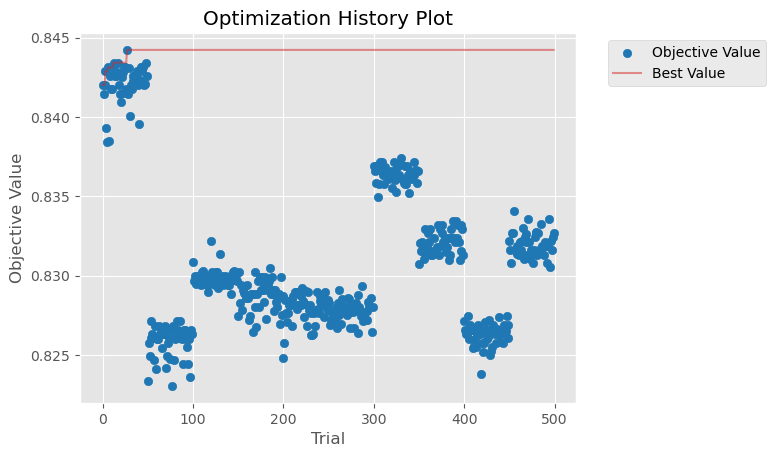

In [38]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_rf)

In [36]:
detailed_objective_rf_CV(study_rf.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,TP,208.800000,9.077445
1,TN,175.900000,9.960477
2,FP,42.900000,8.116513
3,FN,31.600000,3.169297
4,Accuracy,0.837767,0.017906
5,Precision,0.829880,0.029032
6,Sensitivity,0.868559,0.011850
7,Specificity,0.804190,0.033103
8,F1 score,0.848517,0.016894
9,F1 score (weighted),0.837468,0.018120


In [39]:
mat_met_rf_test['ave'] = mat_met_rf_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_rf_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave
0,TP,421.000000,422.000000,423.000000,448.000000,408.000000,415.000000,458.000000,429.000000,397.000000,420.000000,424.100000
1,TN,344.000000,357.000000,338.000000,320.000000,347.000000,357.000000,320.000000,343.000000,359.000000,375.000000,346.000000
2,FP,83.000000,78.000000,84.000000,84.000000,83.000000,78.000000,84.000000,87.000000,90.000000,75.000000,82.600000
3,FN,71.000000,62.000000,74.000000,67.000000,81.000000,69.000000,57.000000,60.000000,73.000000,49.000000,66.300000
4,Accuracy,0.832427,0.847661,0.828074,0.835691,0.821545,0.840044,0.846572,0.840044,0.822633,0.865071,0.837976
5,Precision,0.835317,0.844000,0.834320,0.842105,0.830957,0.841785,0.845018,0.831395,0.815195,0.848485,0.836858
6,Sensitivity,0.855691,0.871901,0.851107,0.869903,0.834356,0.857438,0.889320,0.877301,0.844681,0.895522,0.864722
7,Specificity,0.805600,0.820700,0.800900,0.792100,0.807000,0.820700,0.792100,0.797700,0.799600,0.833300,0.806970
8,F1 score,0.845382,0.857724,0.842629,0.855778,0.832653,0.849539,0.866604,0.853731,0.829676,0.871369,0.850509
9,F1 score (weighted),0.832242,0.847472,0.827899,0.835259,0.821519,0.839944,0.845880,0.839600,0.822497,0.864883,0.837720


In [43]:
#change to fit into these X values 

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)



Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_rf=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_rf = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=1121218, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )
        optimizedCV_rf.fit(X_train,
                          y_train, 
                          
                  )
        #print(test_idx)
        y_pred_optimized_rf = optimizedCV_rf.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_rf': y_pred_optimized_rf } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
   
        conf_matrix = confusion_matrix(y_test, y_pred_optimized_rf)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
    
        Accuracy_outer.append(accuracy_score(y_test, y_pred_optimized_rf))
        Precision_outer.append(precision_score(y_test, y_pred_optimized_rf))
        Sensitivity_outer.append(recall_score(y_test, y_pred_optimized_rf))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test, y_pred_optimized_rf))
        f1_scores_W_outer.append(f1_score(y_test, y_pred_optimized_rf, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test, y_pred_optimized_rf, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test, y_pred_optimized_rf))
        MCC_outer.append(matthews_corrcoef(y_test, y_pred_optimized_rf))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test, y_pred_optimized_rf))
    data_rf['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_rf['y_test' + str(i)] = data_inner['y_test']
    data_rf['y_pred_rf' + str(i)] = data_inner['y_pred_rf']
   # data_rf['correct' + str(i)] = correct_value
   # data_rf['pred' + str(i)] = y_pred_optimized_rf

mat_met_optimized_rf = pd.DataFrame({'Metric':['Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [ np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 

mat_met_optimized_rf


,Metric,Value (average),Value (std)
0,Accuracy,0.841246,0.016030
1,Precision,0.830379,0.022069
2,Sensitivity,0.875894,0.021630
3,Specificity,0.803220,0.026590
4,F1 score,0.852273,0.015900
5,F1 score (weighted),0.840876,0.016088
6,F1 score (macro),0.840126,0.016147
7,Balanced Accuracy,0.839558,0.016183
8,MCC,0.682271,0.032250
9,NPV,0.855076,0.023764


In [44]:
#cross valide using this optimized RF 
rf_baseline_CVscore = cross_val_score(rf_clf, X, Y, cv=10, scoring="f1_macro")
#rf_opt_testSet_score = cross_val_score(optimized_rf, X, Y, cv=10, scoring="f1_macro")
rf_opt_CVscore = cross_val_score(optimizedCV_rf, X, Y, cv=10, scoring="f1_macro")
print("RF baseline model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(rf_baseline_CVscore), np.std(rf_baseline_CVscore, ddof=1)))
#print("RF optimized model (tested on Y_te) f1_score %0.4f with a standard deviation of %0.4f" % (rf_opt_testSet_score.mean(), rf_opt_testSet_score.std()))
print("RF optimized model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(rf_opt_CVscore), np.std(rf_opt_CVscore, ddof=1)))

RF baseline model f1_score 0.8290 with a standard deviation of 0.0218
RF optimized model f1_score 0.8322 with a standard deviation of 0.0220


In [45]:
# save the modesls, both the one with optimized hyperparameters and the initial one
joblib.dump(rf_clf, "OUTPUT/rf_clf.joblib")
joblib.dump(optimizedCV_rf, "OUTPUT/optimizedCV_rf_clf.joblib")

['OUTPUT/optimizedCV_rf_clf.joblib']

## LGBMclassifier

In [46]:
%%time

TP=np.empty(10)
TN = np.empty(10)
FP= np.empty(10)
FN= np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W=np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        
        lgbm_clf = lgbm.LGBMClassifier(
        objective="binary",
        random_state=1121218,
        #n_estimators=150,
        boosting_type ="gbdt",  # default histogram binning of LGBM,
        n_jobs=16,
        #min_child_samples = 15,
        subsample=0.8, # also called bagging_fraction
        subsample_freq=10,
     
           )


        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_clf.fit(
                    X_train,
                    y_train,
                    eval_set=eval_set,
                    eval_metric="logloss",
                    #early_stopping_rounds=150,
                    verbose=False,
                    )

        y_pred = lgbm_clf.predict(X_test) 
        
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test, y_pred)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


mat_met_lgbm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
print(mat_met_lgbm)

                 Metric  Value (average)  Value (std)
0                    TP       206.500000     9.119576
1                    TN       177.500000     8.897565
2                    FP        41.300000     6.549809
3                    FN        33.900000     4.724640
4              Accuracy         0.836245     0.014583
5             Precision         0.833452     0.024372
6           Sensitivity         0.859077     0.018360
7           Specificity         0.811500     0.026295
8              F1 score         0.845795     0.014945
9   F1 score (weighted)         0.836079     0.014711
10     F1 score (macro)         0.835397     0.014524
11    Balanced Accuracy         0.835285     0.014555
12                  MCC         0.671828     0.028234
13                  NPV         0.839640     0.020181
14              ROC_AUC         0.835285     0.014555
CPU times: user 29.7 s, sys: 176 ms, total: 29.9 s
Wall time: 2.05 s


In [47]:
import optuna  

def objective_lgbm_CV(trial, X, Y, Y_class):
    param_grid = {
        #"device_type": trial.suggestegorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_bin": trial.suggest_int("max_bin", 150, 300),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"lambda_l1": trial.suggest_float("lambda_l1", 0, 0.001),
        #"lambda_l2": trial.suggest_float("lambda_l2", 1.0,100),
        "num_leaves": trial.suggest_int("num_leaves", 30, 750),
        #"min_child_samples": trial.suggest_int("min_child_samples", 15, 100),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.6,1),
        #"bagging_freq": trial.suggestegorical("bagging_freq", [1]),
        }
  
    
    
    
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        lgbm_model = lgbm.LGBMClassifier(objective="binary", 
                                            random_state=1121218, 
                                            boosting_type ="gbdt", 
                                            **param_grid, n_jobs=16,
                                            subsample=0.8, # also called bagging_fraction
                                            subsample_freq=10,
                                         )
    
        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        y_pred = lgbm_model.predict(X_test)
        cv_scores[idx] = f1_score(y_test, y_pred, average="macro")
       
        
    return np.mean(cv_scores)

In [48]:
#this is basically inner set parameters
def detailed_objective_lgbm_cv(trial, X, Y, Y_class):
    param_grid = {
        #"device_type": trial.suggestegorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_bin": trial.suggest_int("max_bin", 150, 300),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"lambda_l1": trial.suggest_float("lambda_l1", 0, 0.001),
        #"lambda_l2": trial.suggest_float("lambda_l2", 1.0,100),
        "num_leaves": trial.suggest_int("num_leaves", 30, 750),
        #"min_child_samples": trial.suggest_int("min_child_samples", 15, 100),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.6,1),
        #"bagging_freq": trial.suggestegorical("bagging_freq", [1]),
        
    }
    
    
  
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M =np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        lgbm_model = lgbm.LGBMClassifier(objective="binary", 
                                            random_state=1121218, 
                                            boosting_type ="gbdt", 
                                            **param_grid, n_jobs=16,
                                            subsample=0.8, # also called bagging_fraction
                                            subsample_freq=10,
                                         )
    
        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        
        y_pred = lgbm_model.predict(X_test)
        
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test, y_pred)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


    mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    print(mat_met)

In [49]:
#Execute optuna and set hyperparameters
study_lgbm = optuna.create_study(direction='maximize', study_name="LGBMClassifier")
func_lgbm_0 = lambda trial: objective_lgbm_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_lgbm.optimize(func_lgbm_0, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 09:21:54,537] A new study created in memory with name: LGBMClassifier
[I 2023-12-04 09:21:56,216] Trial 0 finished with value: 0.8310635802908269 and parameters: {'n_estimators': 764, 'learning_rate': 0.19464600839496699, 'max_depth': 6, 'max_bin': 230, 'num_leaves': 291}. Best is trial 0 with value: 0.8310635802908269.
[I 2023-12-04 09:21:57,718] Trial 1 finished with value: 0.7930928373904333 and parameters: {'n_estimators': 236, 'learning_rate': 0.04133121877691464, 'max_depth': 4, 'max_bin': 280, 'num_leaves': 286}. Best is trial 0 with value: 0.8310635802908269.
[I 2023-12-04 09:21:59,875] Trial 2 finished with value: 0.832571410803211 and parameters: {'n_estimators': 773, 'learning_rate': 0.1289507840886797, 'max_depth': 7, 'max_bin': 288, 'num_leaves': 196}. Best is trial 2 with value: 0.832571410803211.
[I 2023-12-04 09:22:06,113] Trial 3 finished with value: 0.8307280139601657 and parameters: {'n_estimators': 650, 'learning_rate': 0.030073005085240856, 'max_depth

	Number of trials: 50.0
	Best value (f1_score): 0.8421
	Best params:
		n_estimators: 565
		learning_rate: 0.1469074717142049
		max_depth: 11
		max_bin: 246
		num_leaves: 397


In [50]:
optimized_lgbm_0 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )
                                         
    
eval_set = [(X_testSet0, Y_testSet0)]
optimized_lgbm_0.fit(X_trainSet0,
                Y_trainSet0,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )

#predict        
y_pred_lgbm_0 = optimized_lgbm_0.predict(X_testSet0)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0, y_pred_lgbm_0)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0, y_pred_lgbm_0)
Precision = precision_score(Y_testSet0, y_pred_lgbm_0)
Sensitivity = recall_score(Y_testSet0, y_pred_lgbm_0)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0, y_pred_lgbm_0)      
f1_scores_W = f1_score(Y_testSet0, y_pred_lgbm_0, average="weighted")
f1_scores_M = f1_score(Y_testSet0, y_pred_lgbm_0, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0, y_pred_lgbm_0)
MCC = matthews_corrcoef(Y_testSet0, y_pred_lgbm_0)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0, y_pred_lgbm_0)


mat_met_lgbm_test = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
    
print(mat_met_lgbm_test)



                 Metric        Set0
0                    TP  418.000000
1                    TN  335.000000
2                    FP   92.000000
3                    FN   74.000000
4              Accuracy    0.819369
5             Precision    0.819608
6           Sensitivity    0.849593
7           Specificity    0.784500
8              F1 score    0.834331
9   F1 score (weighted)    0.819047
10     F1 score (macro)    0.817883
11    Balanced Accuracy    0.817068
12                  MCC    0.636404
13                  NPV    0.819100
14              ROC_AUC    0.817068


In [51]:
#Execute optuna and set hyperparameters

func_lgbm_1 = lambda trial: objective_lgbm_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_lgbm.optimize(func_lgbm_1, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 09:24:00,829] Trial 50 finished with value: 0.8252737509966049 and parameters: {'n_estimators': 806, 'learning_rate': 0.11468918030689715, 'max_depth': 12, 'max_bin': 160, 'num_leaves': 314}. Best is trial 18 with value: 0.8420546677607827.
[I 2023-12-04 09:24:03,220] Trial 51 finished with value: 0.8253481612408551 and parameters: {'n_estimators': 521, 'learning_rate': 0.13328607232150835, 'max_depth': 12, 'max_bin': 166, 'num_leaves': 217}. Best is trial 18 with value: 0.8420546677607827.
[I 2023-12-04 09:24:05,386] Trial 52 finished with value: 0.8256892137575027 and parameters: {'n_estimators': 892, 'learning_rate': 0.13932174695191077, 'max_depth': 12, 'max_bin': 152, 'num_leaves': 100}. Best is trial 18 with value: 0.8420546677607827.
[I 2023-12-04 09:24:07,874] Trial 53 finished with value: 0.8257796658309344 and parameters: {'n_estimators': 563, 'learning_rate': 0.12759336497594148, 'max_depth': 12, 'max_bin': 184, 'num_leaves': 261}. Best is trial 18 with value: 

	Number of trials: 100.0
	Best value (f1_score): 0.8421
	Best params:
		n_estimators: 565
		learning_rate: 0.1469074717142049
		max_depth: 11
		max_bin: 246
		num_leaves: 397


In [52]:
optimized_lgbm_1 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )
    
eval_set = [(X_testSet1, Y_testSet1)]
optimized_lgbm_1.fit(X_trainSet1,
                Y_trainSet1,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )

#predict        
y_pred_lgbm_1 = optimized_lgbm_1.predict(X_testSet1)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1, y_pred_lgbm_1)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1, y_pred_lgbm_1)
Precision = precision_score(Y_testSet1, y_pred_lgbm_1)
Sensitivity = recall_score(Y_testSet1, y_pred_lgbm_1)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1, y_pred_lgbm_1)      
f1_scores_W = f1_score(Y_testSet1, y_pred_lgbm_1, average="weighted")
f1_scores_M = f1_score(Y_testSet1, y_pred_lgbm_1, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1, y_pred_lgbm_1)
MCC = matthews_corrcoef(Y_testSet1, y_pred_lgbm_1)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1, y_pred_lgbm_1)


set1 = pd.DataFrame({ 'Set1':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set1'] =set1
print(mat_met_lgbm_test)


                 Metric        Set0        Set1
0                    TP  418.000000  416.000000
1                    TN  335.000000  359.000000
2                    FP   92.000000   76.000000
3                    FN   74.000000   68.000000
4              Accuracy    0.819369    0.843308
5             Precision    0.819608    0.845528
6           Sensitivity    0.849593    0.859504
7           Specificity    0.784500    0.825300
8              F1 score    0.834331    0.852459
9   F1 score (weighted)    0.819047    0.843223
10     F1 score (macro)    0.817883    0.842703
11    Balanced Accuracy    0.817068    0.842396
12                  MCC    0.636404    0.685534
13                  NPV    0.819100    0.840700
14              ROC_AUC    0.817068    0.842396


In [53]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_2 = lambda trial: objective_lgbm_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_lgbm.optimize(func_lgbm_2, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 09:25:47,567] Trial 100 finished with value: 0.8227133816608495 and parameters: {'n_estimators': 555, 'learning_rate': 0.14212038283507245, 'max_depth': 7, 'max_bin': 175, 'num_leaves': 168}. Best is trial 18 with value: 0.8420546677607827.
[I 2023-12-04 09:25:50,427] Trial 101 finished with value: 0.8269822332779875 and parameters: {'n_estimators': 524, 'learning_rate': 0.11764027009038805, 'max_depth': 12, 'max_bin': 272, 'num_leaves': 722}. Best is trial 18 with value: 0.8420546677607827.
[I 2023-12-04 09:25:52,157] Trial 102 finished with value: 0.8205767276847462 and parameters: {'n_estimators': 537, 'learning_rate': 0.15734233095860684, 'max_depth': 4, 'max_bin': 260, 'num_leaves': 651}. Best is trial 18 with value: 0.8420546677607827.
[I 2023-12-04 09:25:54,255] Trial 103 finished with value: 0.8222778387896674 and parameters: {'n_estimators': 498, 'learning_rate': 0.17053912343869299, 'max_depth': 12, 'max_bin': 288, 'num_leaves': 610}. Best is trial 18 with value

	Number of trials: 150.0
	Best value (f1_score): 0.8421
	Best params:
		n_estimators: 565
		learning_rate: 0.1469074717142049
		max_depth: 11
		max_bin: 246
		num_leaves: 397


In [54]:
optimized_lgbm_2 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet2, Y_testSet2)]
optimized_lgbm_2.fit(X_trainSet2,
                Y_trainSet2,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_2 = optimized_lgbm_2.predict(X_testSet2)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2, y_pred_lgbm_2)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2, y_pred_lgbm_2)
Precision = precision_score(Y_testSet2, y_pred_lgbm_2)
Sensitivity = recall_score(Y_testSet2, y_pred_lgbm_2)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2, y_pred_lgbm_2)      
f1_scores_W = f1_score(Y_testSet2, y_pred_lgbm_2, average="weighted")
f1_scores_M = f1_score(Y_testSet2, y_pred_lgbm_2, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2, y_pred_lgbm_2)
MCC = matthews_corrcoef(Y_testSet2, y_pred_lgbm_2)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2, y_pred_lgbm_2)


Set2 = pd.DataFrame({ 'Set2':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set2'] = Set2
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2
0                    TP  418.000000  416.000000  417.000000
1                    TN  335.000000  359.000000  349.000000
2                    FP   92.000000   76.000000   73.000000
3                    FN   74.000000   68.000000   80.000000
4              Accuracy    0.819369    0.843308    0.833515
5             Precision    0.819608    0.845528    0.851020
6           Sensitivity    0.849593    0.859504    0.839034
7           Specificity    0.784500    0.825300    0.827000
8              F1 score    0.834331    0.852459    0.844985
9   F1 score (weighted)    0.819047    0.843223    0.833609
10     F1 score (macro)    0.817883    0.842703    0.832598
11    Balanced Accuracy    0.817068    0.842396    0.833024
12                  MCC    0.636404    0.685534    0.665294
13                  NPV    0.819100    0.840700    0.813500
14              ROC_AUC    0.817068    0.842396    0.833024


In [55]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_3 = lambda trial: objective_lgbm_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_lgbm.optimize(func_lgbm_3, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 09:27:45,764] Trial 150 finished with value: 0.8268915521680406 and parameters: {'n_estimators': 116, 'learning_rate': 0.06161451138652288, 'max_depth': 12, 'max_bin': 273, 'num_leaves': 455}. Best is trial 18 with value: 0.8420546677607827.
[I 2023-12-04 09:27:47,914] Trial 151 finished with value: 0.827743396784047 and parameters: {'n_estimators': 791, 'learning_rate': 0.12520546842979985, 'max_depth': 8, 'max_bin': 269, 'num_leaves': 263}. Best is trial 18 with value: 0.8420546677607827.
[I 2023-12-04 09:27:50,089] Trial 152 finished with value: 0.8275196356622573 and parameters: {'n_estimators': 746, 'learning_rate': 0.13768089456381652, 'max_depth': 9, 'max_bin': 276, 'num_leaves': 271}. Best is trial 18 with value: 0.8420546677607827.
[I 2023-12-04 09:27:52,345] Trial 153 finished with value: 0.8338254825752616 and parameters: {'n_estimators': 698, 'learning_rate': 0.13009655326846417, 'max_depth': 10, 'max_bin': 282, 'num_leaves': 242}. Best is trial 18 with value:

	Number of trials: 200.0
	Best value (f1_score): 0.8421
	Best params:
		n_estimators: 565
		learning_rate: 0.1469074717142049
		max_depth: 11
		max_bin: 246
		num_leaves: 397


In [56]:
optimized_lgbm_3 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet3, Y_testSet3)]
optimized_lgbm_3.fit(X_trainSet3,
                Y_trainSet3,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_3 = optimized_lgbm_3.predict(X_testSet3)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3, y_pred_lgbm_3)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3, y_pred_lgbm_3)
Precision = precision_score(Y_testSet3, y_pred_lgbm_3)
Sensitivity = recall_score(Y_testSet3, y_pred_lgbm_3)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3, y_pred_lgbm_3)      
f1_scores_W = f1_score(Y_testSet3, y_pred_lgbm_3, average="weighted")
f1_scores_M = f1_score(Y_testSet3, y_pred_lgbm_3, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3, y_pred_lgbm_3)
MCC = matthews_corrcoef(Y_testSet3, y_pred_lgbm_3)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3, y_pred_lgbm_3)


Set3 = pd.DataFrame({ 'Set3':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set3'] = Set3
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3
0                    TP  418.000000  416.000000  417.000000  440.000000
1                    TN  335.000000  359.000000  349.000000  327.000000
2                    FP   92.000000   76.000000   73.000000   77.000000
3                    FN   74.000000   68.000000   80.000000   75.000000
4              Accuracy    0.819369    0.843308    0.833515    0.834603
5             Precision    0.819608    0.845528    0.851020    0.851064
6           Sensitivity    0.849593    0.859504    0.839034    0.854369
7           Specificity    0.784500    0.825300    0.827000    0.809400
8              F1 score    0.834331    0.852459    0.844985    0.852713
9   F1 score (weighted)    0.819047    0.843223    0.833609    0.834558
10     F1 score (macro)    0.817883    0.842703    0.832598    0.832064
11    Balanced Accuracy    0.817068    0.842396    0.833024    0.831887
12                  MCC    0.636404    0.685534    0.665294    0

In [57]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_4 = lambda trial: objective_lgbm_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_lgbm.optimize(func_lgbm_4, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 09:29:44,798] Trial 200 finished with value: 0.8356402469277138 and parameters: {'n_estimators': 426, 'learning_rate': 0.10010975227735432, 'max_depth': 12, 'max_bin': 246, 'num_leaves': 376}. Best is trial 18 with value: 0.8420546677607827.
[I 2023-12-04 09:29:46,921] Trial 201 finished with value: 0.8291502909103677 and parameters: {'n_estimators': 562, 'learning_rate': 0.14623186302931424, 'max_depth': 9, 'max_bin': 240, 'num_leaves': 317}. Best is trial 18 with value: 0.8420546677607827.
[I 2023-12-04 09:29:49,217] Trial 202 finished with value: 0.8271223861410826 and parameters: {'n_estimators': 530, 'learning_rate': 0.14043662398614382, 'max_depth': 10, 'max_bin': 252, 'num_leaves': 503}. Best is trial 18 with value: 0.8420546677607827.
[I 2023-12-04 09:29:51,335] Trial 203 finished with value: 0.8268297271971885 and parameters: {'n_estimators': 501, 'learning_rate': 0.17590028543178246, 'max_depth': 9, 'max_bin': 243, 'num_leaves': 381}. Best is trial 18 with value

	Number of trials: 250.0
	Best value (f1_score): 0.8421
	Best params:
		n_estimators: 565
		learning_rate: 0.1469074717142049
		max_depth: 11
		max_bin: 246
		num_leaves: 397


In [58]:
optimized_lgbm_4 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet4, Y_testSet4)]
optimized_lgbm_4.fit(X_trainSet4,
                Y_trainSet4,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_4 = optimized_lgbm_4.predict(X_testSet4)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4, y_pred_lgbm_4)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4, y_pred_lgbm_4)
Precision = precision_score(Y_testSet4, y_pred_lgbm_4)
Sensitivity = recall_score(Y_testSet4, y_pred_lgbm_4)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4, y_pred_lgbm_4)      
f1_scores_W = f1_score(Y_testSet4, y_pred_lgbm_4, average="weighted")
f1_scores_M = f1_score(Y_testSet4, y_pred_lgbm_4, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4, y_pred_lgbm_4)
MCC = matthews_corrcoef(Y_testSet4, y_pred_lgbm_4)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4, y_pred_lgbm_4)


Set4 = pd.DataFrame({ 'Set4':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set4'] = Set4
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  418.000000  416.000000  417.000000  440.000000   
1                    TN  335.000000  359.000000  349.000000  327.000000   
2                    FP   92.000000   76.000000   73.000000   77.000000   
3                    FN   74.000000   68.000000   80.000000   75.000000   
4              Accuracy    0.819369    0.843308    0.833515    0.834603   
5             Precision    0.819608    0.845528    0.851020    0.851064   
6           Sensitivity    0.849593    0.859504    0.839034    0.854369   
7           Specificity    0.784500    0.825300    0.827000    0.809400   
8              F1 score    0.834331    0.852459    0.844985    0.852713   
9   F1 score (weighted)    0.819047    0.843223    0.833609    0.834558   
10     F1 score (macro)    0.817883    0.842703    0.832598    0.832064   
11    Balanced Accuracy    0.817068    0.842396    0.833024    0.831887   
12                  MCC  

In [59]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_5 = lambda trial: objective_lgbm_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_lgbm.optimize(func_lgbm_5, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 09:31:55,314] Trial 250 finished with value: 0.8217145604032355 and parameters: {'n_estimators': 806, 'learning_rate': 0.11656444586326072, 'max_depth': 7, 'max_bin': 270, 'num_leaves': 424}. Best is trial 18 with value: 0.8420546677607827.
[I 2023-12-04 09:31:57,267] Trial 251 finished with value: 0.8244266632398647 and parameters: {'n_estimators': 877, 'learning_rate': 0.16584286481427007, 'max_depth': 11, 'max_bin': 257, 'num_leaves': 110}. Best is trial 18 with value: 0.8420546677607827.
[I 2023-12-04 09:32:00,990] Trial 252 finished with value: 0.8264875668039042 and parameters: {'n_estimators': 297, 'learning_rate': 0.05281719179701623, 'max_depth': 11, 'max_bin': 154, 'num_leaves': 175}. Best is trial 18 with value: 0.8420546677607827.
[I 2023-12-04 09:32:03,522] Trial 253 finished with value: 0.8199844861433233 and parameters: {'n_estimators': 558, 'learning_rate': 0.10245419883754107, 'max_depth': 8, 'max_bin': 275, 'num_leaves': 309}. Best is trial 18 with value

	Number of trials: 300.0
	Best value (f1_score): 0.8421
	Best params:
		n_estimators: 565
		learning_rate: 0.1469074717142049
		max_depth: 11
		max_bin: 246
		num_leaves: 397


In [60]:
optimized_lgbm_5 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet5, Y_testSet5)]
optimized_lgbm_5.fit(X_trainSet5,
                Y_trainSet5,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_5 = optimized_lgbm_5.predict(X_testSet5)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5, y_pred_lgbm_5)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5, y_pred_lgbm_5)
Precision = precision_score(Y_testSet5, y_pred_lgbm_5)
Sensitivity = recall_score(Y_testSet5, y_pred_lgbm_5)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5, y_pred_lgbm_5)      
f1_scores_W = f1_score(Y_testSet5, y_pred_lgbm_5, average="weighted")
f1_scores_M = f1_score(Y_testSet5, y_pred_lgbm_5, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5, y_pred_lgbm_5)
MCC = matthews_corrcoef(Y_testSet5, y_pred_lgbm_5)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5, y_pred_lgbm_5)


Set5 = pd.DataFrame({ 'Set5':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set5'] = Set5
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  418.000000  416.000000  417.000000  440.000000   
1                    TN  335.000000  359.000000  349.000000  327.000000   
2                    FP   92.000000   76.000000   73.000000   77.000000   
3                    FN   74.000000   68.000000   80.000000   75.000000   
4              Accuracy    0.819369    0.843308    0.833515    0.834603   
5             Precision    0.819608    0.845528    0.851020    0.851064   
6           Sensitivity    0.849593    0.859504    0.839034    0.854369   
7           Specificity    0.784500    0.825300    0.827000    0.809400   
8              F1 score    0.834331    0.852459    0.844985    0.852713   
9   F1 score (weighted)    0.819047    0.843223    0.833609    0.834558   
10     F1 score (macro)    0.817883    0.842703    0.832598    0.832064   
11    Balanced Accuracy    0.817068    0.842396    0.833024    0.831887   
12                  MCC  

In [61]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_6 = lambda trial: objective_lgbm_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_lgbm.optimize(func_lgbm_6, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.6f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 09:34:04,499] Trial 300 finished with value: 0.8356128304870106 and parameters: {'n_estimators': 125, 'learning_rate': 0.1431399584010487, 'max_depth': 11, 'max_bin': 173, 'num_leaves': 661}. Best is trial 18 with value: 0.8420546677607827.
[I 2023-12-04 09:34:06,744] Trial 301 finished with value: 0.8284463368399224 and parameters: {'n_estimators': 135, 'learning_rate': 0.05751128998871463, 'max_depth': 11, 'max_bin': 173, 'num_leaves': 241}. Best is trial 18 with value: 0.8420546677607827.
[I 2023-12-04 09:34:08,835] Trial 302 finished with value: 0.8357401948801005 and parameters: {'n_estimators': 125, 'learning_rate': 0.1369779672646758, 'max_depth': 11, 'max_bin': 228, 'num_leaves': 650}. Best is trial 18 with value: 0.8420546677607827.
[I 2023-12-04 09:34:11,450] Trial 303 finished with value: 0.8378621481208667 and parameters: {'n_estimators': 812, 'learning_rate': 0.1346532466516776, 'max_depth': 11, 'max_bin': 227, 'num_leaves': 526}. Best is trial 18 with value:

	Number of trials: 350.0
	Best value (f1_score): 0.844133
	Best params:
		n_estimators: 896
		learning_rate: 0.12363183341754728
		max_depth: 11
		max_bin: 221
		num_leaves: 483


In [62]:
optimized_lgbm_6 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet6, Y_testSet6)]
optimized_lgbm_6.fit(X_trainSet6,
                Y_trainSet6,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_6 = optimized_lgbm_6.predict(X_testSet6)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6, y_pred_lgbm_6)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6, y_pred_lgbm_6)
Precision = precision_score(Y_testSet6, y_pred_lgbm_6)
Sensitivity = recall_score(Y_testSet6, y_pred_lgbm_6)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6, y_pred_lgbm_6)      
f1_scores_W = f1_score(Y_testSet6, y_pred_lgbm_6, average="weighted")
f1_scores_M = f1_score(Y_testSet6, y_pred_lgbm_6, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6, y_pred_lgbm_6)
MCC = matthews_corrcoef(Y_testSet6, y_pred_lgbm_6)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6, y_pred_lgbm_6)


Set6 = pd.DataFrame({ 'Set6':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set6'] = Set6
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  418.000000  416.000000  417.000000  440.000000   
1                    TN  335.000000  359.000000  349.000000  327.000000   
2                    FP   92.000000   76.000000   73.000000   77.000000   
3                    FN   74.000000   68.000000   80.000000   75.000000   
4              Accuracy    0.819369    0.843308    0.833515    0.834603   
5             Precision    0.819608    0.845528    0.851020    0.851064   
6           Sensitivity    0.849593    0.859504    0.839034    0.854369   
7           Specificity    0.784500    0.825300    0.827000    0.809400   
8              F1 score    0.834331    0.852459    0.844985    0.852713   
9   F1 score (weighted)    0.819047    0.843223    0.833609    0.834558   
10     F1 score (macro)    0.817883    0.842703    0.832598    0.832064   
11    Balanced Accuracy    0.817068    0.842396    0.833024    0.831887   
12                  MCC  

In [63]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_7 = lambda trial: objective_lgbm_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_lgbm.optimize(func_lgbm_7, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.7f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 09:36:12,104] Trial 350 finished with value: 0.8312633490495351 and parameters: {'n_estimators': 838, 'learning_rate': 0.1312058411275479, 'max_depth': 11, 'max_bin': 221, 'num_leaves': 446}. Best is trial 326 with value: 0.8441334757608144.
[I 2023-12-04 09:36:14,711] Trial 351 finished with value: 0.8298779101108344 and parameters: {'n_estimators': 855, 'learning_rate': 0.12017127223669051, 'max_depth': 11, 'max_bin': 216, 'num_leaves': 501}. Best is trial 326 with value: 0.8441334757608144.
[I 2023-12-04 09:36:17,417] Trial 352 finished with value: 0.8376660455516095 and parameters: {'n_estimators': 879, 'learning_rate': 0.11300534147510592, 'max_depth': 11, 'max_bin': 209, 'num_leaves': 542}. Best is trial 326 with value: 0.8441334757608144.
[I 2023-12-04 09:36:20,276] Trial 353 finished with value: 0.8333067832912635 and parameters: {'n_estimators': 882, 'learning_rate': 0.11505008313578166, 'max_depth': 11, 'max_bin': 206, 'num_leaves': 545}. Best is trial 326 with 

	Number of trials: 400.0
	Best value (f1_score): 0.8441335
	Best params:
		n_estimators: 896
		learning_rate: 0.12363183341754728
		max_depth: 11
		max_bin: 221
		num_leaves: 483


In [64]:
optimized_lgbm_7 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet7, Y_testSet7)]
optimized_lgbm_7.fit(X_trainSet7,
                Y_trainSet7,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_7 = optimized_lgbm_7.predict(X_testSet7)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7, y_pred_lgbm_7)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7, y_pred_lgbm_7)
Precision = precision_score(Y_testSet7, y_pred_lgbm_7)
Sensitivity = recall_score(Y_testSet7, y_pred_lgbm_7)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7, y_pred_lgbm_7)      
f1_scores_W = f1_score(Y_testSet7, y_pred_lgbm_7, average="weighted")
f1_scores_M = f1_score(Y_testSet7, y_pred_lgbm_7, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7, y_pred_lgbm_7)
MCC = matthews_corrcoef(Y_testSet7, y_pred_lgbm_7)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7, y_pred_lgbm_7)


Set7 = pd.DataFrame({ 'Set7':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set7'] = Set7
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  418.000000  416.000000  417.000000  440.000000   
1                    TN  335.000000  359.000000  349.000000  327.000000   
2                    FP   92.000000   76.000000   73.000000   77.000000   
3                    FN   74.000000   68.000000   80.000000   75.000000   
4              Accuracy    0.819369    0.843308    0.833515    0.834603   
5             Precision    0.819608    0.845528    0.851020    0.851064   
6           Sensitivity    0.849593    0.859504    0.839034    0.854369   
7           Specificity    0.784500    0.825300    0.827000    0.809400   
8              F1 score    0.834331    0.852459    0.844985    0.852713   
9   F1 score (weighted)    0.819047    0.843223    0.833609    0.834558   
10     F1 score (macro)    0.817883    0.842703    0.832598    0.832064   
11    Balanced Accuracy    0.817068    0.842396    0.833024    0.831887   
12                  MCC  

In [65]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_8 = lambda trial: objective_lgbm_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_lgbm.optimize(func_lgbm_8, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.8f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 09:38:21,879] Trial 400 finished with value: 0.8289287722933046 and parameters: {'n_estimators': 814, 'learning_rate': 0.19253384150238267, 'max_depth': 11, 'max_bin': 214, 'num_leaves': 556}. Best is trial 326 with value: 0.8441334757608144.
[I 2023-12-04 09:38:24,216] Trial 401 finished with value: 0.8246063383829029 and parameters: {'n_estimators': 854, 'learning_rate': 0.1350832608584511, 'max_depth': 11, 'max_bin': 215, 'num_leaves': 543}. Best is trial 326 with value: 0.8441334757608144.
[I 2023-12-04 09:38:26,430] Trial 402 finished with value: 0.8175297319129106 and parameters: {'n_estimators': 846, 'learning_rate': 0.14290686423701354, 'max_depth': 11, 'max_bin': 230, 'num_leaves': 481}. Best is trial 326 with value: 0.8441334757608144.
[I 2023-12-04 09:38:28,925] Trial 403 finished with value: 0.822712076434607 and parameters: {'n_estimators': 798, 'learning_rate': 0.12910494180676854, 'max_depth': 10, 'max_bin': 210, 'num_leaves': 521}. Best is trial 326 with v

	Number of trials: 450.0
	Best value (f1_score): 0.84413348
	Best params:
		n_estimators: 896
		learning_rate: 0.12363183341754728
		max_depth: 11
		max_bin: 221
		num_leaves: 483


In [66]:
optimized_lgbm_8 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet8, Y_testSet8)]
optimized_lgbm_8.fit(X_trainSet8,
                Y_trainSet8,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_8 = optimized_lgbm_8.predict(X_testSet8)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8, y_pred_lgbm_8)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8, y_pred_lgbm_8)
Precision = precision_score(Y_testSet8, y_pred_lgbm_8)
Sensitivity = recall_score(Y_testSet8, y_pred_lgbm_8)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8, y_pred_lgbm_8)      
f1_scores_W = f1_score(Y_testSet8, y_pred_lgbm_8, average="weighted")
f1_scores_M = f1_score(Y_testSet8, y_pred_lgbm_8, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8, y_pred_lgbm_8)
MCC = matthews_corrcoef(Y_testSet8, y_pred_lgbm_8)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8, y_pred_lgbm_8)


Set8 = pd.DataFrame({ 'Set8':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set8'] = Set8
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  418.000000  416.000000  417.000000  440.000000   
1                    TN  335.000000  359.000000  349.000000  327.000000   
2                    FP   92.000000   76.000000   73.000000   77.000000   
3                    FN   74.000000   68.000000   80.000000   75.000000   
4              Accuracy    0.819369    0.843308    0.833515    0.834603   
5             Precision    0.819608    0.845528    0.851020    0.851064   
6           Sensitivity    0.849593    0.859504    0.839034    0.854369   
7           Specificity    0.784500    0.825300    0.827000    0.809400   
8              F1 score    0.834331    0.852459    0.844985    0.852713   
9   F1 score (weighted)    0.819047    0.843223    0.833609    0.834558   
10     F1 score (macro)    0.817883    0.842703    0.832598    0.832064   
11    Balanced Accuracy    0.817068    0.842396    0.833024    0.831887   
12                  MCC  

In [67]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_9 = lambda trial: objective_lgbm_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_lgbm.optimize(func_lgbm_9, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.9f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 09:40:31,451] Trial 450 finished with value: 0.8301749937555696 and parameters: {'n_estimators': 835, 'learning_rate': 0.130486051037067, 'max_depth': 11, 'max_bin': 224, 'num_leaves': 502}. Best is trial 326 with value: 0.8441334757608144.
[I 2023-12-04 09:40:33,647] Trial 451 finished with value: 0.8230831266410558 and parameters: {'n_estimators': 192, 'learning_rate': 0.1511590022056645, 'max_depth': 10, 'max_bin': 234, 'num_leaves': 536}. Best is trial 326 with value: 0.8441334757608144.
[I 2023-12-04 09:40:36,153] Trial 452 finished with value: 0.82614395573226 and parameters: {'n_estimators': 869, 'learning_rate': 0.13627378665598905, 'max_depth': 11, 'max_bin': 215, 'num_leaves': 473}. Best is trial 326 with value: 0.8441334757608144.
[I 2023-12-04 09:40:38,557] Trial 453 finished with value: 0.8263059184630095 and parameters: {'n_estimators': 854, 'learning_rate': 0.12473435093377731, 'max_depth': 11, 'max_bin': 220, 'num_leaves': 328}. Best is trial 326 with valu

	Number of trials: 500.0
	Best value (f1_score): 0.844133476
	Best params:
		n_estimators: 896
		learning_rate: 0.12363183341754728
		max_depth: 11
		max_bin: 221
		num_leaves: 483


In [68]:
optimized_lgbm_9 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet9, Y_testSet9)]
optimized_lgbm_9.fit(X_trainSet9,
                Y_trainSet9,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_9 = optimized_lgbm_9.predict(X_testSet9)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9, y_pred_lgbm_9)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9, y_pred_lgbm_9)
Precision = precision_score(Y_testSet9, y_pred_lgbm_9)
Sensitivity = recall_score(Y_testSet9, y_pred_lgbm_9)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9, y_pred_lgbm_9)      
f1_scores_W = f1_score(Y_testSet9, y_pred_lgbm_9, average="weighted")
f1_scores_M = f1_score(Y_testSet9, y_pred_lgbm_9, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9, y_pred_lgbm_9)
MCC = matthews_corrcoef(Y_testSet9, y_pred_lgbm_9)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9, y_pred_lgbm_9)


Set9 = pd.DataFrame({ 'Set9':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set9'] = Set9
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  418.000000  416.000000  417.000000  440.000000   
1                    TN  335.000000  359.000000  349.000000  327.000000   
2                    FP   92.000000   76.000000   73.000000   77.000000   
3                    FN   74.000000   68.000000   80.000000   75.000000   
4              Accuracy    0.819369    0.843308    0.833515    0.834603   
5             Precision    0.819608    0.845528    0.851020    0.851064   
6           Sensitivity    0.849593    0.859504    0.839034    0.854369   
7           Specificity    0.784500    0.825300    0.827000    0.809400   
8              F1 score    0.834331    0.852459    0.844985    0.852713   
9   F1 score (weighted)    0.819047    0.843223    0.833609    0.834558   
10     F1 score (macro)    0.817883    0.842703    0.832598    0.832064   
11    Balanced Accuracy    0.817068    0.842396    0.833024    0.831887   
12                  MCC  

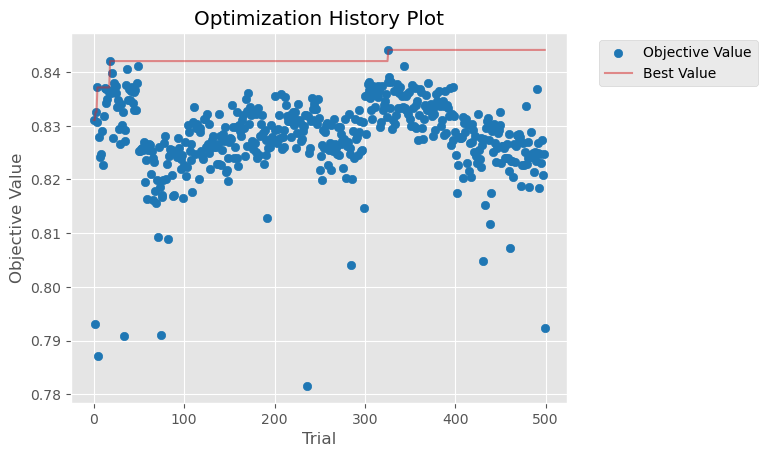

In [69]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_lgbm);

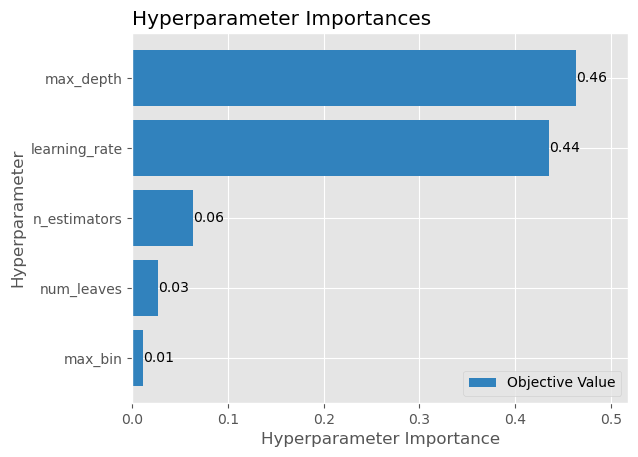

In [70]:
from optuna.visualization.matplotlib import plot_param_importances
plot_param_importances(study_lgbm);

In [71]:
detailed_objective_lgbm_cv(study_lgbm.best_trial, X, Y, Y_class)

                 Metric  Value (average)  Value (std)
0                    TP       205.100000     8.698020
1                    TN       181.500000     9.980537
2                    FP        37.300000     8.857514
3                    FN        35.300000     4.001389
4              Accuracy         0.841908     0.019447
5             Precision         0.846632     0.032542
6           Sensitivity         0.853249     0.014713
7           Specificity         0.829940     0.036425
8              F1 score         0.849579     0.018318
9   F1 score (weighted)         0.841862     0.019607
10     F1 score (macro)         0.841309     0.019447
11    Balanced Accuracy         0.841602     0.019466
12                  MCC         0.683410     0.037836
13                  NPV         0.836990     0.018470
14              ROC_AUC         0.841602     0.019466


In [79]:
#Evaluations metrics on the test sets
mat_met_lgbm_test['ave'] = mat_met_lgbm_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_lgbm_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave
0,TP,418.000000,416.000000,417.000000,440.000000,404.000000,402.000000,438.000000,410.000000,396.000000,400.000000,414.100000
1,TN,335.000000,359.000000,349.000000,327.000000,350.000000,358.000000,326.000000,355.000000,356.000000,375.000000,349.000000
2,FP,92.000000,76.000000,73.000000,77.000000,80.000000,77.000000,78.000000,75.000000,93.000000,75.000000,79.600000
3,FN,74.000000,68.000000,80.000000,75.000000,85.000000,82.000000,77.000000,79.000000,74.000000,69.000000,76.300000
4,Accuracy,0.819369,0.843308,0.833515,0.834603,0.820457,0.826986,0.831338,0.832427,0.818281,0.843308,0.830359
5,Precision,0.819608,0.845528,0.851020,0.851064,0.834711,0.839248,0.848837,0.845361,0.809816,0.842105,0.838730
6,Sensitivity,0.849593,0.859504,0.839034,0.854369,0.826176,0.830579,0.850485,0.838446,0.842553,0.852878,0.844362
7,Specificity,0.784500,0.825300,0.827000,0.809400,0.814000,0.823000,0.806900,0.825600,0.792900,0.833300,0.814190
8,F1 score,0.834331,0.852459,0.844985,0.852713,0.830421,0.834891,0.849661,0.841889,0.825860,0.847458,0.841467
9,F1 score (weighted),0.819047,0.843223,0.833609,0.834558,0.820515,0.827031,0.831316,0.832470,0.818117,0.843280,0.830317


In [80]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)


Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_lgbm=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_lgbm = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


        #learn
        eval_set = [(X_test, y_test)]
        optimizedCV_lgbm.fit(X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
                          
                  
        #print(test_idx)
        y_pred_optimized_lgbm = optimizedCV_lgbm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_lgbm': y_pred_optimized_lgbm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        conf_matrix = confusion_matrix(y_test, y_pred_optimized_lgbm)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
       
        Accuracy_outer.append(accuracy_score(y_test, y_pred_optimized_lgbm))
        Precision_outer.append(precision_score(y_test, y_pred_optimized_lgbm))
        Sensitivity_outer.append(recall_score(y_test, y_pred_optimized_lgbm))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test, y_pred_optimized_lgbm))
        f1_scores_W_outer.append(f1_score(y_test, y_pred_optimized_lgbm, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test, y_pred_optimized_lgbm, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test, y_pred_optimized_lgbm))
        MCC_outer.append(matthews_corrcoef(y_test, y_pred_optimized_lgbm))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test, y_pred_optimized_lgbm))
        
    data_lgbm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_lgbm['y_test' + str(i)] = data_inner['y_test']
    data_lgbm['y_pred_lgbm' + str(i)] = data_inner['y_pred_lgbm']
   # data_lgbm['correct' + str(i)] = correct_value
   # data_lgbm['pred' + str(i)] = y_pred_optimized_lgbm

mat_met_optimized_lgbm = pd.DataFrame({'Metric':['Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [ np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


mat_met_optimized_lgbm


,Metric,Value (average),Value (std)
0,Accuracy,0.839067,0.015714
1,Precision,0.840357,0.023883
2,Sensitivity,0.855192,0.019468
3,Specificity,0.821452,0.026762
4,F1 score,0.847463,0.016177
5,F1 score (weighted),0.838966,0.015772
6,F1 score (macro),0.838368,0.015721
7,Balanced Accuracy,0.838322,0.015904
8,MCC,0.677437,0.031361
9,NPV,0.837884,0.019822


In [81]:
#cross valide using this optimized LightGBM 
fit_params={'early_stopping_rounds': 50, 
        'eval_set': [(X_tr, Y_tr), (X_te, Y_te)],
            'verbose':False,
           }
#cross valide using this optimized LightGBM 
lgbm_baseline_CVscore = cross_val_score(lgbm_clf, X, Y, cv=10, scoring="f1_macro")
#f1_cv_lgbm_opt_testSet = cross_val_score(optimized_lgbm, X, Y, cv=10, scoring="f1_macro")
f1_cv_lgbm_opt = cross_val_score(optimizedCV_lgbm, X, Y, cv=10, scoring="f1_macro", fit_params=fit_params)
print("LightGBM baseline model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(lgbm_baseline_CVscore), np.std(lgbm_baseline_CVscore, ddof=1)))
#print("LightGBM optimized model (tested on Y_te)f1_score %0.4f with a standard deviation of %0.4f" % (f1_cv_lgbm_opt_testSet.mean(), f1_cv_lgbm_opt_testSet.std()))
print("LightGBM optimized model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(f1_cv_lgbm_opt), np.std(f1_cv_lgbm_opt, ddof=1)))

LightGBM baseline model f1_score 0.8258 with a standard deviation of 0.0188
LightGBM optimized model f1_score 0.8339 with a standard deviation of 0.0195


In [82]:
# save the modesls, both the one with optimized hyperparameters and the initial one
joblib.dump(lgbm_clf, "OUTPUT/lgbm_clf.joblib")
joblib.dump(optimizedCV_lgbm, "OUTPUT/optimizedCV_lgbm_clf.joblib") 


['OUTPUT/optimizedCV_lgbm_clf.joblib']

## XGBoost

In [83]:
%%time


TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)


for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    random_state=1121218,
    #n_estimators=10000,  
    tree_method="hist",  # enable histogram binning in XGB
    subsample=0.8, 
    n_jobs=16,
    )
    
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_clf.fit(X_train,
                y_train,
    
    eval_set=eval_set,
    eval_metric="logloss",
    early_stopping_rounds=50,
    verbose=False,  # Disable logs
               )

    y_pred = xgb_clf.predict(X_test) 
    
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test, y_pred)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test, y_pred)
    Precision[idx] = precision_score(y_test, y_pred)
    Sensitivity[idx] = recall_score(y_test, y_pred)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test, y_pred)
    f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
    f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
    MCC[idx] = matthews_corrcoef(y_test, y_pred)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    TP       206.900000     9.515484
1                    TN       176.700000    10.719142
2                    FP        42.100000     4.508018
3                    FN        33.500000     3.628590
4              Accuracy         0.835371     0.012165
5             Precision         0.830951     0.016745
6           Sensitivity         0.860616     0.014309
7           Specificity         0.807270     0.021784
8              F1 score         0.845406     0.011637
9   F1 score (weighted)         0.835156     0.012214
10     F1 score (macro)         0.834373     0.012330
11    Balanced Accuracy         0.833940     0.012491
12                  MCC         0.669592     0.024575
13                  NPV         0.840360     0.017907
14              ROC_AUC         0.833940     0.012491
CPU times: user 30.4 s, sys: 224 ms, total: 30.7 s
Wall time: 2.12 s


In [84]:
def objective_xgb_CV(trial, X, Y, Y_class):
    param_grid = {
        
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "eta": trial.suggest_float("eta", 1e-6, 0.1),  
        "max_depth": trial.suggest_int("max_depth", 5, 12),  
        "alpha": trial.suggest_float("alpha", 0, 1, step=1e-04),
        "lambda": trial.suggest_float("lambda", 1,40),
        #"alpha": trial.suggest_float("alpha", 0, 1.0),
        #"lambda": trial.suggest_float("lambda", 1e-8, 40.0),
        "max_bin": trial.suggest_int("max_bin", 250, 500),
    }
    
    
    cv_scores=np.empty(10)
    #y_comb=pd.DataFrame()
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=1121218, booster ="gbtree", tree_method='hist',
                                  **param_grid,  n_jobs=16, subsample=0.8, )
    
        eval_set = [(X_test, y_test)]
        xgb_model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            eval_metric="logloss",    
            early_stopping_rounds=50,
            verbose=False)
    
        y_pred = xgb_model.predict(X_test)
        cv_scores[idx] = f1_score(y_test, y_pred, average="macro")
            
    return np.mean(cv_scores)

In [85]:
def detailed_objective_xgb_CV(trial, X, Y, Y_class):
    param_grid = {
        
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "eta": trial.suggest_float("eta", 1e-6, 0.1),  
        "max_depth": trial.suggest_int("max_depth", 5, 12),  
        "alpha": trial.suggest_float("alpha", 0, 1, step=1e-04),
        "lambda": trial.suggest_float("lambda", 1,40),
        #"alpha": trial.suggest_float("alpha", 0, 1.0),
        #"lambda": trial.suggest_float("lambda", 1e-8, 40.0),
        "max_bin": trial.suggest_int("max_bin", 250, 500),
    }
    
    
    
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W=np.empty(10)
    f1_scores_M=np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=1121218, booster ="gbtree", tree_method='hist',
                                  **param_grid,  n_jobs=16, subsample=0.8, )
    
        eval_set = [(X_test, y_test)]
        xgb_model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            eval_metric="logloss",    
            early_stopping_rounds=50,
            verbose=False)
        
        y_pred = xgb_model.predict(X_test)
        
       
           
        #calculate parameters
        conf_matrix = confusion_matrix(y_test, y_pred)      
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)

    mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
    return (mat_met)   

In [86]:
#Execute optuna and set hyperparameters
study_xgb = optuna.create_study(direction='maximize', study_name="XGBClassifier")
func_xgb_0 = lambda trial: objective_xgb_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_xgb.optimize(func_xgb_0, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 09:50:25,865] A new study created in memory with name: XGBClassifier
[I 2023-12-04 09:50:28,486] Trial 0 finished with value: 0.8079357668927676 and parameters: {'n_estimators': 101, 'eta': 0.05569945587384238, 'max_depth': 9, 'alpha': 0.5312, 'lambda': 34.355158562953406, 'max_bin': 312}. Best is trial 0 with value: 0.8079357668927676.
[I 2023-12-04 09:50:39,832] Trial 1 finished with value: 0.8420673543769908 and parameters: {'n_estimators': 782, 'eta': 0.08572933207576598, 'max_depth': 11, 'alpha': 0.1553, 'lambda': 35.276295674096176, 'max_bin': 476}. Best is trial 1 with value: 0.8420673543769908.
[I 2023-12-04 09:50:51,119] Trial 2 finished with value: 0.8221718286945652 and parameters: {'n_estimators': 481, 'eta': 0.018788344227590226, 'max_depth': 9, 'alpha': 0.6496000000000001, 'lambda': 19.573973456531142, 'max_bin': 420}. Best is trial 1 with value: 0.8420673543769908.
[I 2023-12-04 09:50:54,180] Trial 3 finished with value: 0.8107763688012417 and parameters: {

	Number of trials: 50.0
	Best value (f1_score): 0.8514
	Best params:
		n_estimators: 785
		eta: 0.07389767489222081
		max_depth: 12
		alpha: 0.9650000000000001
		lambda: 2.5359194636827933
		max_bin: 259


In [87]:
#Create an instance with tuned hyperparameters

optimized_xgb_0 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    #learn
eval_set = [(X_testSet0, Y_testSet0)]

optimized_xgb_0.fit(X_trainSet0,Y_trainSet0, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

   
y_pred_xgb_0 = optimized_xgb_0.predict(X_testSet0)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0, y_pred_xgb_0)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0, y_pred_xgb_0)
Precision = precision_score(Y_testSet0, y_pred_xgb_0)
Sensitivity = recall_score(Y_testSet0, y_pred_xgb_0)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0, y_pred_xgb_0)      
f1_scores_W = f1_score(Y_testSet0, y_pred_xgb_0, average="weighted")
f1_scores_M = f1_score(Y_testSet0, y_pred_xgb_0, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0, y_pred_xgb_0)
MCC = matthews_corrcoef(Y_testSet0, y_pred_xgb_0)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0, y_pred_xgb_0)
    

mat_met_xgb_test = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_xgb_test)


                 Metric        Set0
0                    TP  424.000000
1                    TN  339.000000
2                    FP   88.000000
3                    FN   68.000000
4              Accuracy    0.830250
5             Precision    0.828125
6           Sensitivity    0.861789
7           Specificity    0.793900
8              F1 score    0.844622
9   F1 score (weighted)    0.829906
10     F1 score (macro)    0.828786
11    Balanced Accuracy    0.827850
12                  MCC    0.658369
13                  NPV    0.832900
14              ROC_AUC    0.827850


In [88]:
#Execute optuna and set hyperparameters

func_xgb_1 = lambda trial: objective_xgb_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_xgb.optimize(func_xgb_1, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 09:59:46,404] Trial 50 finished with value: 0.8288823195097091 and parameters: {'n_estimators': 635, 'eta': 0.06298438399948547, 'max_depth': 10, 'alpha': 0.9017000000000001, 'lambda': 28.495211353530237, 'max_bin': 412}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 09:59:57,455] Trial 51 finished with value: 0.8306388230690818 and parameters: {'n_estimators': 873, 'eta': 0.03891328959194813, 'max_depth': 12, 'alpha': 0.9703, 'lambda': 2.4134828569336735, 'max_bin': 383}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 10:00:10,483] Trial 52 finished with value: 0.8330826555075902 and parameters: {'n_estimators': 893, 'eta': 0.02828282639562884, 'max_depth': 12, 'alpha': 0.9709000000000001, 'lambda': 1.1656277127851418, 'max_bin': 375}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 10:00:21,050] Trial 53 finished with value: 0.8309564042207109 and parameters: {'n_estimators': 821, 'eta': 0.04676874180320403, 'max_depth': 1

	Number of trials: 100.0
	Best value (f1_score): 0.8514
	Best params:
		n_estimators: 785
		eta: 0.07389767489222081
		max_depth: 12
		alpha: 0.9650000000000001
		lambda: 2.5359194636827933
		max_bin: 259


In [89]:
optimized_xgb_1 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet1, Y_testSet1)]
optimized_xgb_1.fit(X_trainSet1,Y_trainSet1, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_1 = optimized_xgb_1.predict(X_testSet1)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1, y_pred_xgb_1)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1, y_pred_xgb_1)
Precision = precision_score(Y_testSet1, y_pred_xgb_1)
Sensitivity = recall_score(Y_testSet1, y_pred_xgb_1)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1, y_pred_xgb_1)      
f1_scores_W = f1_score(Y_testSet1, y_pred_xgb_1, average="weighted")
f1_scores_M = f1_score(Y_testSet1, y_pred_xgb_1, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1, y_pred_xgb_1)
MCC = matthews_corrcoef(Y_testSet1, y_pred_xgb_1)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1, y_pred_xgb_1)


set1 = pd.DataFrame({ 'Set1':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set1'] =set1
print(mat_met_xgb_test)


                 Metric        Set0        Set1
0                    TP  424.000000  421.000000
1                    TN  339.000000  364.000000
2                    FP   88.000000   71.000000
3                    FN   68.000000   63.000000
4              Accuracy    0.830250    0.854189
5             Precision    0.828125    0.855691
6           Sensitivity    0.861789    0.869835
7           Specificity    0.793900    0.836800
8              F1 score    0.844622    0.862705
9   F1 score (weighted)    0.829906    0.854110
10     F1 score (macro)    0.828786    0.853626
11    Balanced Accuracy    0.827850    0.853308
12                  MCC    0.658369    0.707383
13                  NPV    0.832900    0.852500
14              ROC_AUC    0.827850    0.853308


In [90]:
#Execute optuna and set hyperparameters
func_xgb_2 = lambda trial: objective_xgb_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_xgb.optimize(func_xgb_2, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 10:09:00,783] Trial 100 finished with value: 0.831124565842383 and parameters: {'n_estimators': 604, 'eta': 0.026863514525593366, 'max_depth': 12, 'alpha': 0.9185000000000001, 'lambda': 8.246626659422173, 'max_bin': 398}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 10:09:12,811] Trial 101 finished with value: 0.8352954321229829 and parameters: {'n_estimators': 766, 'eta': 0.031543636681723504, 'max_depth': 10, 'alpha': 0.6116, 'lambda': 1.436015948181276, 'max_bin': 403}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 10:09:27,046] Trial 102 finished with value: 0.8338853386814697 and parameters: {'n_estimators': 831, 'eta': 0.030258726312520155, 'max_depth': 9, 'alpha': 0.5896, 'lambda': 4.557019185632569, 'max_bin': 367}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 10:09:42,870] Trial 103 finished with value: 0.8353243680678535 and parameters: {'n_estimators': 865, 'eta': 0.02429163093130583, 'max_depth': 11, 'alpha'

	Number of trials: 150.0
	Best value (f1_score): 0.8514
	Best params:
		n_estimators: 785
		eta: 0.07389767489222081
		max_depth: 12
		alpha: 0.9650000000000001
		lambda: 2.5359194636827933
		max_bin: 259


In [91]:
optimized_xgb_2 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet2, Y_testSet2)]
optimized_xgb_2.fit(X_trainSet2,Y_trainSet2, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_2 = optimized_xgb_2.predict(X_testSet2)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2, y_pred_xgb_2)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2, y_pred_xgb_2)
Precision = precision_score(Y_testSet2, y_pred_xgb_2)
Sensitivity = recall_score(Y_testSet2, y_pred_xgb_2)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2, y_pred_xgb_2)      
f1_scores_W = f1_score(Y_testSet2, y_pred_xgb_2, average="weighted")
f1_scores_M = f1_score(Y_testSet2, y_pred_xgb_2, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2, y_pred_xgb_2)
MCC = matthews_corrcoef(Y_testSet2, y_pred_xgb_2)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2, y_pred_xgb_2)


Set2 = pd.DataFrame({ 'Set2':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set2'] =Set2
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2
0                    TP  424.000000  421.000000  422.000000
1                    TN  339.000000  364.000000  338.000000
2                    FP   88.000000   71.000000   84.000000
3                    FN   68.000000   63.000000   75.000000
4              Accuracy    0.830250    0.854189    0.826986
5             Precision    0.828125    0.855691    0.833992
6           Sensitivity    0.861789    0.869835    0.849095
7           Specificity    0.793900    0.836800    0.800900
8              F1 score    0.844622    0.862705    0.841476
9   F1 score (weighted)    0.829906    0.854110    0.826830
10     F1 score (macro)    0.828786    0.853626    0.825528
11    Balanced Accuracy    0.827850    0.853308    0.825021
12                  MCC    0.658369    0.707383    0.651217
13                  NPV    0.832900    0.852500    0.818400
14              ROC_AUC    0.827850    0.853308    0.825021


In [92]:
#Execute optuna and set hyperparameters
func_xgb_3 = lambda trial: objective_xgb_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_xgb.optimize(func_xgb_3, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 10:19:03,279] Trial 150 finished with value: 0.8382611396094607 and parameters: {'n_estimators': 833, 'eta': 0.03820709326136296, 'max_depth': 11, 'alpha': 0.5401, 'lambda': 1.0113842251985508, 'max_bin': 371}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 10:19:22,490] Trial 151 finished with value: 0.8373382635907729 and parameters: {'n_estimators': 858, 'eta': 0.021833078015239708, 'max_depth': 11, 'alpha': 0.7901, 'lambda': 2.72807118434846, 'max_bin': 476}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 10:19:42,105] Trial 152 finished with value: 0.8354201800693136 and parameters: {'n_estimators': 810, 'eta': 0.02707609929966719, 'max_depth': 11, 'alpha': 0.8281000000000001, 'lambda': 8.65380409170458, 'max_bin': 491}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 10:20:03,744] Trial 153 finished with value: 0.8362271941562252 and parameters: {'n_estimators': 886, 'eta': 0.019172697896271698, 'max_depth': 11, 'alpha'

	Number of trials: 200.0
	Best value (f1_score): 0.8514
	Best params:
		n_estimators: 785
		eta: 0.07389767489222081
		max_depth: 12
		alpha: 0.9650000000000001
		lambda: 2.5359194636827933
		max_bin: 259


In [93]:
optimized_xgb_3 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet3, Y_testSet3)]
optimized_xgb_3.fit(X_trainSet3,Y_trainSet3, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_3 = optimized_xgb_3.predict(X_testSet3)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3, y_pred_xgb_3)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3, y_pred_xgb_3)
Precision = precision_score(Y_testSet3, y_pred_xgb_3)
Sensitivity = recall_score(Y_testSet3, y_pred_xgb_3)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3, y_pred_xgb_3)      
f1_scores_W = f1_score(Y_testSet3, y_pred_xgb_3, average="weighted")
f1_scores_M = f1_score(Y_testSet3, y_pred_xgb_3, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3, y_pred_xgb_3)
MCC = matthews_corrcoef(Y_testSet3, y_pred_xgb_3)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3, y_pred_xgb_3)


Set3 = pd.DataFrame({ 'Set3':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set3'] =Set3
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3
0                    TP  424.000000  421.000000  422.000000  449.000000
1                    TN  339.000000  364.000000  338.000000  322.000000
2                    FP   88.000000   71.000000   84.000000   82.000000
3                    FN   68.000000   63.000000   75.000000   66.000000
4              Accuracy    0.830250    0.854189    0.826986    0.838955
5             Precision    0.828125    0.855691    0.833992    0.845574
6           Sensitivity    0.861789    0.869835    0.849095    0.871845
7           Specificity    0.793900    0.836800    0.800900    0.797000
8              F1 score    0.844622    0.862705    0.841476    0.858509
9   F1 score (weighted)    0.829906    0.854110    0.826830    0.838560
10     F1 score (macro)    0.828786    0.853626    0.825528    0.835820
11    Balanced Accuracy    0.827850    0.853308    0.825021    0.834437
12                  MCC    0.658369    0.707383    0.651217    0

In [94]:
#Execute optuna and set hyperparameters
func_xgb_4 = lambda trial: objective_xgb_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_xgb.optimize(func_xgb_4, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 10:29:16,734] Trial 200 finished with value: 0.8421544898937672 and parameters: {'n_estimators': 820, 'eta': 0.03545524552102297, 'max_depth': 12, 'alpha': 0.7988000000000001, 'lambda': 2.5313830822985137, 'max_bin': 273}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 10:29:24,865] Trial 201 finished with value: 0.8416881811609918 and parameters: {'n_estimators': 872, 'eta': 0.05911590389944361, 'max_depth': 11, 'alpha': 0.7108, 'lambda': 3.6831271806394144, 'max_bin': 363}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 10:29:36,263] Trial 202 finished with value: 0.838406259455186 and parameters: {'n_estimators': 848, 'eta': 0.06298678826462267, 'max_depth': 11, 'alpha': 0.7448, 'lambda': 14.0595772806587, 'max_bin': 322}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 10:29:43,194] Trial 203 finished with value: 0.8383450308588627 and parameters: {'n_estimators': 562, 'eta': 0.06755741750203524, 'max_depth': 11, 'alpha':

	Number of trials: 250.0
	Best value (f1_score): 0.8514
	Best params:
		n_estimators: 785
		eta: 0.07389767489222081
		max_depth: 12
		alpha: 0.9650000000000001
		lambda: 2.5359194636827933
		max_bin: 259


In [95]:
optimized_xgb_4 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet4, Y_testSet4)]
optimized_xgb_4.fit(X_trainSet4,Y_trainSet4, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_4 = optimized_xgb_4.predict(X_testSet4)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4, y_pred_xgb_4)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4, y_pred_xgb_4)
Precision = precision_score(Y_testSet4, y_pred_xgb_4)
Sensitivity = recall_score(Y_testSet4, y_pred_xgb_4)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4, y_pred_xgb_4)      
f1_scores_W = f1_score(Y_testSet4, y_pred_xgb_4, average="weighted")
f1_scores_M = f1_score(Y_testSet4, y_pred_xgb_4, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4, y_pred_xgb_4)
MCC = matthews_corrcoef(Y_testSet4, y_pred_xgb_4)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4, y_pred_xgb_4)


Set4 = pd.DataFrame({ 'Set4':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set4'] =Set4
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  424.000000  421.000000  422.000000  449.000000   
1                    TN  339.000000  364.000000  338.000000  322.000000   
2                    FP   88.000000   71.000000   84.000000   82.000000   
3                    FN   68.000000   63.000000   75.000000   66.000000   
4              Accuracy    0.830250    0.854189    0.826986    0.838955   
5             Precision    0.828125    0.855691    0.833992    0.845574   
6           Sensitivity    0.861789    0.869835    0.849095    0.871845   
7           Specificity    0.793900    0.836800    0.800900    0.797000   
8              F1 score    0.844622    0.862705    0.841476    0.858509   
9   F1 score (weighted)    0.829906    0.854110    0.826830    0.838560   
10     F1 score (macro)    0.828786    0.853626    0.825528    0.835820   
11    Balanced Accuracy    0.827850    0.853308    0.825021    0.834437   
12                  MCC  

In [96]:
#Execute optuna and set hyperparameters
func_xgb_5 = lambda trial: objective_xgb_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_xgb.optimize(func_xgb_5, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 10:38:39,209] Trial 250 finished with value: 0.8355317329762318 and parameters: {'n_estimators': 797, 'eta': 0.03547299352086025, 'max_depth': 11, 'alpha': 0.8913000000000001, 'lambda': 10.09980004171462, 'max_bin': 462}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 10:38:50,342] Trial 251 finished with value: 0.8358433203300478 and parameters: {'n_estimators': 843, 'eta': 0.04206545899910347, 'max_depth': 12, 'alpha': 0.9699000000000001, 'lambda': 3.2630914903690718, 'max_bin': 250}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 10:39:08,393] Trial 252 finished with value: 0.8322449264398182 and parameters: {'n_estimators': 872, 'eta': 0.033948387053758106, 'max_depth': 10, 'alpha': 0.9233, 'lambda': 12.809002998335355, 'max_bin': 476}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 10:39:22,809] Trial 253 finished with value: 0.8358853854562736 and parameters: {'n_estimators': 814, 'eta': 0.03084668339004399, 'max_depth

	Number of trials: 300.0
	Best value (f1_score): 0.8514
	Best params:
		n_estimators: 785
		eta: 0.07389767489222081
		max_depth: 12
		alpha: 0.9650000000000001
		lambda: 2.5359194636827933
		max_bin: 259


In [97]:
optimized_xgb_5 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet5, Y_testSet5)]
optimized_xgb_5.fit(X_trainSet5,Y_trainSet5, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_5 = optimized_xgb_5.predict(X_testSet5)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5, y_pred_xgb_5)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5, y_pred_xgb_5)
Precision = precision_score(Y_testSet5, y_pred_xgb_5)
Sensitivity = recall_score(Y_testSet5, y_pred_xgb_5)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5, y_pred_xgb_5)      
f1_scores_W = f1_score(Y_testSet5, y_pred_xgb_5, average="weighted")
f1_scores_M = f1_score(Y_testSet5, y_pred_xgb_5, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5, y_pred_xgb_5)
MCC = matthews_corrcoef(Y_testSet5, y_pred_xgb_5)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5, y_pred_xgb_5)


Set5 = pd.DataFrame({ 'Set5':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set5'] =Set5
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  424.000000  421.000000  422.000000  449.000000   
1                    TN  339.000000  364.000000  338.000000  322.000000   
2                    FP   88.000000   71.000000   84.000000   82.000000   
3                    FN   68.000000   63.000000   75.000000   66.000000   
4              Accuracy    0.830250    0.854189    0.826986    0.838955   
5             Precision    0.828125    0.855691    0.833992    0.845574   
6           Sensitivity    0.861789    0.869835    0.849095    0.871845   
7           Specificity    0.793900    0.836800    0.800900    0.797000   
8              F1 score    0.844622    0.862705    0.841476    0.858509   
9   F1 score (weighted)    0.829906    0.854110    0.826830    0.838560   
10     F1 score (macro)    0.828786    0.853626    0.825528    0.835820   
11    Balanced Accuracy    0.827850    0.853308    0.825021    0.834437   
12                  MCC  

In [98]:
#Execute optuna and set hyperparameters
func_xgb_6 = lambda trial: objective_xgb_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_xgb.optimize(func_xgb_6, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 10:48:51,716] Trial 300 finished with value: 0.8423659016959162 and parameters: {'n_estimators': 691, 'eta': 0.04292888738948939, 'max_depth': 12, 'alpha': 0.9993000000000001, 'lambda': 9.266698971512374, 'max_bin': 436}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 10:48:59,464] Trial 301 finished with value: 0.8391489715592055 and parameters: {'n_estimators': 899, 'eta': 0.07030281878917594, 'max_depth': 12, 'alpha': 0.17, 'lambda': 5.503376650555056, 'max_bin': 255}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 10:49:15,816] Trial 302 finished with value: 0.8417973354721793 and parameters: {'n_estimators': 822, 'eta': 0.03831758947337114, 'max_depth': 11, 'alpha': 0.3593, 'lambda': 15.51602568607129, 'max_bin': 272}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 10:49:28,713] Trial 303 finished with value: 0.8432726780294552 and parameters: {'n_estimators': 764, 'eta': 0.03154832904811084, 'max_depth': 11, 'alpha': 0

	Number of trials: 350.0
	Best value (f1_score): 0.8514
	Best params:
		n_estimators: 785
		eta: 0.07389767489222081
		max_depth: 12
		alpha: 0.9650000000000001
		lambda: 2.5359194636827933
		max_bin: 259


In [99]:
optimized_xgb_6 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet6, Y_testSet6)]
optimized_xgb_6.fit(X_trainSet6,Y_trainSet6, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_6 = optimized_xgb_6.predict(X_testSet6)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6, y_pred_xgb_6)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6, y_pred_xgb_6)
Precision = precision_score(Y_testSet6, y_pred_xgb_6)
Sensitivity = recall_score(Y_testSet6, y_pred_xgb_6)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6, y_pred_xgb_6)      
f1_scores_W = f1_score(Y_testSet6, y_pred_xgb_6, average="weighted")
f1_scores_M = f1_score(Y_testSet6, y_pred_xgb_6, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6, y_pred_xgb_6)
MCC = matthews_corrcoef(Y_testSet6, y_pred_xgb_6)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6, y_pred_xgb_6)


Set6 = pd.DataFrame({ 'Set6':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set6'] =Set6
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  424.000000  421.000000  422.000000  449.000000   
1                    TN  339.000000  364.000000  338.000000  322.000000   
2                    FP   88.000000   71.000000   84.000000   82.000000   
3                    FN   68.000000   63.000000   75.000000   66.000000   
4              Accuracy    0.830250    0.854189    0.826986    0.838955   
5             Precision    0.828125    0.855691    0.833992    0.845574   
6           Sensitivity    0.861789    0.869835    0.849095    0.871845   
7           Specificity    0.793900    0.836800    0.800900    0.797000   
8              F1 score    0.844622    0.862705    0.841476    0.858509   
9   F1 score (weighted)    0.829906    0.854110    0.826830    0.838560   
10     F1 score (macro)    0.828786    0.853626    0.825528    0.835820   
11    Balanced Accuracy    0.827850    0.853308    0.825021    0.834437   
12                  MCC  

In [100]:
#Execute optuna and set hyperparameters
func_xgb_7 = lambda trial: objective_xgb_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_xgb.optimize(func_xgb_7, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 10:59:23,778] Trial 350 finished with value: 0.8391072542310349 and parameters: {'n_estimators': 850, 'eta': 0.038524685298318324, 'max_depth': 11, 'alpha': 0.9786, 'lambda': 4.0883796318247505, 'max_bin': 386}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 10:59:34,485] Trial 351 finished with value: 0.8386108869838182 and parameters: {'n_estimators': 822, 'eta': 0.046096463100990914, 'max_depth': 11, 'alpha': 0.9368000000000001, 'lambda': 3.261653928584838, 'max_bin': 396}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 10:59:50,250] Trial 352 finished with value: 0.8374759073540158 and parameters: {'n_estimators': 872, 'eta': 0.03548907755539253, 'max_depth': 11, 'alpha': 0.9593, 'lambda': 6.165502909713305, 'max_bin': 380}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 11:00:01,806] Trial 353 finished with value: 0.8421152753911224 and parameters: {'n_estimators': 843, 'eta': 0.04216155860746145, 'max_depth': 12, 'alph

	Number of trials: 400.0
	Best value (f1_score): 0.8514
	Best params:
		n_estimators: 785
		eta: 0.07389767489222081
		max_depth: 12
		alpha: 0.9650000000000001
		lambda: 2.5359194636827933
		max_bin: 259


In [101]:
optimized_xgb_7 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet7, Y_testSet7)]
optimized_xgb_7.fit(X_trainSet7,Y_trainSet7, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_7 = optimized_xgb_7.predict(X_testSet7)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7, y_pred_xgb_7)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7, y_pred_xgb_7)
Precision = precision_score(Y_testSet7, y_pred_xgb_7)
Sensitivity = recall_score(Y_testSet7, y_pred_xgb_7)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7, y_pred_xgb_7)      
f1_scores_W = f1_score(Y_testSet7, y_pred_xgb_7, average="weighted")
f1_scores_M = f1_score(Y_testSet7, y_pred_xgb_7, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7, y_pred_xgb_7)
MCC = matthews_corrcoef(Y_testSet7, y_pred_xgb_7)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7, y_pred_xgb_7)


Set7 = pd.DataFrame({ 'Set7':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set7'] =Set7
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  424.000000  421.000000  422.000000  449.000000   
1                    TN  339.000000  364.000000  338.000000  322.000000   
2                    FP   88.000000   71.000000   84.000000   82.000000   
3                    FN   68.000000   63.000000   75.000000   66.000000   
4              Accuracy    0.830250    0.854189    0.826986    0.838955   
5             Precision    0.828125    0.855691    0.833992    0.845574   
6           Sensitivity    0.861789    0.869835    0.849095    0.871845   
7           Specificity    0.793900    0.836800    0.800900    0.797000   
8              F1 score    0.844622    0.862705    0.841476    0.858509   
9   F1 score (weighted)    0.829906    0.854110    0.826830    0.838560   
10     F1 score (macro)    0.828786    0.853626    0.825528    0.835820   
11    Balanced Accuracy    0.827850    0.853308    0.825021    0.834437   
12                  MCC  

In [102]:
#Execute optuna and set hyperparameters
func_xgb_8 = lambda trial: objective_xgb_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_xgb.optimize(func_xgb_8, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 11:09:47,002] Trial 400 finished with value: 0.835270593350892 and parameters: {'n_estimators': 866, 'eta': 0.06447637401686006, 'max_depth': 11, 'alpha': 0.9367000000000001, 'lambda': 12.329569899621939, 'max_bin': 373}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 11:09:56,927] Trial 401 finished with value: 0.834962763176344 and parameters: {'n_estimators': 838, 'eta': 0.04867934937913874, 'max_depth': 12, 'alpha': 0.8402000000000001, 'lambda': 3.280945288173592, 'max_bin': 481}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 11:10:08,134] Trial 402 finished with value: 0.8371052544555209 and parameters: {'n_estimators': 885, 'eta': 0.07111777233791636, 'max_depth': 11, 'alpha': 0.9999, 'lambda': 15.578685419894484, 'max_bin': 386}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 11:10:17,557] Trial 403 finished with value: 0.8346397447950954 and parameters: {'n_estimators': 785, 'eta': 0.07913953925670099, 'max_depth': 

	Number of trials: 450.0
	Best value (f1_score): 0.8514
	Best params:
		n_estimators: 785
		eta: 0.07389767489222081
		max_depth: 12
		alpha: 0.9650000000000001
		lambda: 2.5359194636827933
		max_bin: 259


In [103]:
optimized_xgb_8 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet8, Y_testSet8)]
optimized_xgb_8.fit(X_trainSet8,Y_trainSet8, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_8 = optimized_xgb_8.predict(X_testSet8)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8, y_pred_xgb_8)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8, y_pred_xgb_8)
Precision = precision_score(Y_testSet8, y_pred_xgb_8)
Sensitivity = recall_score(Y_testSet8, y_pred_xgb_8)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8, y_pred_xgb_8)      
f1_scores_W = f1_score(Y_testSet8, y_pred_xgb_8, average="weighted")
f1_scores_M = f1_score(Y_testSet8, y_pred_xgb_8, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8, y_pred_xgb_8)
MCC = matthews_corrcoef(Y_testSet8, y_pred_xgb_8)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8, y_pred_xgb_8)


Set8 = pd.DataFrame({ 'Set8':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set8'] =Set8
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  424.000000  421.000000  422.000000  449.000000   
1                    TN  339.000000  364.000000  338.000000  322.000000   
2                    FP   88.000000   71.000000   84.000000   82.000000   
3                    FN   68.000000   63.000000   75.000000   66.000000   
4              Accuracy    0.830250    0.854189    0.826986    0.838955   
5             Precision    0.828125    0.855691    0.833992    0.845574   
6           Sensitivity    0.861789    0.869835    0.849095    0.871845   
7           Specificity    0.793900    0.836800    0.800900    0.797000   
8              F1 score    0.844622    0.862705    0.841476    0.858509   
9   F1 score (weighted)    0.829906    0.854110    0.826830    0.838560   
10     F1 score (macro)    0.828786    0.853626    0.825528    0.835820   
11    Balanced Accuracy    0.827850    0.853308    0.825021    0.834437   
12                  MCC  

In [104]:
#Execute optuna and set hyperparameters
func_xgb_9 = lambda trial: objective_xgb_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_xgb.optimize(func_xgb_9, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 11:19:36,365] Trial 450 finished with value: 0.8316801735929076 and parameters: {'n_estimators': 813, 'eta': 0.08051340981017342, 'max_depth': 12, 'alpha': 0.5696, 'lambda': 6.278471811890742, 'max_bin': 385}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 11:19:52,293] Trial 451 finished with value: 0.8344600541523903 and parameters: {'n_estimators': 860, 'eta': 0.029880552297716134, 'max_depth': 11, 'alpha': 0.8762000000000001, 'lambda': 4.311679299535877, 'max_bin': 500}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 11:20:07,190] Trial 452 finished with value: 0.8323318584498427 and parameters: {'n_estimators': 573, 'eta': 0.04052554953308548, 'max_depth': 12, 'alpha': 0.9285, 'lambda': 18.676133246949803, 'max_bin': 431}. Best is trial 11 with value: 0.8513589595154614.
[I 2023-12-04 11:20:17,407] Trial 453 finished with value: 0.8319076106067553 and parameters: {'n_estimators': 667, 'eta': 0.06267825364300045, 'max_depth': 12, 'alpha

	Number of trials: 500.0
	Best value (f1_score): 0.8514
	Best params:
		n_estimators: 785
		eta: 0.07389767489222081
		max_depth: 12
		alpha: 0.9650000000000001
		lambda: 2.5359194636827933
		max_bin: 259


In [105]:
optimized_xgb_9 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet9, Y_testSet9)]
optimized_xgb_9.fit(X_trainSet9,Y_trainSet9, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_9 = optimized_xgb_9.predict(X_testSet9)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9, y_pred_xgb_9)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9, y_pred_xgb_9)
Precision = precision_score(Y_testSet9, y_pred_xgb_9)
Sensitivity = recall_score(Y_testSet9, y_pred_xgb_9)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9, y_pred_xgb_9)      
f1_scores_W = f1_score(Y_testSet9, y_pred_xgb_9, average="weighted")
f1_scores_M = f1_score(Y_testSet9, y_pred_xgb_9, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9, y_pred_xgb_9)
MCC = matthews_corrcoef(Y_testSet9, y_pred_xgb_9)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9, y_pred_xgb_9)


Set9 = pd.DataFrame({ 'Set9':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set9'] =Set9
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  424.000000  421.000000  422.000000  449.000000   
1                    TN  339.000000  364.000000  338.000000  322.000000   
2                    FP   88.000000   71.000000   84.000000   82.000000   
3                    FN   68.000000   63.000000   75.000000   66.000000   
4              Accuracy    0.830250    0.854189    0.826986    0.838955   
5             Precision    0.828125    0.855691    0.833992    0.845574   
6           Sensitivity    0.861789    0.869835    0.849095    0.871845   
7           Specificity    0.793900    0.836800    0.800900    0.797000   
8              F1 score    0.844622    0.862705    0.841476    0.858509   
9   F1 score (weighted)    0.829906    0.854110    0.826830    0.838560   
10     F1 score (macro)    0.828786    0.853626    0.825528    0.835820   
11    Balanced Accuracy    0.827850    0.853308    0.825021    0.834437   
12                  MCC  

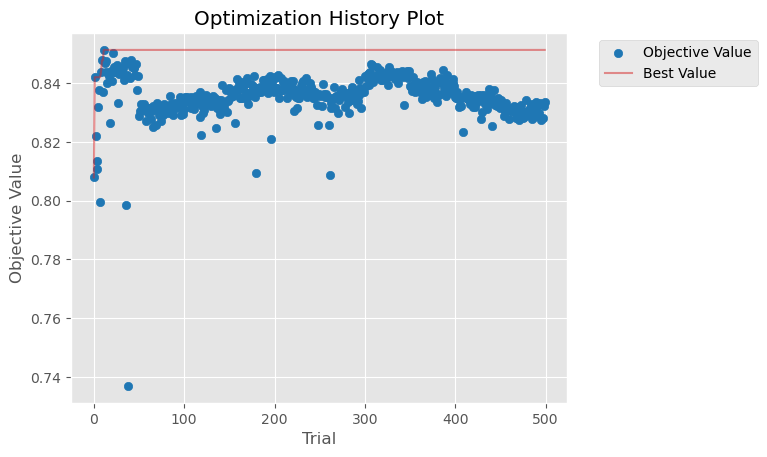

In [106]:
plot_optimization_history(study_xgb);

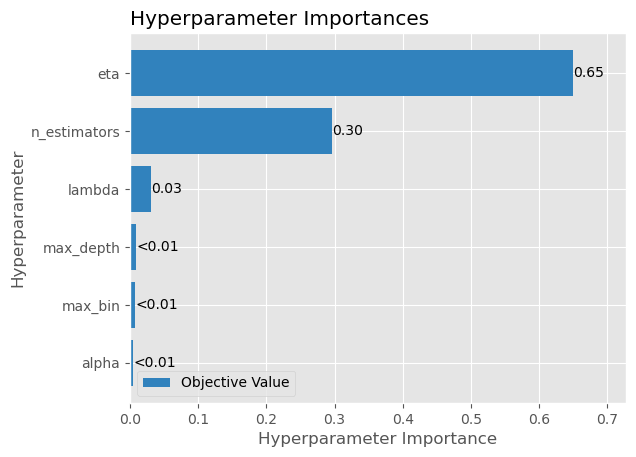

In [107]:
plot_param_importances(study_xgb);

In [108]:
detailed_objective_xgb_CV(study_xgb.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,TP,210.200000,8.482662
1,TN,179.800000,10.282672
2,FP,39.000000,5.944185
3,FN,30.200000,3.966527
4,Accuracy,0.849312,0.016548
5,Precision,0.843609,0.022347
6,Sensitivity,0.874529,0.014709
7,Specificity,0.821710,0.025943
8,F1 score,0.858643,0.015047
9,F1 score (weighted),0.849127,0.016662


In [109]:
mat_met_xgb_test['ave'] = mat_met_xgb_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_xgb_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave
0,TP,424.000000,421.000000,422.000000,449.000000,404.000000,416.000000,449.000000,418.000000,394.000000,418.000000,421.500000
1,TN,339.000000,364.000000,338.000000,322.000000,351.000000,363.000000,326.000000,349.000000,352.000000,375.000000,347.900000
2,FP,88.000000,71.000000,84.000000,82.000000,79.000000,72.000000,78.000000,81.000000,97.000000,75.000000,80.700000
3,FN,68.000000,63.000000,75.000000,66.000000,85.000000,68.000000,66.000000,71.000000,76.000000,51.000000,68.900000
4,Accuracy,0.830250,0.854189,0.826986,0.838955,0.821545,0.847661,0.843308,0.834603,0.811752,0.862894,0.837214
5,Precision,0.828125,0.855691,0.833992,0.845574,0.836439,0.852459,0.851992,0.837675,0.802444,0.847870,0.839226
6,Sensitivity,0.861789,0.869835,0.849095,0.871845,0.826176,0.859504,0.871845,0.854806,0.838298,0.891258,0.859445
7,Specificity,0.793900,0.836800,0.800900,0.797000,0.816300,0.834500,0.806900,0.811600,0.784000,0.833300,0.811520
8,F1 score,0.844622,0.862705,0.841476,0.858509,0.831276,0.855967,0.861804,0.846154,0.819979,0.869023,0.849151
9,F1 score (weighted),0.829906,0.854110,0.826830,0.838560,0.821613,0.847622,0.843029,0.834467,0.811555,0.862727,0.837042


In [110]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)


Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_xgb=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_xgb = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )


        #learn
        eval_set = [(X_test, y_test)]
        optimizedCV_xgb.fit(X_train,y_train, 
            eval_set=eval_set,
            eval_metric=["logloss"],
            early_stopping_rounds=50,
            verbose= False,
                  )
                          
                  
        #print(test_idx)
        y_pred_optimized_xgb = optimizedCV_xgb.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_xgb': y_pred_optimized_xgb } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        
        conf_matrix = confusion_matrix(y_test, y_pred_optimized_xgb)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        Accuracy_outer.append(accuracy_score(y_test, y_pred_optimized_xgb))
        Precision_outer.append(precision_score(y_test, y_pred_optimized_xgb))
        Sensitivity_outer.append(recall_score(y_test, y_pred_optimized_xgb))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test, y_pred_optimized_xgb))
        f1_scores_W_outer.append(f1_score(y_test, y_pred_optimized_xgb, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test, y_pred_optimized_xgb, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test, y_pred_optimized_xgb))
        MCC_outer.append(matthews_corrcoef(y_test, y_pred_optimized_xgb))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test, y_pred_optimized_xgb))
        
    data_xgb['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_xgb['y_test' + str(i)] = data_inner['y_test']
    data_xgb['y_pred_xgb' + str(i)] = data_inner['y_pred_xgb']
   # data_xgb['correct' + str(i)] = correct_value
   # data_xgb['pred' + str(i)] = y_pred_optimized_xgb

mat_met_optimized_xgb = pd.DataFrame({'Metric':['Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 

mat_met_optimized_xgb


,Metric,Value (average),Value (std)
0,Accuracy,0.848868,0.016375
1,Precision,0.842545,0.021326
2,Sensitivity,0.874879,0.021653
3,Specificity,0.820344,0.024352
4,F1 score,0.858195,0.016546
5,F1 score (weighted),0.848652,0.016409
6,F1 score (macro),0.848003,0.016434
7,Balanced Accuracy,0.847612,0.016508
8,MCC,0.697192,0.032881
9,NPV,0.856626,0.023207


In [111]:
#cross valide using this optimized XGBoost 
fit_params = {'early_stopping_rounds': 50, 
            'eval_set': [(X_tr, Y_tr), (X_te, Y_te)],
              'verbose' : False,
             }

xgb_baseline_CVscore = cross_val_score(xgb_clf, X, Y, cv=10, scoring="f1_macro", )
#cv_xgb_opt_testSet = cross_val_score(optimized_xgb, X, Y, cv=10, scoring="f1_macro", fit_params = fit_params)
cv_xgb_opt = cross_val_score(optimizedCV_xgb, X, Y, cv=10, scoring="f1_macro", fit_params = fit_params)
print("XGBoost baseline model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(xgb_baseline_CVscore), np.std(xgb_baseline_CVscore, ddof=1)))
#print("XGBoost optimized model (tested with Y_te) f1_score %0.4f with a standard deviation of %0.4f" % (cv_xgb_opt_testSet.mean(), cv_xgb_opt_testSet.std()))
print("XGBoost optimized model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_xgb_opt), np.std(cv_xgb_opt, ddof=1)))

[11:31:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:31:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:31:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:31:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [112]:
# save the modesls, both the one with optimized hyperparameters and the initial one
joblib.dump(xgb_clf, "OUTPUT/xgb_clf.joblib")

joblib.dump(optimizedCV_xgb, "OUTPUT/optimizedCV_xgb_clf.joblib")


['OUTPUT/optimizedCV_xgb_clf.joblib']

## KNeighbors (KNN)

In [113]:
%%time


TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    knn_clf = KNeighborsClassifier()
    
    knn_clf.fit(X_train,y_train)

    y_pred = knn_clf.predict(X_test) 
    
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test, y_pred)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test, y_pred)
    Precision[idx] = precision_score(y_test, y_pred)
    Sensitivity[idx] = recall_score(y_test, y_pred)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test, y_pred)
    f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
    f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
    MCC[idx] = matthews_corrcoef(y_test, y_pred)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    TP       200.400000     9.155448
1                    TN       174.200000    11.282238
2                    FP        44.600000     8.016649
3                    FN        40.000000     5.849976
4              Accuracy         0.815770     0.022631
5             Precision         0.818346     0.029347
6           Sensitivity         0.833753     0.021948
7           Specificity         0.796170     0.034913
8              F1 score         0.825697     0.020573
9   F1 score (weighted)         0.815655     0.022703
10     F1 score (macro)         0.814926     0.022673
11    Balanced Accuracy         0.814955     0.022707
12                  MCC         0.630628     0.045051
13                  NPV         0.812990     0.027535
14              ROC_AUC         0.814955     0.022707
CPU times: user 4.97 s, sys: 1.82 s, total: 6.79 s
Wall time: 614 ms


In [114]:
def objective_knn_CV(trial, X, Y, Y_class):
    param_grid = {
        "n_neighbors" : trial.suggest_int("n_neighbors", 5, 30),
        "weights" :trial.suggest_categorical("weights", ['uniform', 'distance']),
        "metric" : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        "leaf_size": trial.suggest_int("leaf_size", 20, 100)
        #"device_type": trial.suggestegorical("device_type", ['gpu']),
        
    }
    
   
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        knn_model = KNeighborsClassifier(**param_grid, n_jobs=16)
        knn_model.fit(X_train,y_train)
    
        y_pred = knn_model.predict(X_test)
    
    
        cv_scores[idx] = f1_score(y_test, y_pred, average='macro')
       
        
    return np.mean(cv_scores)

In [115]:
def detailed_objective_knn_CV(trial, X, Y, Y_class):
    param_grid = {
        "n_neighbors" : trial.suggest_int("n_neighbors", 1, 30),
        "weights" :trial.suggest_categorical("weights", ['uniform', 'distance']),
        "metric" : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        "leaf_size": trial.suggest_int("leaf_size", 20, 100)
        #"device_type": trial.suggestegorical("device_type", ['gpu']),      
    }
    
  
    TP =np.empty(10)
    TN = np.empty(10)
    FP = np.empty(10)
    FN = np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M = np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        knn_model = KNeighborsClassifier(**param_grid, n_jobs=16)
        knn_model.fit(X_train,y_train)
    
        y_pred = knn_model.predict(X_test)
        
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test, y_pred)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


    mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
    return(mat_met)
    

In [116]:
#Execute optuna and set hyperparameters
study_knn = optuna.create_study(direction='maximize', study_name="KNNClassifier")
func_knn_0 = lambda trial: objective_knn_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_knn.optimize(func_knn_0, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 11:31:50,083] A new study created in memory with name: KNNClassifier
[I 2023-12-04 11:31:50,810] Trial 0 finished with value: 0.7883422062423799 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 59}. Best is trial 0 with value: 0.7883422062423799.
[I 2023-12-04 11:31:50,939] Trial 1 finished with value: 0.7964452795481077 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 75}. Best is trial 1 with value: 0.7964452795481077.
[I 2023-12-04 11:31:51,057] Trial 2 finished with value: 0.8134380644653781 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 66}. Best is trial 2 with value: 0.8134380644653781.
[I 2023-12-04 11:31:51,188] Trial 3 finished with value: 0.7945571344027503 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 20}. Best is trial 2 with value: 0.8134380644653781.
[I 2023-12-04 11:31:51,

	Number of trials: 50.0
	Best value (f1_score): 0.8173
	Best params:
		n_neighbors: 8
		weights: distance
		metric: minkowski
		leaf_size: 68


In [117]:
#Create an instance with tuned hyperparameters

optimized_knn_0 = KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_0.fit(X_trainSet0,Y_trainSet0, )

# predict
y_pred_knn_0 = optimized_knn_0.predict(X_testSet0)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0, y_pred_knn_0)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0, y_pred_knn_0)
Precision = precision_score(Y_testSet0, y_pred_knn_0)
Sensitivity = recall_score(Y_testSet0, y_pred_knn_0)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0, y_pred_knn_0)      
f1_scores_W = f1_score(Y_testSet0, y_pred_knn_0, average="weighted")
f1_scores_M = f1_score(Y_testSet0, y_pred_knn_0, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0, y_pred_knn_0)
MCC = matthews_corrcoef(Y_testSet0, y_pred_knn_0)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0, y_pred_knn_0)
    

mat_met_knn_test = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_knn_test)


                 Metric        Set0
0                    TP  406.000000
1                    TN  341.000000
2                    FP   86.000000
3                    FN   86.000000
4              Accuracy    0.812840
5             Precision    0.825203
6           Sensitivity    0.825203
7           Specificity    0.798600
8              F1 score    0.825203
9   F1 score (weighted)    0.812840
10     F1 score (macro)    0.811899
11    Balanced Accuracy    0.811899
12                  MCC    0.623798
13                  NPV    0.798600
14              ROC_AUC    0.811899


In [118]:
#Execute optuna and set hyperparameters

func_knn_1 = lambda trial: objective_knn_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_knn.optimize(func_knn_1, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 11:32:04,268] Trial 50 finished with value: 0.7992499926131635 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 75}. Best is trial 39 with value: 0.8172828040339469.
[I 2023-12-04 11:32:04,422] Trial 51 finished with value: 0.8043319501618618 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 77}. Best is trial 39 with value: 0.8172828040339469.
[I 2023-12-04 11:32:04,574] Trial 52 finished with value: 0.8043319501618618 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 90}. Best is trial 39 with value: 0.8172828040339469.
[I 2023-12-04 11:32:04,738] Trial 53 finished with value: 0.7765297989218899 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 79}. Best is trial 39 with value: 0.8172828040339469.
[I 2023-12-04 11:32:04,896] Trial 54 finished with value: 0.7945458273745797 and parameters: {'n_n

	Number of trials: 100.0
	Best value (f1_score): 0.8173
	Best params:
		n_neighbors: 8
		weights: distance
		metric: minkowski
		leaf_size: 68


In [119]:
#Create an instance with tuned hyperparameters

optimized_knn_1 =  KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_1.fit(X_trainSet1,Y_trainSet1, )

# predict
y_pred_knn_1 = optimized_knn_1.predict(X_testSet1)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1, y_pred_knn_1)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1, y_pred_knn_1)
Precision = precision_score(Y_testSet1, y_pred_knn_1)
Sensitivity = recall_score(Y_testSet1, y_pred_knn_1)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1, y_pred_knn_1)      
f1_scores_W = f1_score(Y_testSet1, y_pred_knn_1, average="weighted")
f1_scores_M = f1_score(Y_testSet1, y_pred_knn_1, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1, y_pred_knn_1)
MCC = matthews_corrcoef(Y_testSet1, y_pred_knn_1)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1, y_pred_knn_1)
    

set1 = pd.DataFrame({'Set1':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set1'] = set1
print(mat_met_knn_test)


                 Metric        Set0        Set1
0                    TP  406.000000  403.000000
1                    TN  341.000000  352.000000
2                    FP   86.000000   83.000000
3                    FN   86.000000   81.000000
4              Accuracy    0.812840    0.821545
5             Precision    0.825203    0.829218
6           Sensitivity    0.825203    0.832645
7           Specificity    0.798600    0.809200
8              F1 score    0.825203    0.830928
9   F1 score (weighted)    0.812840    0.821524
10     F1 score (macro)    0.811899    0.820994
11    Balanced Accuracy    0.811899    0.820920
12                  MCC    0.623798    0.641996
13                  NPV    0.798600    0.812900
14              ROC_AUC    0.811899    0.820920


In [120]:
#Execute optuna and set hyperparameters

func_knn_2 = lambda trial: objective_knn_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_knn.optimize(func_knn_2, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 11:32:16,203] Trial 100 finished with value: 0.8121682832385856 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 40}. Best is trial 39 with value: 0.8172828040339469.
[I 2023-12-04 11:32:16,515] Trial 101 finished with value: 0.8110826217225547 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 43}. Best is trial 39 with value: 0.8172828040339469.
[I 2023-12-04 11:32:16,788] Trial 102 finished with value: 0.797618732396495 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 36}. Best is trial 39 with value: 0.8172828040339469.
[I 2023-12-04 11:32:17,032] Trial 103 finished with value: 0.797618732396495 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 41}. Best is trial 39 with value: 0.8172828040339469.
[I 2023-12-04 11:32:17,326] Trial 104 finished with value: 0.8110826217225547 and parameters: {'n_nei

	Number of trials: 150.0
	Best value (f1_score): 0.8201
	Best params:
		n_neighbors: 5
		weights: distance
		metric: euclidean
		leaf_size: 84


In [121]:
#Create an instance with tuned hyperparameters

optimized_knn_2 = KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_2.fit(X_trainSet2,Y_trainSet2, )
#predict
y_pred_knn_2 = optimized_knn_2.predict(X_testSet2)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2, y_pred_knn_2)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2, y_pred_knn_2)
Precision = precision_score(Y_testSet2, y_pred_knn_2)
Sensitivity = recall_score(Y_testSet2, y_pred_knn_2)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2, y_pred_knn_2)      
f1_scores_W = f1_score(Y_testSet2, y_pred_knn_2, average="weighted")
f1_scores_M = f1_score(Y_testSet2, y_pred_knn_2, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2, y_pred_knn_2)
MCC = matthews_corrcoef(Y_testSet2, y_pred_knn_2)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2, y_pred_knn_2)
    

Set2 = pd.DataFrame({'Set2':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set2'] = Set2
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2
0                    TP  406.000000  403.000000  415.000000
1                    TN  341.000000  352.000000  333.000000
2                    FP   86.000000   83.000000   89.000000
3                    FN   86.000000   81.000000   82.000000
4              Accuracy    0.812840    0.821545    0.813928
5             Precision    0.825203    0.829218    0.823413
6           Sensitivity    0.825203    0.832645    0.835010
7           Specificity    0.798600    0.809200    0.789100
8              F1 score    0.825203    0.830928    0.829171
9   F1 score (weighted)    0.812840    0.821524    0.813801
10     F1 score (macro)    0.811899    0.820994    0.812435
11    Balanced Accuracy    0.811899    0.820920    0.812055
12                  MCC    0.623798    0.641996    0.624965
13                  NPV    0.798600    0.812900    0.802400
14              ROC_AUC    0.811899    0.820920    0.812055


In [122]:
#Execute optuna and set hyperparameters

func_knn_3 = lambda trial: objective_knn_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_knn.optimize(func_knn_3, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 11:32:27,871] Trial 150 finished with value: 0.8128436833632282 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 96}. Best is trial 118 with value: 0.8200738378520033.
[I 2023-12-04 11:32:28,041] Trial 151 finished with value: 0.8128436833632282 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 98}. Best is trial 118 with value: 0.8200738378520033.
[I 2023-12-04 11:32:28,196] Trial 152 finished with value: 0.8206156842155841 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 100}. Best is trial 152 with value: 0.8206156842155841.
[I 2023-12-04 11:32:28,351] Trial 153 finished with value: 0.8206156842155841 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 99}. Best is trial 152 with value: 0.8206156842155841.
[I 2023-12-04 11:32:28,505] Trial 154 finished with value: 0.8206156842155841 and parameter

	Number of trials: 200.0
	Best value (f1_score): 0.8206
	Best params:
		n_neighbors: 6
		weights: distance
		metric: euclidean
		leaf_size: 100


In [123]:
#Create an instance with tuned hyperparameters

optimized_knn_3 = KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_3.fit(X_trainSet3,Y_trainSet3, )

# predict
y_pred_knn_3 = optimized_knn_3.predict(X_testSet3)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3, y_pred_knn_3)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3, y_pred_knn_3)
Precision = precision_score(Y_testSet3, y_pred_knn_3)
Sensitivity = recall_score(Y_testSet3, y_pred_knn_3)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3, y_pred_knn_3)      
f1_scores_W = f1_score(Y_testSet3, y_pred_knn_3, average="weighted")
f1_scores_M = f1_score(Y_testSet3, y_pred_knn_3, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3, y_pred_knn_3)
MCC = matthews_corrcoef(Y_testSet3, y_pred_knn_3)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3, y_pred_knn_3)
    

Set3 = pd.DataFrame({'Set3':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set3'] = Set3
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3
0                    TP  406.000000  403.000000  415.000000  432.000000
1                    TN  341.000000  352.000000  333.000000  326.000000
2                    FP   86.000000   83.000000   89.000000   78.000000
3                    FN   86.000000   81.000000   82.000000   83.000000
4              Accuracy    0.812840    0.821545    0.813928    0.824810
5             Precision    0.825203    0.829218    0.823413    0.847059
6           Sensitivity    0.825203    0.832645    0.835010    0.838835
7           Specificity    0.798600    0.809200    0.789100    0.806900
8              F1 score    0.825203    0.830928    0.829171    0.842927
9   F1 score (weighted)    0.812840    0.821524    0.813801    0.824921
10     F1 score (macro)    0.811899    0.820994    0.812435    0.822447
11    Balanced Accuracy    0.811899    0.820920    0.812055    0.822883
12                  MCC    0.623798    0.641996    0.624965    0

In [124]:
#Execute optuna and set hyperparameters

func_knn_4 = lambda trial: objective_knn_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_knn.optimize(func_knn_4, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 11:32:35,871] Trial 200 finished with value: 0.7926805586447515 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 97}. Best is trial 152 with value: 0.8206156842155841.
[I 2023-12-04 11:32:36,001] Trial 201 finished with value: 0.8195857730281404 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 100}. Best is trial 152 with value: 0.8206156842155841.
[I 2023-12-04 11:32:36,162] Trial 202 finished with value: 0.8195857730281404 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 100}. Best is trial 152 with value: 0.8206156842155841.
[I 2023-12-04 11:32:36,314] Trial 203 finished with value: 0.8195857730281404 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 99}. Best is trial 152 with value: 0.8206156842155841.
[I 2023-12-04 11:32:36,483] Trial 204 finished with value: 0.7836206845997948 and paramet

	Number of trials: 250.0
	Best value (f1_score): 0.8206
	Best params:
		n_neighbors: 6
		weights: distance
		metric: euclidean
		leaf_size: 100


In [125]:
#Create an instance with tuned hyperparameters

optimized_knn_4 =  KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_4.fit(X_trainSet4,Y_trainSet4, )

# predict
y_pred_knn_4 = optimized_knn_4.predict(X_testSet4)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4, y_pred_knn_4)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4, y_pred_knn_4)
Precision = precision_score(Y_testSet4, y_pred_knn_4)
Sensitivity = recall_score(Y_testSet4, y_pred_knn_4)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4, y_pred_knn_4)      
f1_scores_W = f1_score(Y_testSet4, y_pred_knn_4, average="weighted")
f1_scores_M = f1_score(Y_testSet4, y_pred_knn_4, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4, y_pred_knn_4)
MCC = matthews_corrcoef(Y_testSet4, y_pred_knn_4)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4, y_pred_knn_4)
    

Set4 = pd.DataFrame({'Set4':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set4'] = Set4
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  406.000000  403.000000  415.000000  432.000000   
1                    TN  341.000000  352.000000  333.000000  326.000000   
2                    FP   86.000000   83.000000   89.000000   78.000000   
3                    FN   86.000000   81.000000   82.000000   83.000000   
4              Accuracy    0.812840    0.821545    0.813928    0.824810   
5             Precision    0.825203    0.829218    0.823413    0.847059   
6           Sensitivity    0.825203    0.832645    0.835010    0.838835   
7           Specificity    0.798600    0.809200    0.789100    0.806900   
8              F1 score    0.825203    0.830928    0.829171    0.842927   
9   F1 score (weighted)    0.812840    0.821524    0.813801    0.824921   
10     F1 score (macro)    0.811899    0.820994    0.812435    0.822447   
11    Balanced Accuracy    0.811899    0.820920    0.812055    0.822883   
12                  MCC  

In [126]:
#Execute optuna and set hyperparameters

func_knn_5 = lambda trial: objective_knn_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_knn.optimize(func_knn_5, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 11:32:44,102] Trial 250 finished with value: 0.8039455342153502 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 100}. Best is trial 152 with value: 0.8206156842155841.
[I 2023-12-04 11:32:44,258] Trial 251 finished with value: 0.8147861668129532 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 98}. Best is trial 152 with value: 0.8206156842155841.
[I 2023-12-04 11:32:44,404] Trial 252 finished with value: 0.8104240317052966 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 100}. Best is trial 152 with value: 0.8206156842155841.
[I 2023-12-04 11:32:44,558] Trial 253 finished with value: 0.8147861668129532 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 97}. Best is trial 152 with value: 0.8206156842155841.
[I 2023-12-04 11:32:44,720] Trial 254 finished with value: 0.8104240317052966 and paramete

	Number of trials: 300.0
	Best value (f1_score): 0.8206
	Best params:
		n_neighbors: 6
		weights: distance
		metric: euclidean
		leaf_size: 100


In [127]:
#Create an instance with tuned hyperparameters

optimized_knn_5 = KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_5.fit(X_trainSet5,Y_trainSet5, )

# predict
y_pred_knn_5 = optimized_knn_5.predict(X_testSet5)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5, y_pred_knn_5)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5, y_pred_knn_5)
Precision = precision_score(Y_testSet5, y_pred_knn_5)
Sensitivity = recall_score(Y_testSet5, y_pred_knn_5)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5, y_pred_knn_5)      
f1_scores_W = f1_score(Y_testSet5, y_pred_knn_5, average="weighted")
f1_scores_M = f1_score(Y_testSet5, y_pred_knn_5, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5, y_pred_knn_5)
MCC = matthews_corrcoef(Y_testSet5, y_pred_knn_5)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5, y_pred_knn_5)
    

Set5 = pd.DataFrame({'Set5':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set5'] = Set5
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  406.000000  403.000000  415.000000  432.000000   
1                    TN  341.000000  352.000000  333.000000  326.000000   
2                    FP   86.000000   83.000000   89.000000   78.000000   
3                    FN   86.000000   81.000000   82.000000   83.000000   
4              Accuracy    0.812840    0.821545    0.813928    0.824810   
5             Precision    0.825203    0.829218    0.823413    0.847059   
6           Sensitivity    0.825203    0.832645    0.835010    0.838835   
7           Specificity    0.798600    0.809200    0.789100    0.806900   
8              F1 score    0.825203    0.830928    0.829171    0.842927   
9   F1 score (weighted)    0.812840    0.821524    0.813801    0.824921   
10     F1 score (macro)    0.811899    0.820994    0.812435    0.822447   
11    Balanced Accuracy    0.811899    0.820920    0.812055    0.822883   
12                  MCC  

In [128]:
#Execute optuna and set hyperparameters

func_knn_6 = lambda trial: objective_knn_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_knn.optimize(func_knn_6, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 11:32:53,208] Trial 300 finished with value: 0.8157419979709128 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 100}. Best is trial 152 with value: 0.8206156842155841.
[I 2023-12-04 11:32:53,366] Trial 301 finished with value: 0.8205462631421276 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 97}. Best is trial 152 with value: 0.8206156842155841.
[I 2023-12-04 11:32:53,528] Trial 302 finished with value: 0.8193741396166171 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 98}. Best is trial 152 with value: 0.8206156842155841.
[I 2023-12-04 11:32:53,701] Trial 303 finished with value: 0.7850215541675081 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 100}. Best is trial 152 with value: 0.8206156842155841.
[I 2023-12-04 11:32:53,864] Trial 304 finished with value: 0.8193741396166171 and paramet

	Number of trials: 350.0
	Best value (f1_score): 0.8218
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 94


In [129]:
#Create an instance with tuned hyperparameters

optimized_knn_6 =  KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_6.fit(X_trainSet6,Y_trainSet6, )

# predict
y_pred_knn_6 = optimized_knn_6.predict(X_testSet6)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6, y_pred_knn_6)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6, y_pred_knn_6)
Precision = precision_score(Y_testSet6, y_pred_knn_6)
Sensitivity = recall_score(Y_testSet6, y_pred_knn_6)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6, y_pred_knn_6)      
f1_scores_W = f1_score(Y_testSet6, y_pred_knn_6, average="weighted")
f1_scores_M = f1_score(Y_testSet6, y_pred_knn_6, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6, y_pred_knn_6)
MCC = matthews_corrcoef(Y_testSet6, y_pred_knn_6)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6, y_pred_knn_6)
    

Set6 = pd.DataFrame({'Set6':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set6'] = Set6
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  406.000000  403.000000  415.000000  432.000000   
1                    TN  341.000000  352.000000  333.000000  326.000000   
2                    FP   86.000000   83.000000   89.000000   78.000000   
3                    FN   86.000000   81.000000   82.000000   83.000000   
4              Accuracy    0.812840    0.821545    0.813928    0.824810   
5             Precision    0.825203    0.829218    0.823413    0.847059   
6           Sensitivity    0.825203    0.832645    0.835010    0.838835   
7           Specificity    0.798600    0.809200    0.789100    0.806900   
8              F1 score    0.825203    0.830928    0.829171    0.842927   
9   F1 score (weighted)    0.812840    0.821524    0.813801    0.824921   
10     F1 score (macro)    0.811899    0.820994    0.812435    0.822447   
11    Balanced Accuracy    0.811899    0.820920    0.812055    0.822883   
12                  MCC  

In [130]:
#Execute optuna and set hyperparameters

func_knn_7 = lambda trial: objective_knn_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_knn.optimize(func_knn_7, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 11:33:25,964] Trial 350 finished with value: 0.826424049487634 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 90}. Best is trial 350 with value: 0.826424049487634.
[I 2023-12-04 11:33:26,653] Trial 351 finished with value: 0.826424049487634 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 91}. Best is trial 350 with value: 0.826424049487634.
[I 2023-12-04 11:33:27,343] Trial 352 finished with value: 0.826424049487634 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 92}. Best is trial 350 with value: 0.826424049487634.
[I 2023-12-04 11:33:28,033] Trial 353 finished with value: 0.826424049487634 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 92}. Best is trial 350 with value: 0.826424049487634.
[I 2023-12-04 11:33:28,723] Trial 354 finished with value: 0.826424049487634 and parameters: {'n_nei

	Number of trials: 400.0
	Best value (f1_score): 0.8264
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 90


In [131]:
#Create an instance with tuned hyperparameters

optimized_knn_7 =  KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_7.fit(X_trainSet7,Y_trainSet7, )

# predict
y_pred_knn_7 = optimized_knn_7.predict(X_testSet7)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7, y_pred_knn_7)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7, y_pred_knn_7)
Precision = precision_score(Y_testSet7, y_pred_knn_7)
Sensitivity = recall_score(Y_testSet7, y_pred_knn_7)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7, y_pred_knn_7)      
f1_scores_W = f1_score(Y_testSet7, y_pred_knn_7, average="weighted")
f1_scores_M = f1_score(Y_testSet7, y_pred_knn_7, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7, y_pred_knn_7)
MCC = matthews_corrcoef(Y_testSet7, y_pred_knn_7)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7, y_pred_knn_7)
    

Set7 = pd.DataFrame({'Set7':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set7'] = Set7
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  406.000000  403.000000  415.000000  432.000000   
1                    TN  341.000000  352.000000  333.000000  326.000000   
2                    FP   86.000000   83.000000   89.000000   78.000000   
3                    FN   86.000000   81.000000   82.000000   83.000000   
4              Accuracy    0.812840    0.821545    0.813928    0.824810   
5             Precision    0.825203    0.829218    0.823413    0.847059   
6           Sensitivity    0.825203    0.832645    0.835010    0.838835   
7           Specificity    0.798600    0.809200    0.789100    0.806900   
8              F1 score    0.825203    0.830928    0.829171    0.842927   
9   F1 score (weighted)    0.812840    0.821524    0.813801    0.824921   
10     F1 score (macro)    0.811899    0.820994    0.812435    0.822447   
11    Balanced Accuracy    0.811899    0.820920    0.812055    0.822883   
12                  MCC  

In [132]:
#Execute optuna and set hyperparameters

func_knn_8 = lambda trial: objective_knn_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_knn.optimize(func_knn_8, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 11:34:00,936] Trial 400 finished with value: 0.8167923849810611 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 93}. Best is trial 350 with value: 0.826424049487634.
[I 2023-12-04 11:34:01,643] Trial 401 finished with value: 0.8167923849810611 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 91}. Best is trial 350 with value: 0.826424049487634.
[I 2023-12-04 11:34:02,385] Trial 402 finished with value: 0.803562171289753 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 94}. Best is trial 350 with value: 0.826424049487634.
[I 2023-12-04 11:34:03,087] Trial 403 finished with value: 0.8167923849810611 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 90}. Best is trial 350 with value: 0.826424049487634.
[I 2023-12-04 11:34:03,787] Trial 404 finished with value: 0.8167923849810611 and parameters: {'n_

	Number of trials: 450.0
	Best value (f1_score): 0.8264
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 90


In [133]:
#Create an instance with tuned hyperparameters

optimized_knn_8 =  KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_8.fit(X_trainSet8,Y_trainSet8, )

# predict
y_pred_knn_8 = optimized_knn_8.predict(X_testSet8)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8, y_pred_knn_8)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8, y_pred_knn_8)
Precision = precision_score(Y_testSet8, y_pred_knn_8)
Sensitivity = recall_score(Y_testSet8, y_pred_knn_8)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8, y_pred_knn_8)      
f1_scores_W = f1_score(Y_testSet8, y_pred_knn_8, average="weighted")
f1_scores_M = f1_score(Y_testSet8, y_pred_knn_8, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8, y_pred_knn_8)
MCC = matthews_corrcoef(Y_testSet8, y_pred_knn_8)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8, y_pred_knn_8)
    

Set8 = pd.DataFrame({'Set8':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set8'] = Set8
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  406.000000  403.000000  415.000000  432.000000   
1                    TN  341.000000  352.000000  333.000000  326.000000   
2                    FP   86.000000   83.000000   89.000000   78.000000   
3                    FN   86.000000   81.000000   82.000000   83.000000   
4              Accuracy    0.812840    0.821545    0.813928    0.824810   
5             Precision    0.825203    0.829218    0.823413    0.847059   
6           Sensitivity    0.825203    0.832645    0.835010    0.838835   
7           Specificity    0.798600    0.809200    0.789100    0.806900   
8              F1 score    0.825203    0.830928    0.829171    0.842927   
9   F1 score (weighted)    0.812840    0.821524    0.813801    0.824921   
10     F1 score (macro)    0.811899    0.820994    0.812435    0.822447   
11    Balanced Accuracy    0.811899    0.820920    0.812055    0.822883   
12                  MCC  

In [134]:
#Execute optuna and set hyperparameters

func_knn_9 = lambda trial: objective_knn_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_knn.optimize(func_knn_9, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 11:34:36,427] Trial 450 finished with value: 0.8103711005393921 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 95}. Best is trial 350 with value: 0.826424049487634.
[I 2023-12-04 11:34:37,128] Trial 451 finished with value: 0.8112154653893351 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 90}. Best is trial 350 with value: 0.826424049487634.
[I 2023-12-04 11:34:37,828] Trial 452 finished with value: 0.8112154653893351 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 93}. Best is trial 350 with value: 0.826424049487634.
[I 2023-12-04 11:34:38,538] Trial 453 finished with value: 0.8103711005393921 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 92}. Best is trial 350 with value: 0.826424049487634.
[I 2023-12-04 11:34:39,247] Trial 454 finished with value: 0.8112154653893351 and parameters: {'

	Number of trials: 500.0
	Best value (f1_score): 0.8264
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 90


In [135]:
#Create an instance with tuned hyperparameters

optimized_knn_9 = KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_9.fit(X_trainSet9,Y_trainSet9, )

# predict
y_pred_knn_9 = optimized_knn_9.predict(X_testSet9)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9, y_pred_knn_9)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9, y_pred_knn_9)
Precision = precision_score(Y_testSet9, y_pred_knn_9)
Sensitivity = recall_score(Y_testSet9, y_pred_knn_9)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9, y_pred_knn_9)      
f1_scores_W = f1_score(Y_testSet9, y_pred_knn_9, average="weighted")
f1_scores_M = f1_score(Y_testSet9, y_pred_knn_9, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9, y_pred_knn_9)
MCC = matthews_corrcoef(Y_testSet9, y_pred_knn_9)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9, y_pred_knn_9)
    

Set9 = pd.DataFrame({'Set9':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set9'] = Set9
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  406.000000  403.000000  415.000000  432.000000   
1                    TN  341.000000  352.000000  333.000000  326.000000   
2                    FP   86.000000   83.000000   89.000000   78.000000   
3                    FN   86.000000   81.000000   82.000000   83.000000   
4              Accuracy    0.812840    0.821545    0.813928    0.824810   
5             Precision    0.825203    0.829218    0.823413    0.847059   
6           Sensitivity    0.825203    0.832645    0.835010    0.838835   
7           Specificity    0.798600    0.809200    0.789100    0.806900   
8              F1 score    0.825203    0.830928    0.829171    0.842927   
9   F1 score (weighted)    0.812840    0.821524    0.813801    0.824921   
10     F1 score (macro)    0.811899    0.820994    0.812435    0.822447   
11    Balanced Accuracy    0.811899    0.820920    0.812055    0.822883   
12                  MCC  

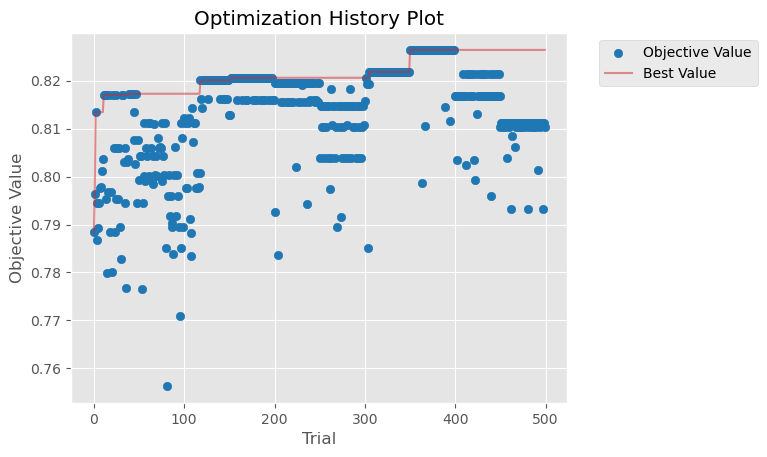

In [136]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_knn);

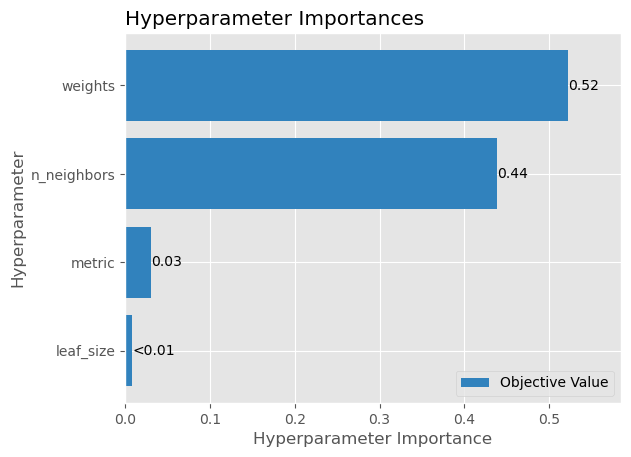

In [137]:

plot_param_importances(study_knn);

In [138]:
detailed_objective_knn_CV(study_knn.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,TP,202.200000,8.256984
1,TN,175.300000,10.832564
2,FP,43.500000,7.633988
3,FN,38.200000,5.202563
4,Accuracy,0.822089,0.019463
5,Precision,0.823362,0.027589
6,Sensitivity,0.841320,0.018998
7,Specificity,0.801230,0.032615
8,F1 score,0.831956,0.017398
9,F1 score (weighted),0.821965,0.019559


In [139]:
mat_met_knn_test['ave'] = mat_met_knn_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_knn_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave
0,TP,406.000000,403.000000,415.000000,432.000000,390.000000,397.000000,431.000000,419.000000,383.000000,406.000000,408.200000
1,TN,341.000000,352.000000,333.000000,326.000000,357.000000,351.000000,322.000000,346.000000,346.000000,368.000000,344.200000
2,FP,86.000000,83.000000,89.000000,78.000000,73.000000,84.000000,82.000000,84.000000,103.000000,82.000000,84.400000
3,FN,86.000000,81.000000,82.000000,83.000000,99.000000,87.000000,84.000000,70.000000,87.000000,63.000000,82.200000
4,Accuracy,0.812840,0.821545,0.813928,0.824810,0.812840,0.813928,0.819369,0.832427,0.793254,0.842220,0.818716
5,Precision,0.825203,0.829218,0.823413,0.847059,0.842333,0.825364,0.840156,0.833002,0.788066,0.831967,0.828578
6,Sensitivity,0.825203,0.832645,0.835010,0.838835,0.797546,0.820248,0.836893,0.856851,0.814894,0.865672,0.832380
7,Specificity,0.798600,0.809200,0.789100,0.806900,0.830200,0.806900,0.797000,0.804700,0.770600,0.817800,0.803100
8,F1 score,0.825203,0.830928,0.829171,0.842927,0.819328,0.822798,0.838521,0.844758,0.801255,0.848485,0.830337
9,F1 score (weighted),0.812840,0.821524,0.813801,0.824921,0.813030,0.813959,0.819416,0.832222,0.793108,0.842085,0.818691


In [140]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)


Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_knn=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_knn = KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )


        #learn
        
        optimizedCV_knn.fit(X_train,y_train)
                          
                  
        #print(test_idx)
        y_pred_optimized_knn = optimizedCV_knn.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_knn': y_pred_optimized_knn } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        
        conf_matrix = confusion_matrix(y_test, y_pred_optimized_knn)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        Accuracy_outer.append(accuracy_score(y_test, y_pred_optimized_knn))
        Precision_outer.append(precision_score(y_test, y_pred_optimized_knn))
        Sensitivity_outer.append(recall_score(y_test, y_pred_optimized_knn))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test, y_pred_optimized_knn))
        f1_scores_W_outer.append(f1_score(y_test, y_pred_optimized_knn, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test, y_pred_optimized_knn, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test, y_pred_optimized_knn))
        MCC_outer.append(matthews_corrcoef(y_test, y_pred_optimized_knn))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test, y_pred_optimized_knn))
        
    data_knn['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_knn['y_test' + str(i)] = data_inner['y_test']
    data_knn['y_pred_knn' + str(i)] = data_inner['y_pred_knn']
   # data_knn['correct' + str(i)] = correct_value
   # data_knn['pred' + str(i)] = y_pred_optimized_knn

mat_met_optimized_knn = pd.DataFrame({'Metric':['Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [ np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 

mat_met_optimized_knn


,Metric,Value (average),Value (std)
0,Accuracy,0.826613,0.020595
1,Precision,0.824938,0.026495
2,Sensitivity,0.849186,0.023316
3,Specificity,0.802014,0.029996
4,F1 score,0.836635,0.020220
5,F1 score (weighted),0.826435,0.020668
6,F1 score (macro),0.825748,0.020705
7,Balanced Accuracy,0.825596,0.020805
8,MCC,0.652464,0.041309
9,NPV,0.828804,0.025823


In [141]:
#cross valide using this optimized KNN 
knn_baseline_CVscore = cross_val_score(knn_clf, X, Y, cv=10, scoring="f1_macro")
#cv_knn_opt_testSet = cross_val_score(optimized_knn, X, Y, cv=10, scoring="f1_macro")
cv_knn_opt = cross_val_score(optimizedCV_knn, X, Y, cv=10, scoring="f1_macro")
print("KNN baseline model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(knn_baseline_CVscore), np.std(knn_baseline_CVscore, ddof=1)))
#print("KNN optimized model (tested on Y_te) f1_score %0.4f with a standard deviation of %0.4f" % (cv_knn_opt_testSet.mean(), cv_knn_opt_testSet.std()))
print("KNN optimized model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_knn_opt), np.std(cv_knn_opt, ddof=1)))

KNN baseline model f1_score 0.8066 with a standard deviation of 0.0176
KNN optimized model f1_score 0.8132 with a standard deviation of 0.0157


In [142]:
# save the modesls, both the one with optimized hyperparameters and the initial one
joblib.dump(knn_clf, "OUTPUT/knn_clf.joblib")
joblib.dump(optimizedCV_knn, "OUTPUT/optimizedCV_knn_clf.joblib")


['OUTPUT/optimizedCV_knn_clf.joblib']

## Support Vector 

In [143]:
%%time


TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    svm_clf = SVC()
    
    svm_clf.fit(X_train, y_train, )

    y_pred = svm_clf.predict(X_test) 
   
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test, y_pred)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test, y_pred)
    Precision[idx] = precision_score(y_test, y_pred)
    Sensitivity[idx] = recall_score(y_test, y_pred)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test, y_pred)
    f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
    f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
    MCC[idx] = matthews_corrcoef(y_test, y_pred)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       }) 
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    TP       210.300000    10.583530
1                    TN       170.000000     9.165151
2                    FP        48.800000     6.321041
3                    FN        30.100000     4.840799
4              Accuracy         0.828186     0.015372
5             Precision         0.811652     0.022795
6           Sensitivity         0.874698     0.019862
7           Specificity         0.777070     0.025271
8              F1 score         0.841762     0.016029
9   F1 score (weighted)         0.827555     0.015451
10     F1 score (macro)         0.826630     0.015060
11    Balanced Accuracy         0.825888     0.014532
12                  MCC         0.656586     0.029139
13                  NPV         0.849780     0.020790
14              ROC_AUC         0.825888     0.014532
CPU times: user 22.5 s, sys: 52 ms, total: 22.5 s
Wall time: 22.5 s


In [144]:
def objective_svm_CV(trial, X, Y, Y_class):
    param_grid = {
        "C" : trial.suggest_categorical("C", [np.exp2(-7), np.exp2(-6), np.exp2(-5), np.exp2(-4), np.exp2(-3), np.exp2(-2),
                                              np.exp2(-1), np.exp2(0), np.exp2(1), np.exp2(2), np.exp2(3), np.exp2(4),
                                             np.exp2(5), np.exp2(6), np.exp2(7)]),
        "gamma" :trial.suggest_categorical("gamma", [np.exp2(-15), np.exp2(-14), np.exp2(-13), np.exp2(-12), np.exp2(-11), 
                                                     np.exp2(-10),np.exp2(-9), np.exp2(-8), np.exp2(-7), np.exp2(-6), np.exp2(-5), 
                                                     np.exp2(-4),np.exp2(-3), np.exp2(-2), np.exp2(-1), np.exp2(0), np.exp2(1),
                                                     np.exp2(2), np.exp2(3)]),
        #"kernel" : trial.suggestegorical("kernel", ['linear', 'rbf', 'sigmoid']),
        #"degree": trial.suggest_int("degree", 3, 10)
        #"device_type": trial.suggestegorical("device_type", ['gpu'])
        
    }
    
    
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        svm_model = SVC(**param_grid)
        svm_model.fit(X_train,y_train)
    
        y_pred = svm_model.predict(X_test)
    
    
        cv_scores[idx] = f1_score(y_test, y_pred, average='macro')
       
        
    return np.mean(cv_scores)


In [145]:
def detailed_objective_svm_cv(trial, X, Y, Y_class):
    param_grid = {
        "C" : trial.suggest_categorical("C", [np.exp2(-7), np.exp2(-6), np.exp2(-5), np.exp2(-4), np.exp2(-3), np.exp2(-2),
                                              np.exp2(-1), np.exp2(0), np.exp2(1), np.exp2(2), np.exp2(3), np.exp2(4),
                                             np.exp2(5), np.exp2(6), np.exp2(7)]),
        "gamma" :trial.suggest_categorical("gamma", [np.exp2(-15), np.exp2(-14), np.exp2(-13), np.exp2(-12), np.exp2(-11), 
                                                     np.exp2(-10),np.exp2(-9), np.exp2(-8), np.exp2(-7), np.exp2(-6), np.exp2(-5), 
                                                     np.exp2(-4),np.exp2(-3), np.exp2(-2), np.exp2(-1), np.exp2(0), np.exp2(1),
                                                     np.exp2(2), np.exp2(3)]),
        #"kernel" : trial.suggestegorical("kernel", ['linear', 'rbf', 'sigmoid']),
        #"degree": trial.suggest_int("degree", 3, 10)
        #"device_type": trial.suggestegorical("device_type", ['gpu']),
        
    }
    
  
    TP =np.empty(10)
    TN = np.empty(10)
    FP = np.empty(10)
    FN = np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M = np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)

    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        svm_model = SVC(**param_grid)
        svm_model.fit(X_train,y_train)
    
        y_pred = svm_model.predict(X_test)
        
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test, y_pred)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


    mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
    return(mat_met)
   

In [146]:
#Execute optuna and set hyperparameters
study_svm = optuna.create_study(direction='maximize', study_name="SVM_classifier")
func_svm_0 = lambda trial: objective_svm_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_svm.optimize(func_svm_0, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 11:35:47,733] A new study created in memory with name: SVM_classifier
[I 2023-12-04 11:36:01,849] Trial 0 finished with value: 0.8297864960854554 and parameters: {'C': 32.0, 'gamma': 0.0078125}. Best is trial 0 with value: 0.8297864960854554.
[I 2023-12-04 11:36:19,147] Trial 1 finished with value: 0.5004429785789356 and parameters: {'C': 0.03125, 'gamma': 0.015625}. Best is trial 0 with value: 0.8297864960854554.
[I 2023-12-04 11:36:35,274] Trial 2 finished with value: 0.34218158720348 and parameters: {'C': 0.125, 'gamma': 0.25}. Best is trial 0 with value: 0.8297864960854554.
[I 2023-12-04 11:36:51,274] Trial 3 finished with value: 0.34218158720348 and parameters: {'C': 0.015625, 'gamma': 0.000244140625}. Best is trial 0 with value: 0.8297864960854554.
[I 2023-12-04 11:37:07,364] Trial 4 finished with value: 0.34218158720348 and parameters: {'C': 0.0078125, 'gamma': 0.00390625}. Best is trial 0 with value: 0.8297864960854554.
[I 2023-12-04 11:37:16,354] Trial 5 finished

	Number of trials: 50.0
	Best value (f1_score): 0.8497
	Best params:
		C: 4.0
		gamma: 0.03125


In [147]:
#Create an instance with tuned hyperparameters

optimized_svm_0 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_0.fit(X_trainSet0,Y_trainSet0,)

# predict
y_pred_svm_0 = optimized_svm_0.predict(X_testSet0)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0, y_pred_svm_0)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0, y_pred_svm_0)
Precision = precision_score(Y_testSet0, y_pred_svm_0)
Sensitivity = recall_score(Y_testSet0, y_pred_svm_0)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0, y_pred_svm_0)      
f1_scores_W = f1_score(Y_testSet0, y_pred_svm_0, average="weighted")
f1_scores_M = f1_score(Y_testSet0, y_pred_svm_0, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0, y_pred_svm_0)
MCC = matthews_corrcoef(Y_testSet0, y_pred_svm_0)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0, y_pred_svm_0)
    

mat_met_svm_test = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_svm_test)


                 Metric        Set0
0                    TP  425.000000
1                    TN  338.000000
2                    FP   89.000000
3                    FN   67.000000
4              Accuracy    0.830250
5             Precision    0.826848
6           Sensitivity    0.863821
7           Specificity    0.791600
8              F1 score    0.844930
9   F1 score (weighted)    0.829862
10     F1 score (macro)    0.828715
11    Balanced Accuracy    0.827695
12                  MCC    0.658396
13                  NPV    0.834600
14              ROC_AUC    0.827695


In [148]:
#Execute optuna and set hyperparameters
func_svm_1 = lambda trial: objective_svm_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_svm.optimize(func_svm_1, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 11:49:00,693] Trial 50 finished with value: 0.8328906451119721 and parameters: {'C': 4.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 11:49:15,930] Trial 51 finished with value: 0.8328906451119721 and parameters: {'C': 4.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 11:49:30,832] Trial 52 finished with value: 0.8328906451119721 and parameters: {'C': 4.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 11:49:46,652] Trial 53 finished with value: 0.34312060587687826 and parameters: {'C': 0.03125, 'gamma': 3.0517578125e-05}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 11:50:02,391] Trial 54 finished with value: 0.45772262052317664 and parameters: {'C': 32.0, 'gamma': 0.5}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 11:50:18,513] Trial 55 finished with value: 0.414351860200331 and parameters: {'C': 4.0, 'gamma': 4.0}. Best is tr

	Number of trials: 100.0
	Best value (f1_score): 0.8497
	Best params:
		C: 4.0
		gamma: 0.03125


In [149]:
#Create an instance with tuned hyperparameters

optimized_svm_1 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_1.fit(X_trainSet1,Y_trainSet1,)

# predict
y_pred_svm_1 = optimized_svm_1.predict(X_testSet1)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1, y_pred_svm_1)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1, y_pred_svm_1)
Precision = precision_score(Y_testSet1, y_pred_svm_1)
Sensitivity = recall_score(Y_testSet1, y_pred_svm_1)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1, y_pred_svm_1)      
f1_scores_W = f1_score(Y_testSet1, y_pred_svm_1, average="weighted")
f1_scores_M = f1_score(Y_testSet1, y_pred_svm_1, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1, y_pred_svm_1)
MCC = matthews_corrcoef(Y_testSet1, y_pred_svm_1)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1, y_pred_svm_1)
    

set1 = pd.DataFrame({'Set1':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set1'] = set1
print(mat_met_svm_test)


                 Metric        Set0        Set1
0                    TP  425.000000  427.000000
1                    TN  338.000000  365.000000
2                    FP   89.000000   70.000000
3                    FN   67.000000   57.000000
4              Accuracy    0.830250    0.861806
5             Precision    0.826848    0.859155
6           Sensitivity    0.863821    0.882231
7           Specificity    0.791600    0.839100
8              F1 score    0.844930    0.870540
9   F1 score (weighted)    0.829862    0.861674
10     F1 score (macro)    0.828715    0.861174
11    Balanced Accuracy    0.827695    0.860656
12                  MCC    0.658396    0.722697
13                  NPV    0.834600    0.864900
14              ROC_AUC    0.827695    0.860656


In [150]:
#Execute optuna and set hyperparameters
func_svm_2 = lambda trial: objective_svm_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_svm.optimize(func_svm_2, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 12:01:45,391] Trial 100 finished with value: 0.7808350719337488 and parameters: {'C': 0.25, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:02:01,178] Trial 101 finished with value: 0.8380128009742748 and parameters: {'C': 64.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:02:18,468] Trial 102 finished with value: 0.8380128009742748 and parameters: {'C': 64.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:02:36,808] Trial 103 finished with value: 0.8345810530138881 and parameters: {'C': 2.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:02:53,616] Trial 104 finished with value: 0.8380128009742748 and parameters: {'C': 64.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:03:10,670] Trial 105 finished with value: 0.7433789748883953 and parameters: {'C': 4.0, 'gamma': 0.000244140625}. 

	Number of trials: 150.0
	Best value (f1_score): 0.8497
	Best params:
		C: 4.0
		gamma: 0.03125


In [151]:
#Create an instance with tuned hyperparameters

optimized_svm_2 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_2.fit(X_trainSet2,Y_trainSet2,)

# predict
y_pred_svm_2 = optimized_svm_2.predict(X_testSet2)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2, y_pred_svm_2)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2, y_pred_svm_2)
Precision = precision_score(Y_testSet2, y_pred_svm_2)
Sensitivity = recall_score(Y_testSet2, y_pred_svm_2)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2, y_pred_svm_2)      
f1_scores_W = f1_score(Y_testSet2, y_pred_svm_2, average="weighted")
f1_scores_M = f1_score(Y_testSet2, y_pred_svm_2, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2, y_pred_svm_2)
MCC = matthews_corrcoef(Y_testSet2, y_pred_svm_2)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2, y_pred_svm_2)
    

Set2 = pd.DataFrame({'Set2':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set2'] = Set2
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2
0                    TP  425.000000  427.000000  414.000000
1                    TN  338.000000  365.000000  344.000000
2                    FP   89.000000   70.000000   78.000000
3                    FN   67.000000   57.000000   83.000000
4              Accuracy    0.830250    0.861806    0.824810
5             Precision    0.826848    0.859155    0.841463
6           Sensitivity    0.863821    0.882231    0.832998
7           Specificity    0.791600    0.839100    0.815200
8              F1 score    0.844930    0.870540    0.837209
9   F1 score (weighted)    0.829862    0.861674    0.824883
10     F1 score (macro)    0.828715    0.861174    0.823787
11    Balanced Accuracy    0.827695    0.860656    0.824082
12                  MCC    0.658396    0.722697    0.647624
13                  NPV    0.834600    0.864900    0.805600
14              ROC_AUC    0.827695    0.860656    0.824082


In [152]:
#Execute optuna and set hyperparameters
func_svm_3 = lambda trial: objective_svm_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_svm.optimize(func_svm_3, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 12:14:42,517] Trial 150 finished with value: 0.40320515585997746 and parameters: {'C': 64.0, 'gamma': 8.0}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:14:58,946] Trial 151 finished with value: 0.8356025116809269 and parameters: {'C': 8.0, 'gamma': 0.0625}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:15:15,337] Trial 152 finished with value: 0.8356025116809269 and parameters: {'C': 8.0, 'gamma': 0.0625}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:15:31,611] Trial 153 finished with value: 0.4528699604027821 and parameters: {'C': 0.125, 'gamma': 0.0625}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:15:46,496] Trial 154 finished with value: 0.8474603908981269 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:16:01,589] Trial 155 finished with value: 0.846368899507444 and parameters: {'C': 4.0, 'gamma': 0.03125}. Best is trial 2

	Number of trials: 200.0
	Best value (f1_score): 0.8497
	Best params:
		C: 4.0
		gamma: 0.03125


In [153]:
#Create an instance with tuned hyperparameters

optimized_svm_3 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_3.fit(X_trainSet3,Y_trainSet3,)

# predict
y_pred_svm_3 = optimized_svm_3.predict(X_testSet3)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3, y_pred_svm_3)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3, y_pred_svm_3)
Precision = precision_score(Y_testSet3, y_pred_svm_3)
Sensitivity = recall_score(Y_testSet3, y_pred_svm_3)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3, y_pred_svm_3)      
f1_scores_W = f1_score(Y_testSet3, y_pred_svm_3, average="weighted")
f1_scores_M = f1_score(Y_testSet3, y_pred_svm_3, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3, y_pred_svm_3)
MCC = matthews_corrcoef(Y_testSet3, y_pred_svm_3)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3, y_pred_svm_3)
    

Set3 = pd.DataFrame({'Set3':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set3'] = Set3
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3
0                    TP  425.000000  427.000000  414.000000  452.000000
1                    TN  338.000000  365.000000  344.000000  328.000000
2                    FP   89.000000   70.000000   78.000000   76.000000
3                    FN   67.000000   57.000000   83.000000   63.000000
4              Accuracy    0.830250    0.861806    0.824810    0.848749
5             Precision    0.826848    0.859155    0.841463    0.856061
6           Sensitivity    0.863821    0.882231    0.832998    0.877670
7           Specificity    0.791600    0.839100    0.815200    0.811900
8              F1 score    0.844930    0.870540    0.837209    0.866731
9   F1 score (weighted)    0.829862    0.861674    0.824883    0.848455
10     F1 score (macro)    0.828715    0.861174    0.823787    0.845944
11    Balanced Accuracy    0.827695    0.860656    0.824082    0.844776
12                  MCC    0.658396    0.722697    0.647624    0

In [154]:
#Execute optuna and set hyperparameters
func_svm_4 = lambda trial: objective_svm_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_svm.optimize(func_svm_4, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 12:27:49,694] Trial 200 finished with value: 0.8372910114110063 and parameters: {'C': 128.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:28:05,122] Trial 201 finished with value: 0.8372910114110063 and parameters: {'C': 128.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:28:20,657] Trial 202 finished with value: 0.8372910114110063 and parameters: {'C': 128.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:28:35,877] Trial 203 finished with value: 0.8372910114110063 and parameters: {'C': 128.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:28:51,171] Trial 204 finished with value: 0.8372910114110063 and parameters: {'C': 128.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:29:06,599] Trial 205 finished with value: 0.8372910114110063 and parameters: {'C': 128.0, 'gamma': 0.03125}.

	Number of trials: 250.0
	Best value (f1_score): 0.8497
	Best params:
		C: 4.0
		gamma: 0.03125


In [155]:
#Create an instance with tuned hyperparameters

optimized_svm_4 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_4.fit(X_trainSet4,Y_trainSet4,)

# predict
y_pred_svm_4 = optimized_svm_4.predict(X_testSet4)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4, y_pred_svm_4)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4, y_pred_svm_4)
Precision = precision_score(Y_testSet4, y_pred_svm_4)
Sensitivity = recall_score(Y_testSet4, y_pred_svm_4)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4, y_pred_svm_4)      
f1_scores_W = f1_score(Y_testSet4, y_pred_svm_4, average="weighted")
f1_scores_M = f1_score(Y_testSet4, y_pred_svm_4, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4, y_pred_svm_4)
MCC = matthews_corrcoef(Y_testSet4, y_pred_svm_4)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4, y_pred_svm_4)
    

Set4 = pd.DataFrame({'Set4':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set4'] = Set4
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  425.000000  427.000000  414.000000  452.000000   
1                    TN  338.000000  365.000000  344.000000  328.000000   
2                    FP   89.000000   70.000000   78.000000   76.000000   
3                    FN   67.000000   57.000000   83.000000   63.000000   
4              Accuracy    0.830250    0.861806    0.824810    0.848749   
5             Precision    0.826848    0.859155    0.841463    0.856061   
6           Sensitivity    0.863821    0.882231    0.832998    0.877670   
7           Specificity    0.791600    0.839100    0.815200    0.811900   
8              F1 score    0.844930    0.870540    0.837209    0.866731   
9   F1 score (weighted)    0.829862    0.861674    0.824883    0.848455   
10     F1 score (macro)    0.828715    0.861174    0.823787    0.845944   
11    Balanced Accuracy    0.827695    0.860656    0.824082    0.844776   
12                  MCC  

In [156]:
#Execute optuna and set hyperparameters
func_svm_5 = lambda trial: objective_svm_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_svm.optimize(func_svm_5, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 12:40:29,668] Trial 250 finished with value: 0.7754037494936765 and parameters: {'C': 4.0, 'gamma': 0.0009765625}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:40:44,261] Trial 251 finished with value: 0.8425381162061057 and parameters: {'C': 128.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:40:59,491] Trial 252 finished with value: 0.8438098432194326 and parameters: {'C': 4.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:41:15,364] Trial 253 finished with value: 0.6039130859659942 and parameters: {'C': 0.0625, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:41:30,113] Trial 254 finished with value: 0.8425381162061057 and parameters: {'C': 32.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:41:44,847] Trial 255 finished with value: 0.8425381162061057 and parameters: {'C': 128.0, 'gamma': 0.03125}

	Number of trials: 300.0
	Best value (f1_score): 0.8497
	Best params:
		C: 4.0
		gamma: 0.03125


In [157]:
#Create an instance with tuned hyperparameters

optimized_svm_5 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_5.fit(X_trainSet5,Y_trainSet5,)

# predict
y_pred_svm_5 = optimized_svm_5.predict(X_testSet5)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5, y_pred_svm_5)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5, y_pred_svm_5)
Precision = precision_score(Y_testSet5, y_pred_svm_5)
Sensitivity = recall_score(Y_testSet5, y_pred_svm_5)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5, y_pred_svm_5)      
f1_scores_W = f1_score(Y_testSet5, y_pred_svm_5, average="weighted")
f1_scores_M = f1_score(Y_testSet5, y_pred_svm_5, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5, y_pred_svm_5)
MCC = matthews_corrcoef(Y_testSet5, y_pred_svm_5)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5, y_pred_svm_5)
    

Set5 = pd.DataFrame({'Set5':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set5'] = Set5
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  425.000000  427.000000  414.000000  452.000000   
1                    TN  338.000000  365.000000  344.000000  328.000000   
2                    FP   89.000000   70.000000   78.000000   76.000000   
3                    FN   67.000000   57.000000   83.000000   63.000000   
4              Accuracy    0.830250    0.861806    0.824810    0.848749   
5             Precision    0.826848    0.859155    0.841463    0.856061   
6           Sensitivity    0.863821    0.882231    0.832998    0.877670   
7           Specificity    0.791600    0.839100    0.815200    0.811900   
8              F1 score    0.844930    0.870540    0.837209    0.866731   
9   F1 score (weighted)    0.829862    0.861674    0.824883    0.848455   
10     F1 score (macro)    0.828715    0.861174    0.823787    0.845944   
11    Balanced Accuracy    0.827695    0.860656    0.824082    0.844776   
12                  MCC  

In [158]:
#Execute optuna and set hyperparameters
func_svm_6 = lambda trial: objective_svm_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_svm.optimize(func_svm_6, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 12:52:38,060] Trial 300 finished with value: 0.41951782404671817 and parameters: {'C': 0.5, 'gamma': 0.25}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:52:53,365] Trial 301 finished with value: 0.8420369139371979 and parameters: {'C': 128.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:53:08,393] Trial 302 finished with value: 0.7315361041870216 and parameters: {'C': 0.125, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:53:21,077] Trial 303 finished with value: 0.7602576589426617 and parameters: {'C': 4.0, 'gamma': 0.00048828125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:53:36,470] Trial 304 finished with value: 0.8420369139371979 and parameters: {'C': 128.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 12:53:51,873] Trial 305 finished with value: 0.8456145724378171 and parameters: {'C': 4.0, 'gamma': 0.03125}. B

	Number of trials: 350.0
	Best value (f1_score): 0.8497
	Best params:
		C: 4.0
		gamma: 0.03125


In [159]:
#Create an instance with tuned hyperparameters

optimized_svm_6 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_6.fit(X_trainSet6,Y_trainSet6,)

# predict
y_pred_svm_6 = optimized_svm_6.predict(X_testSet6)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6, y_pred_svm_6)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6, y_pred_svm_6)
Precision = precision_score(Y_testSet6, y_pred_svm_6)
Sensitivity = recall_score(Y_testSet6, y_pred_svm_6)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6, y_pred_svm_6)      
f1_scores_W = f1_score(Y_testSet6, y_pred_svm_6, average="weighted")
f1_scores_M = f1_score(Y_testSet6, y_pred_svm_6, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6, y_pred_svm_6)
MCC = matthews_corrcoef(Y_testSet6, y_pred_svm_6)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6, y_pred_svm_6)
    

Set6 = pd.DataFrame({'Set6':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set6'] = Set6
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  425.000000  427.000000  414.000000  452.000000   
1                    TN  338.000000  365.000000  344.000000  328.000000   
2                    FP   89.000000   70.000000   78.000000   76.000000   
3                    FN   67.000000   57.000000   83.000000   63.000000   
4              Accuracy    0.830250    0.861806    0.824810    0.848749   
5             Precision    0.826848    0.859155    0.841463    0.856061   
6           Sensitivity    0.863821    0.882231    0.832998    0.877670   
7           Specificity    0.791600    0.839100    0.815200    0.811900   
8              F1 score    0.844930    0.870540    0.837209    0.866731   
9   F1 score (weighted)    0.829862    0.861674    0.824883    0.848455   
10     F1 score (macro)    0.828715    0.861174    0.823787    0.845944   
11    Balanced Accuracy    0.827695    0.860656    0.824082    0.844776   
12                  MCC  

In [160]:
#Execute optuna and set hyperparameters
func_svm_7 = lambda trial: objective_svm_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_svm.optimize(func_svm_7, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 13:04:46,539] Trial 350 finished with value: 0.8409610558277668 and parameters: {'C': 16.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 13:05:01,250] Trial 351 finished with value: 0.8423156388268176 and parameters: {'C': 128.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 13:05:14,868] Trial 352 finished with value: 0.7419669500345631 and parameters: {'C': 4.0, 'gamma': 0.000244140625}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 13:05:34,134] Trial 353 finished with value: 0.4043427389781852 and parameters: {'C': 128.0, 'gamma': 8.0}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 13:05:48,779] Trial 354 finished with value: 0.8436228753498357 and parameters: {'C': 4.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 13:06:03,409] Trial 355 finished with value: 0.8436228753498357 and parameters: {'C': 4.0, 'gamma': 0.03125}. Bes

	Number of trials: 400.0
	Best value (f1_score): 0.8497
	Best params:
		C: 4.0
		gamma: 0.03125


In [161]:
#Create an instance with tuned hyperparameters

optimized_svm_7 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_7.fit(X_trainSet7,Y_trainSet7,)

# predict
y_pred_svm_7 = optimized_svm_7.predict(X_testSet7)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7, y_pred_svm_7)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7, y_pred_svm_7)
Precision = precision_score(Y_testSet7, y_pred_svm_7)
Sensitivity = recall_score(Y_testSet7, y_pred_svm_7)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7, y_pred_svm_7)      
f1_scores_W = f1_score(Y_testSet7, y_pred_svm_7, average="weighted")
f1_scores_M = f1_score(Y_testSet7, y_pred_svm_7, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7, y_pred_svm_7)
MCC = matthews_corrcoef(Y_testSet7, y_pred_svm_7)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7, y_pred_svm_7)
    

Set7 = pd.DataFrame({'Set7':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set7'] = Set7
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  425.000000  427.000000  414.000000  452.000000   
1                    TN  338.000000  365.000000  344.000000  328.000000   
2                    FP   89.000000   70.000000   78.000000   76.000000   
3                    FN   67.000000   57.000000   83.000000   63.000000   
4              Accuracy    0.830250    0.861806    0.824810    0.848749   
5             Precision    0.826848    0.859155    0.841463    0.856061   
6           Sensitivity    0.863821    0.882231    0.832998    0.877670   
7           Specificity    0.791600    0.839100    0.815200    0.811900   
8              F1 score    0.844930    0.870540    0.837209    0.866731   
9   F1 score (weighted)    0.829862    0.861674    0.824883    0.848455   
10     F1 score (macro)    0.828715    0.861174    0.823787    0.845944   
11    Balanced Accuracy    0.827695    0.860656    0.824082    0.844776   
12                  MCC  

In [162]:
#Execute optuna and set hyperparameters
func_svm_8 = lambda trial: objective_svm_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_svm.optimize(func_svm_8, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 13:16:43,912] Trial 400 finished with value: 0.8374394925251213 and parameters: {'C': 128.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 13:16:59,034] Trial 401 finished with value: 0.8423618519883341 and parameters: {'C': 4.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 13:17:13,204] Trial 402 finished with value: 0.8379932641465635 and parameters: {'C': 2.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 13:17:26,772] Trial 403 finished with value: 0.7775958109221816 and parameters: {'C': 0.25, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 13:17:41,835] Trial 404 finished with value: 0.7815168259339846 and parameters: {'C': 8.0, 'gamma': 0.125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 13:17:56,922] Trial 405 finished with value: 0.8423618519883341 and parameters: {'C': 4.0, 'gamma': 0.03125}. Best is tr

	Number of trials: 450.0
	Best value (f1_score): 0.8497
	Best params:
		C: 4.0
		gamma: 0.03125


In [163]:
#Create an instance with tuned hyperparameters

optimized_svm_8 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_8.fit(X_trainSet8,Y_trainSet8,)

# predict
y_pred_svm_8 = optimized_svm_8.predict(X_testSet8)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8, y_pred_svm_8)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8, y_pred_svm_8)
Precision = precision_score(Y_testSet8, y_pred_svm_8)
Sensitivity = recall_score(Y_testSet8, y_pred_svm_8)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8, y_pred_svm_8)      
f1_scores_W = f1_score(Y_testSet8, y_pred_svm_8, average="weighted")
f1_scores_M = f1_score(Y_testSet8, y_pred_svm_8, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8, y_pred_svm_8)
MCC = matthews_corrcoef(Y_testSet8, y_pred_svm_8)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8, y_pred_svm_8)
    

Set8 = pd.DataFrame({'Set8':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set8'] = Set8
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  425.000000  427.000000  414.000000  452.000000   
1                    TN  338.000000  365.000000  344.000000  328.000000   
2                    FP   89.000000   70.000000   78.000000   76.000000   
3                    FN   67.000000   57.000000   83.000000   63.000000   
4              Accuracy    0.830250    0.861806    0.824810    0.848749   
5             Precision    0.826848    0.859155    0.841463    0.856061   
6           Sensitivity    0.863821    0.882231    0.832998    0.877670   
7           Specificity    0.791600    0.839100    0.815200    0.811900   
8              F1 score    0.844930    0.870540    0.837209    0.866731   
9   F1 score (weighted)    0.829862    0.861674    0.824883    0.848455   
10     F1 score (macro)    0.828715    0.861174    0.823787    0.845944   
11    Balanced Accuracy    0.827695    0.860656    0.824082    0.844776   
12                  MCC  

In [164]:
#Execute optuna and set hyperparameters
func_svm_9 = lambda trial: objective_svm_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_svm.optimize(func_svm_9, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 13:28:45,537] Trial 450 finished with value: 0.3754283295075426 and parameters: {'C': 0.03125, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 13:29:00,426] Trial 451 finished with value: 0.8338920222875223 and parameters: {'C': 32.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 13:29:16,471] Trial 452 finished with value: 0.4559213552294496 and parameters: {'C': 4.0, 'gamma': 0.5}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 13:29:31,741] Trial 453 finished with value: 0.3448473704973857 and parameters: {'C': 0.5, 'gamma': 3.0517578125e-05}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 13:29:46,462] Trial 454 finished with value: 0.8333842597092256 and parameters: {'C': 4.0, 'gamma': 0.03125}. Best is trial 23 with value: 0.8496816348376213.
[I 2023-12-04 13:30:02,881] Trial 455 finished with value: 0.4099674669212707 and parameters: {'C': 128.0, 'gamma': 4.0}. Bes

	Number of trials: 500.0
	Best value (f1_score): 0.8497
	Best params:
		C: 4.0
		gamma: 0.03125


In [165]:
#Create an instance with tuned hyperparameters

optimized_svm_9 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_9.fit(X_trainSet9,Y_trainSet9,)

# predict
y_pred_svm_9 = optimized_svm_9.predict(X_testSet9)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9, y_pred_svm_9)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9, y_pred_svm_9)
Precision = precision_score(Y_testSet9, y_pred_svm_9)
Sensitivity = recall_score(Y_testSet9, y_pred_svm_9)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9, y_pred_svm_9)      
f1_scores_W = f1_score(Y_testSet9, y_pred_svm_9, average="weighted")
f1_scores_M = f1_score(Y_testSet9, y_pred_svm_9, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9, y_pred_svm_9)
MCC = matthews_corrcoef(Y_testSet9, y_pred_svm_9)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9, y_pred_svm_9)
    

Set9 = pd.DataFrame({'Set9':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set9'] = Set9
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  425.000000  427.000000  414.000000  452.000000   
1                    TN  338.000000  365.000000  344.000000  328.000000   
2                    FP   89.000000   70.000000   78.000000   76.000000   
3                    FN   67.000000   57.000000   83.000000   63.000000   
4              Accuracy    0.830250    0.861806    0.824810    0.848749   
5             Precision    0.826848    0.859155    0.841463    0.856061   
6           Sensitivity    0.863821    0.882231    0.832998    0.877670   
7           Specificity    0.791600    0.839100    0.815200    0.811900   
8              F1 score    0.844930    0.870540    0.837209    0.866731   
9   F1 score (weighted)    0.829862    0.861674    0.824883    0.848455   
10     F1 score (macro)    0.828715    0.861174    0.823787    0.845944   
11    Balanced Accuracy    0.827695    0.860656    0.824082    0.844776   
12                  MCC  

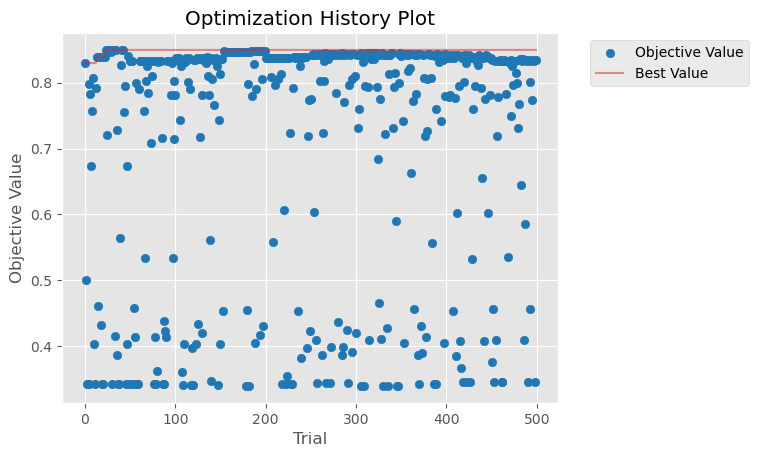

In [166]:
plot_optimization_history(study_svm);

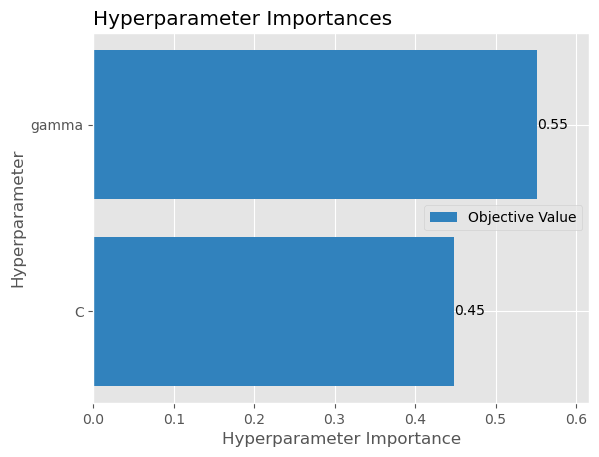

In [167]:
plot_param_importances(study_svm);

In [168]:
detailed_objective_svm_cv(study_svm.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,TP,211.400000,8.871928
1,TN,179.800000,10.580905
2,FP,39.000000,7.438638
3,FN,29.000000,3.590110
4,Accuracy,0.851925,0.017543
5,Precision,0.844569,0.026590
6,Sensitivity,0.879453,0.013465
7,Specificity,0.821840,0.031689
8,F1 score,0.861433,0.015941
9,F1 score (weighted),0.851687,0.017729


In [169]:
mat_met_svm_test['ave'] = mat_met_svm_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_svm_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave
0,TP,425.000000,427.000000,414.000000,452.000000,404.000000,422.000000,447.000000,430.000000,395.000000,422.000000,423.800000
1,TN,338.000000,365.000000,344.000000,328.000000,357.000000,363.000000,326.000000,343.000000,359.000000,373.000000,349.600000
2,FP,89.000000,70.000000,78.000000,76.000000,73.000000,72.000000,78.000000,87.000000,90.000000,77.000000,79.000000
3,FN,67.000000,57.000000,83.000000,63.000000,85.000000,62.000000,68.000000,59.000000,75.000000,47.000000,66.600000
4,Accuracy,0.830250,0.861806,0.824810,0.848749,0.828074,0.854189,0.841132,0.841132,0.820457,0.865071,0.841567
5,Precision,0.826848,0.859155,0.841463,0.856061,0.846960,0.854251,0.851429,0.831721,0.814433,0.845691,0.842801
6,Sensitivity,0.863821,0.882231,0.832998,0.877670,0.826176,0.871901,0.867961,0.879346,0.840426,0.899787,0.864232
7,Specificity,0.791600,0.839100,0.815200,0.811900,0.830200,0.834500,0.806900,0.797700,0.799600,0.828900,0.815560
8,F1 score,0.844930,0.870540,0.837209,0.866731,0.836439,0.862986,0.859615,0.854871,0.827225,0.871901,0.853245
9,F1 score (weighted),0.829862,0.861674,0.824883,0.848455,0.828189,0.854087,0.840900,0.840669,0.820342,0.864835,0.841390


In [170]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)


Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_svm=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_svm = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )


        #learn
        
        optimizedCV_svm.fit(X_train,y_train)
                          
                  
        #print(test_idx)
        y_pred_optimized_svm = optimizedCV_svm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_svm': y_pred_optimized_svm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        
        conf_matrix = confusion_matrix(y_test, y_pred_optimized_svm)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        Accuracy_outer.append(accuracy_score(y_test, y_pred_optimized_svm))
        Precision_outer.append(precision_score(y_test, y_pred_optimized_svm))
        Sensitivity_outer.append(recall_score(y_test, y_pred_optimized_svm))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test, y_pred_optimized_svm))
        f1_scores_W_outer.append(f1_score(y_test, y_pred_optimized_svm, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test, y_pred_optimized_svm, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test, y_pred_optimized_svm))
        MCC_outer.append(matthews_corrcoef(y_test, y_pred_optimized_svm))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test, y_pred_optimized_svm))
        
    data_svm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_svm['y_test' + str(i)] = data_inner['y_test']
    data_svm['y_pred_svm' + str(i)] = data_inner['y_pred_svm']
   # data_svm['correct' + str(i)] = correct_value
   # data_svm['pred' + str(i)] = y_pred_optimized_svm

mat_met_optimized_svm = pd.DataFrame({'Metric':['Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [ np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 

mat_met_optimized_svm


,Metric,Value (average),Value (std)
0,Accuracy,0.852743,0.018051
1,Precision,0.844309,0.022414
2,Sensitivity,0.881314,0.023558
3,Specificity,0.821482,0.025408
4,F1 score,0.862182,0.017939
5,F1 score (weighted),0.852497,0.018081
6,F1 score (macro),0.851853,0.018093
7,Balanced Accuracy,0.851401,0.018129
8,MCC,0.705149,0.036261
9,NPV,0.863202,0.025551


In [171]:
#cross valide using this optimized SVC 
svm_baseline_CVscore = cross_val_score(svm_clf, X, Y, cv=10, scoring="f1_macro")
#cv_svm_opt_testSet = cross_val_score(optimized_svm, X, Y, cv=10, scoring="f1_macro")
cv_svm_opt = cross_val_score(optimizedCV_svm, X, Y, cv=10, scoring="f1_macro")
print("SVM baseline model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(svm_baseline_CVscore), np.std(svm_baseline_CVscore, ddof=1)))
#print("SVM optimized model (tested on Y_te) f1_score %0.4f with a standard deviation of %0.4f" % (svm_baseline_CVscore.mean(), svm_baseline_CVscore.std()))
print("SVM optimized model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_svm_opt), np.std(cv_svm_opt, ddof=1)))

SVM baseline model f1_score 0.8172 with a standard deviation of 0.0162
SVM optimized model f1_score 0.8388 with a standard deviation of 0.0150


In [172]:
# save the modesls, both the one with optimized hyperparameters and the initial one
joblib.dump(svm_clf, "OUTPUT/svm_clf.joblib")
joblib.dump(optimizedCV_svm, "OUTPUT/optimizedCV_svm_clf.joblib")

['OUTPUT/optimizedCV_svm_clf.joblib']

In [177]:
# save the evaluation results of Optimized and saved models to an Excel file

with pd.ExcelWriter("OUTPUT/TestSet_EvaluationResults.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_rf_test.to_excel(writer, sheet_name="RF", )
    mat_met_lgbm_test.to_excel(writer, sheet_name="LGBM", )
    mat_met_xgb_test.to_excel(writer, sheet_name="XGB", )
    mat_met_knn_test.to_excel(writer, sheet_name="KNN", )
    mat_met_svm_test.to_excel(writer, sheet_name="SVM", )
   

In [178]:
# save the evaluation results of Optimized and saved models to an Excel file

with pd.ExcelWriter("OUTPUT/EvaluationResults.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_optimized_rf.to_excel(writer, sheet_name="RF", )
    mat_met_optimized_lgbm.to_excel(writer, sheet_name="LGBM", )
    mat_met_optimized_xgb.to_excel(writer, sheet_name="XGB", )
    mat_met_optimized_knn.to_excel(writer, sheet_name="KNN", )
    mat_met_optimized_svm.to_excel(writer, sheet_name="SVM", )